# SPE DSEATS AFRICA - DATATHON 2025
### Project Title: Classification of well using machine learning technique

### Challenge Objective
Participants are expected to work in teams of 3 to 5 persons (max) from at least 2 different
organizations and/or schools to develop a machine learning (ML) model that accurately
categorizes the 20 wells provided in the dataset by analysing their daily production data
trends. The teams should explore innovative approaches to accurately categorize or classify 

### Key Components 
1. Historical Production Data: Participants will have access to a dataset containing
historical production records, including production date, onstream hours, cumulative
oil, gas and water production, choke size, bottom hole pressure and temperature,
wellhead pressure and temperature and annulus pressure.
2. Evaluation Criteria: Submissions will be evaluated based on the accuracy and reliability
of the classification models, the creativity and effectiveness of the approaches
employed as well as the level of collaboration amongst team members.

### Deliverables
**Build ML model to analyze the datasets provided and make classifications**

Analyse the datasets provided following the standard machine learning workflow
which should include (but not limited to): data preparation, exploratory data analysis,
data preprocessing, feature engineering, modelling and classification.

#### Instructions / Expectations:
Using the dataset and the reservoir information provided, the teams are expected to develop
Python code to:
1) Identify the reservoir each well is producing from assuming not more than 200 psi
differential pressure at the maximum bottom hole pressure.
2) Determine for each reservoir whether saturated or undersaturated using the initial
condition
3) Identify whether the well is naturally flowing or gas lifted
4) Determine if production from a well is steady or unsteady. Consider unsteady wells as
those with more than 50% drop in oil production at least once every 3 to 6 months
5) Determine from the formation GOR trend whether the well is flowing at/below or
above the solution GOR of the selected reservoir or a combination of both trends
6) Determine from the watercut trend whether it is Flat, Increasing, Decreasing or a
Combination of 2 or more trends
7) Determine from the oil productivity index trend whether it is Flat, Increasing,
Decreasing or a Combination of 2 or more trends. You may use average reservoir
pressure for the oil productivity index computation
8) Teams should show the relevant production profiles / trend plots as part of the EDA
in their Python code


## Step 1
#### Import the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from scipy.stats import uniform
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import pprint

In [2]:
import warnings

# Ignore all Warnings globally
warnings.simplefilter("ignore")


## Step 2
#### Load and inspect the dataset

In [20]:
well_data = pd.read_csv("Data/wells.csv")
reservoir_data = pd.read_csv('Data/reservoir_info.csv')
well_data[well_data.WELL_NAME== 'Well_#1']

,Unnamed: 0,Unnamed: 1,PROD_DATE,WELL_NAME,ON_STREAM_HRS,BOTTOMHOLE_FLOWING_PRESSURE (PSI),DOWNHOLE_TEMPERATURE (deg F),ANNULUS_PRESS (PSI),CHOKE_SIZE (%),WELL_HEAD_PRESSURE (PSI),WELL_HEAD_TEMPERATURE (deg F),CUMULATIVE_OIL_PROD (STB),CUMULATIVE_FORMATION_GAS_PROD (MSCF),CUMULATIVE_TOTAL_GAS_PROD (MSCF),CUMULATIVE_WATER_PROD (BBL)
0,NaN,NaN,15-Feb-14,Well_#1,0.0,"4,050",189.866,0,1.17951,482.46,50.864,0,0,0,0
1,NaN,NaN,16-Feb-14,Well_#1,0.0,"3,961",189.945,0,2.99440,328.601,47.668,0,0,0,0
2,NaN,NaN,17-Feb-14,Well_#1,0.0,"3,961",190.004,0,1.90349,387.218,48.962,0,0,0,0
3,NaN,NaN,18-Feb-14,Well_#1,0.0,"3,964",190.020,0,0.00000,308.98,46.636,0,0,0,0
4,NaN,NaN,19-Feb-14,Well_#1,0.0,"3,965",190.107,0,30.20760,196.057,47.297,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,NaN,NaN,02-Sep-14,Well_#1,24.0,"2,891",208.800,992.824,49.40386,521.368,114.173,"100,534","104,224","143,739","37,495"
200,NaN,NaN,03-Sep-14,Well_#1,24.0,"2,871",208.856,969.742,49.41498,528.61,116.844,"100,820","104,532","144,154","37,797"
201,NaN,NaN,04-Sep-14,Well_#1,24.0,"2,872",208.837,"1,028.03",49.39999,519.954,115.641,"101,103","104,839","144,594","38,098"
202,NaN,NaN,05-Sep-14,Well_#1,24.0,"2,870",208.830,980.262,49.39932,506.045,112.150,"101,386","105,145","145,031","38,399"


In [21]:
reservoir_data

,Reservoir Name,Initial Reservoir Pressure (PSI),Bubble Point Pressure (PSI),Current Average Reservoir Pressure (PSI),Solution Gas-Oil-Ratio (SCF/BBL),Formation Volume Factor (RB/STB)
0,ACHI,"3,500","3,300","2,700",800,1.20
1,KEMA,"4,200","4,000","3,900",600,1.45
2,MAKO,"3,500","3,500","3,000",500,1.15
3,DEPU,"2,800","2,800","2,400","1,200",1.37
4,JANI,"4,500","4,300","4,200","1,000",1.30


In [22]:
reservoir_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 6 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Reservoir Name                            5 non-null      object 
 1   Initial Reservoir Pressure (PSI)          5 non-null      object 
 2   Bubble Point Pressure (PSI)               5 non-null      object 
 3   Current Average Reservoir Pressure (PSI)  5 non-null      object 
 4   Solution Gas-Oil-Ratio (SCF/BBL)          5 non-null      object 
 5   Formation Volume Factor (RB/STB)          5 non-null      float64
dtypes: float64(1), object(5)
memory usage: 372.0+ bytes


## Step 3
#### Data Cleaning and preparation

In [23]:
# drop unnecessary columns
well_data.drop(columns=(['Unnamed: 0', 'Unnamed: 1']), inplace=True)

In [24]:
well_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7955 entries, 0 to 7954
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   PROD_DATE                             7955 non-null   object 
 1   WELL_NAME                             7955 non-null   object 
 2   ON_STREAM_HRS                         7955 non-null   float64
 3   BOTTOMHOLE_FLOWING_PRESSURE (PSI)     7955 non-null   object 
 4   DOWNHOLE_TEMPERATURE (deg F)          7955 non-null   float64
 5   ANNULUS_PRESS (PSI)                   7955 non-null   object 
 6   CHOKE_SIZE (%)                        7955 non-null   float64
 7   WELL_HEAD_PRESSURE (PSI)              7955 non-null   object 
 8   WELL_HEAD_TEMPERATURE (deg F)         7955 non-null   float64
 9   CUMULATIVE_OIL_PROD (STB)             7955 non-null   object 
 10  CUMULATIVE_FORMATION_GAS_PROD (MSCF)  7955 non-null   object 
 11  CUMULATIVE_TOTAL_

In [25]:
# The'PROD_DATE' column is an 'object' type. Convert to datetime object for effective analysis
well_data['PROD_DATE'] = pd.to_datetime(well_data['PROD_DATE'], format= 'mixed', dayfirst = True)

well_data['PROD_DATE'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 7955 entries, 0 to 7954
Series name: PROD_DATE
Non-Null Count  Dtype         
--------------  -----         
7955 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 62.3 KB


In [26]:
# This function transform DataFrame columns names to the Conventional form
def conv_col_name(data_columns):
    index = []
    for i in data_columns:
        index.append(i.lower().replace(" ", "_").replace(")", "").replace("(", ""))
    return index
reservoir_data.columns = conv_col_name(reservoir_data.columns)
well_data.columns = conv_col_name(well_data.columns)

print(well_data.columns)
print()
reservoir_data.columns

Index(['prod_date', 'well_name', 'on_stream_hrs',
       'bottomhole_flowing_pressure_psi', 'downhole_temperature_deg_f',
       'annulus_press_psi', 'choke_size_%', 'well_head_pressure_psi',
       'well_head_temperature_deg_f', 'cumulative_oil_prod_stb',
       'cumulative_formation_gas_prod_mscf', 'cumulative_total_gas_prod_mscf',
       'cumulative_water_prod_bbl'],
      dtype='object')



Index(['reservoir_name', 'initial_reservoir_pressure_psi',
       'bubble_point_pressure_psi', 'current_average_reservoir_pressure_psi',
       'solution_gas-oil-ratio_scf/bbl', 'formation_volume_factor_rb/stb'],
      dtype='object')

In [27]:
# This function Converts DataFrame columns 'object' type to 'float' type if they are actually floats 
def objToFloat(dataframe, columns):
    for feature in columns:
        dataframe[feature] = dataframe[feature].str.replace(",","").astype(float)
    print('Object to float Conversion successfully completed')
    return dataframe



In [28]:
#  Converting object type features to float type as it should be for the reservoir data
reservoir_float_feat = ['initial_reservoir_pressure_psi','bubble_point_pressure_psi', 'current_average_reservoir_pressure_psi','solution_gas-oil-ratio_scf/bbl']
reservoir_data = objToFloat(reservoir_data, reservoir_float_feat)
reservoir_data.info()

Object to float Conversion successfully completed
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 6 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   reservoir_name                          5 non-null      object 
 1   initial_reservoir_pressure_psi          5 non-null      float64
 2   bubble_point_pressure_psi               5 non-null      float64
 3   current_average_reservoir_pressure_psi  5 non-null      float64
 4   solution_gas-oil-ratio_scf/bbl          5 non-null      float64
 5   formation_volume_factor_rb/stb          5 non-null      float64
dtypes: float64(5), object(1)
memory usage: 372.0+ bytes


In [29]:
well_float_feat = ['bottomhole_flowing_pressure_psi', 'annulus_press_psi', 'well_head_pressure_psi', 'cumulative_oil_prod_stb','cumulative_formation_gas_prod_mscf', 'cumulative_total_gas_prod_mscf', 'cumulative_water_prod_bbl']
well_data = objToFloat(well_data, well_float_feat)
well_data.info()

Object to float Conversion successfully completed
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7955 entries, 0 to 7954
Data columns (total 13 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   prod_date                           7955 non-null   datetime64[ns]
 1   well_name                           7955 non-null   object        
 2   on_stream_hrs                       7955 non-null   float64       
 3   bottomhole_flowing_pressure_psi     7955 non-null   float64       
 4   downhole_temperature_deg_f          7955 non-null   float64       
 5   annulus_press_psi                   7955 non-null   float64       
 6   choke_size_%                        7955 non-null   float64       
 7   well_head_pressure_psi              7955 non-null   float64       
 8   well_head_temperature_deg_f         7955 non-null   float64       
 9   cumulative_oil_prod_stb             7955 non-n

## Step 4: FEATURE ENGINEERING 

### Task 1 
##### Identify the reservoir each well is producing from assuming not more than 200 psi differential pressure at the maximum bottom hole pressure.

In [83]:
# Firstly: create a datframe containing the maximum bottom hole pressure for each well 
# name the dataframe as 'wellAndReservoirData'
well_bhfp_dict = []
for well in range(1, 21):
    m_bhfp = well_data[well_data['well_name'] == f'Well_#{well}']['bottomhole_flowing_pressure_psi'].max()
    dt = {'well': f'Well_#{well}', 'maximum_BHFP' : m_bhfp}
    well_bhfp_dict.append(dt)
wellAndReservoirData = pd.DataFrame(well_bhfp_dict)


wellAndReservoirData.head()

,well,maximum_BHFP
0,Well_#1,4096.0
1,Well_#2,3735.0
2,Well_#3,2985.0
3,Well_#4,2340.0
4,Well_#5,2933.0


In [85]:
# Secondly: Apply the assumption given above to obtain the reservoir each well produced from and update the DataFrame, "wellAndReservoirData"

current_average_res_press = reservoir_data['current_average_reservoir_pressure_psi']

# This variable keeps the extracted reservoir name each well produced from
reservoir_well_name = []

# This holds the calculated pressure differential
press_differ = []
ano = []
ano2 = []

# Looping through the whole 20 wells to calculate the pressure differential of each well/reservoir
for well in range(0, 20):
    collect_all_press_differ = []
    pmlist = []
    
    # looping through the 5 different reservoir for pressure differential calculation
    for index, reservoir in  enumerate(current_average_res_press):
        press_diff = reservoir - wellAndReservoirData['maximum_BHFP'].iloc[well]
        pm = wellAndReservoirData['maximum_BHFP'].iloc[well] - reservoir
        collect_all_press_differ.append(press_diff)
        pmlist.append(pm)

        # condition that selects the right reservoir based on the given condition
        if press_diff < 200 and press_diff > 1:
            reservoir_well_name.append(reservoir_data['reservoir_name'].iloc[index]) 
            press_differ.append(press_diff)
    ano.append(collect_all_press_differ)
    ano2.append(pmlist)


# Update well/reservoir DataFrame (wellAndReservoirData)
wellAndReservoirData['Reservoir Name'] = reservoir_well
wellAndReservoirData['Pressure Differential'] = press_differ
wellAndReservoirData['Pressure drawdown (Pr - Pwf)'] = ano
wellAndReservoirData['Pressure drawdown (Pwf - Pr)'] = ano2
#reservoir_name = wellAndReservoirData['Reservoir Name']
wellAndReservoirData.head(20)
    

,well,maximum_BHFP,Reservoir Name,Pressure Differential,Pressure drawdown (Pr - Pwf),Pressure drawdown (Pwf - Pr)
0,Well_#1,4096.0,JANI,104.0,"[-1396.0, -196.0, -1096.0, -1696.0, 104.0]","[1396.0, 196.0, 1096.0, 1696.0, -104.0]"
1,Well_#2,3735.0,KEMA,165.0,"[-1035.0, 165.0, -735.0, -1335.0, 465.0]","[1035.0, -165.0, 735.0, 1335.0, -465.0]"
2,Well_#3,2985.0,MAKO,15.0,"[-285.0, 915.0, 15.0, -585.0, 1215.0]","[285.0, -915.0, -15.0, 585.0, -1215.0]"
3,Well_#4,2340.0,DEPU,60.0,"[360.0, 1560.0, 660.0, 60.0, 1860.0]","[-360.0, -1560.0, -660.0, -60.0, -1860.0]"
4,Well_#5,2933.0,MAKO,67.0,"[-233.0, 967.0, 67.0, -533.0, 1267.0]","[233.0, -967.0, -67.0, 533.0, -1267.0]"
5,Well_#6,3797.0,KEMA,103.0,"[-1097.0, 103.0, -797.0, -1397.0, 403.0]","[1097.0, -103.0, 797.0, 1397.0, -403.0]"
6,Well_#7,3821.0,KEMA,79.0,"[-1121.0, 79.0, -821.0, -1421.0, 379.0]","[1121.0, -79.0, 821.0, 1421.0, -379.0]"
7,Well_#8,2681.0,ACHI,19.0,"[19.0, 1219.0, 319.0, -281.0, 1519.0]","[-19.0, -1219.0, -319.0, 281.0, -1519.0]"
8,Well_#9,2333.0,DEPU,67.0,"[367.0, 1567.0, 667.0, 67.0, 1867.0]","[-367.0, -1567.0, -667.0, -67.0, -1867.0]"
9,Well_#10,4051.0,JANI,149.0,"[-1351.0, -151.0, -1051.0, -1651.0, 149.0]","[1351.0, 151.0, 1051.0, 1651.0, -149.0]"


In [69]:
print('<<<<<<<<--------  The Reservoir each well from 1 to 20 produced from are as follow  -------->>>>>>>>')
reservoir_well

<<<<<<<<--------  The Reservoir each well from 1 to 20 produced from are as follow  -------->>>>>>>>


['JANI',
 'KEMA',
 'MAKO',
 'DEPU',
 'MAKO',
 'KEMA',
 'KEMA',
 'ACHI',
 'DEPU',
 'JANI',
 'ACHI',
 'ACHI',
 'DEPU',
 'MAKO',
 'JANI',
 'KEMA',
 'DEPU',
 'ACHI',
 'JANI',
 'MAKO']

### Task 2
##### Determine for each reservoir whether saturated or undersaturated using the initial condition

In [70]:
# Match the reservoir data with the new well/reservoir DataFrame for convenience

pack = []
for reservoir in wellAndReservoirData['Reservoir Name']:
    pack.append(reservoir_data[reservoir_data['reservoir_name'] == reservoir].values)
                
PACK = []               
for i in pack:
    PACK.append(i[0])

np.shape(PACK)
PACK

[array(['JANI', 4500.0, 4300.0, 4200.0, 1000.0, 1.3], dtype=object),
 array(['KEMA', 4200.0, 4000.0, 3900.0, 600.0, 1.45], dtype=object),
 array(['MAKO', 3500.0, 3500.0, 3000.0, 500.0, 1.15], dtype=object),
 array(['DEPU', 2800.0, 2800.0, 2400.0, 1200.0, 1.37], dtype=object),
 array(['MAKO', 3500.0, 3500.0, 3000.0, 500.0, 1.15], dtype=object),
 array(['KEMA', 4200.0, 4000.0, 3900.0, 600.0, 1.45], dtype=object),
 array(['KEMA', 4200.0, 4000.0, 3900.0, 600.0, 1.45], dtype=object),
 array(['ACHI', 3500.0, 3300.0, 2700.0, 800.0, 1.2], dtype=object),
 array(['DEPU', 2800.0, 2800.0, 2400.0, 1200.0, 1.37], dtype=object),
 array(['JANI', 4500.0, 4300.0, 4200.0, 1000.0, 1.3], dtype=object),
 array(['ACHI', 3500.0, 3300.0, 2700.0, 800.0, 1.2], dtype=object),
 array(['ACHI', 3500.0, 3300.0, 2700.0, 800.0, 1.2], dtype=object),
 array(['DEPU', 2800.0, 2800.0, 2400.0, 1200.0, 1.37], dtype=object),
 array(['MAKO', 3500.0, 3500.0, 3000.0, 500.0, 1.15], dtype=object),
 array(['JANI', 4500.0, 4300.0, 42

In [71]:
new_well_features = reservoir_data.columns
nwf_df = pd.DataFrame(PACK, columns = new_well_features)
wellAndReservoirData = pd.concat([wellAndReservoirData, nwf_df], axis= 1)
wellAndReservoirData.drop(columns= ['reservoir_name','Pressure drawdown (Pr - Pwf)', 'Pressure drawdown (Pwf - Pr)', 'maximum_BHFP'], inplace= True)
wellAndReservoirData.head()

,well,Reservoir Name,Pressure Differential,initial_reservoir_pressure_psi,bubble_point_pressure_psi,current_average_reservoir_pressure_psi,solution_gas-oil-ratio_scf/bbl,formation_volume_factor_rb/stb
0,Well_#1,JANI,104.0,4500.0,4300.0,4200.0,1000.0,1.30
1,Well_#2,KEMA,165.0,4200.0,4000.0,3900.0,600.0,1.45
2,Well_#3,MAKO,15.0,3500.0,3500.0,3000.0,500.0,1.15
3,Well_#4,DEPU,60.0,2800.0,2800.0,2400.0,1200.0,1.37
4,Well_#5,MAKO,67.0,3500.0,3500.0,3000.0,500.0,1.15


In [78]:
# Condition that determines if a reservoir is saturated or undersaturated using initial reservoir pressure and bubble point pressure
print(f'Reservoir Pressure      Bubble pt')
whether_sat_undersat = []
val = []
for i in range(20):
    print(wellAndReservoirData['initial_reservoir_pressure_psi'].iloc[i], '                ', wellAndReservoirData['bubble_point_pressure_psi'].iloc[i])
    if wellAndReservoirData['initial_reservoir_pressure_psi'].iloc[i] > wellAndReservoirData['bubble_point_pressure_psi'].iloc[i]:
        whether_sat_undersat.append('undersat')
        val.append(wellAndReservoirData['initial_reservoir_pressure_psi'].iloc[i] - wellAndReservoirData['bubble_point_pressure_psi'].iloc[i])
    else:
        whether_sat_undersat.append('saturated')
        val.append(wellAndReservoirData['initial_reservoir_pressure_psi'].iloc[i] - wellAndReservoirData['bubble_point_pressure_psi'].iloc[i])
print('<<<-------- Reservoir Type -------->>>')

val

Reservoir Pressure      Bubble pt
4500.0                  4300.0
4200.0                  4000.0
3500.0                  3500.0
2800.0                  2800.0
3500.0                  3500.0
4200.0                  4000.0
4200.0                  4000.0
3500.0                  3300.0
2800.0                  2800.0
4500.0                  4300.0
3500.0                  3300.0
3500.0                  3300.0
2800.0                  2800.0
3500.0                  3500.0
4500.0                  4300.0
4200.0                  4000.0
2800.0                  2800.0
3500.0                  3300.0
4500.0                  4300.0
3500.0                  3500.0
<<<-------- Reservoir Type -------->>>


[200.0,
 200.0,
 0.0,
 0.0,
 0.0,
 200.0,
 200.0,
 200.0,
 0.0,
 200.0,
 200.0,
 200.0,
 0.0,
 0.0,
 200.0,
 200.0,
 0.0,
 200.0,
 200.0,
 0.0]

In [79]:
# Let's update our well/reservoir DataFrame called wellAndReservoirData with the newly calculated 'Reservoir Type' vector
wellAndReservoirData['Reservoir Type'] = whether_sat_undersat


wellAndReservoirData.head()

,well,Reservoir Name,Pressure Differential,initial_reservoir_pressure_psi,bubble_point_pressure_psi,current_average_reservoir_pressure_psi,solution_gas-oil-ratio_scf/bbl,formation_volume_factor_rb/stb,Reservoir Type
0,Well_#1,JANI,104.0,4500.0,4300.0,4200.0,1000.0,1.30,undersat
1,Well_#2,KEMA,165.0,4200.0,4000.0,3900.0,600.0,1.45,undersat
2,Well_#3,MAKO,15.0,3500.0,3500.0,3000.0,500.0,1.15,saturated
3,Well_#4,DEPU,60.0,2800.0,2800.0,2400.0,1200.0,1.37,saturated
4,Well_#5,MAKO,67.0,3500.0,3500.0,3000.0,500.0,1.15,saturated


## Task 3
##### Identify whether the well is naturally flowing or gas lifted

Given that we have Cumulative formation gas produced and Total cumulative gas produced, one can infer that<br> 
if the `cumulative_formation_gas_produced` is less than `Total cumulative gas produced`, the well was gas lifted <br>
while if the `cumulative_formation_gas_produced` is equal to `Total cumulative gas produced`,<br>
it means that the well naturally flowed, since the gas produced was the formation only.

Therefore, with this in mind, let us classify our well as either naturally flowing(NF) or gas lifted(GL)

In [80]:
prod_data = well_data[(well_data['cumulative_oil_prod_stb'] > 0) & 
                    (well_data['cumulative_formation_gas_prod_mscf'] > 0)][['prod_date', 
                                                                            'well_name', 
                                                                            'cumulative_oil_prod_stb', 
                                                                            'cumulative_formation_gas_prod_mscf', 
                                                                            'cumulative_water_prod_bbl', 
                                                                            'cumulative_total_gas_prod_mscf']]

prod_data

,prod_date,well_name,cumulative_oil_prod_stb,cumulative_formation_gas_prod_mscf,cumulative_water_prod_bbl,cumulative_total_gas_prod_mscf
11,2014-02-26,Well_#1,631.0,636.0,0.0,852.0
12,2014-02-27,Well_#1,1798.0,1802.0,0.0,2518.0
13,2014-02-28,Well_#1,3348.0,3362.0,0.0,4715.0
14,2014-03-01,Well_#1,4596.0,4614.0,0.0,6514.0
15,2014-03-02,Well_#1,5942.0,5969.0,0.0,8289.0
...,...,...,...,...,...,...
7950,2015-04-05,Well_#20,497425.0,235131.0,522788.0,352697.0
7951,2015-04-06,Well_#20,497609.0,235205.0,523266.0,352808.0
7952,2015-04-07,Well_#20,497879.0,235314.0,523885.0,352971.0
7953,2015-04-08,Well_#20,498019.0,235370.0,524431.0,353055.0


In [81]:
# 
well_type = []
for well in range(1, 21):
    diff = prod_data[prod_data['well_name'] == f'Well_#{well}']['cumulative_total_gas_prod_mscf'] - prod_data[prod_data['well_name'] == f'Well_#{well}']['cumulative_formation_gas_prod_mscf']
    if diff.mean() == 0:
        well_type.append('NF')
    elif diff.mean() > 0:
        well_type.append('GL')

# Let's update the well/reservoir DataFrame called 'wellAndReservoirData' by adding a new column calculated above. 
# The column name is Production Type
wellAndReservoirData['Well Type'] = well_type
wellAndReservoirData.head()

,well,Reservoir Name,Pressure Differential,initial_reservoir_pressure_psi,bubble_point_pressure_psi,current_average_reservoir_pressure_psi,solution_gas-oil-ratio_scf/bbl,formation_volume_factor_rb/stb,Reservoir Type,Well Type
0,Well_#1,JANI,104.0,4500.0,4300.0,4200.0,1000.0,1.30,undersat,GL
1,Well_#2,KEMA,165.0,4200.0,4000.0,3900.0,600.0,1.45,undersat,NF
2,Well_#3,MAKO,15.0,3500.0,3500.0,3000.0,500.0,1.15,saturated,GL
3,Well_#4,DEPU,60.0,2800.0,2800.0,2400.0,1200.0,1.37,saturated,GL
4,Well_#5,MAKO,67.0,3500.0,3500.0,3000.0,500.0,1.15,saturated,NF


## Task 4
##### Determine if production from a well is steady or unsteady. Consider unsteady wells as those with more than 50% drop in oil production at least once every 3 to 6 months

In [26]:
wq = []
for well in range(1, 21):
    size = well_data[(well_data['well_name'] == f'Well_#{well}') &
                            (well_data['cumulative_oil_prod_stb'] > 0)]['cumulative_oil_prod_stb'].shape[0]
    p = []
    pp = []
    ppp = []
    for i in range(size-1):
        p.append(well_data[(well_data['well_name'] == f'Well_#{well}') &
                            (well_data['cumulative_oil_prod_stb'] > 0)]['cumulative_oil_prod_stb'].iloc[i+1] - well_data[(well_data['well_name'] == f'Well_#{well}') &
                            (well_data['cumulative_oil_prod_stb'] > 0)]['cumulative_oil_prod_stb'].iloc[i])
        pp.append(well_data[(well_data['well_name'] == f'Well_#{well}') &
                            (well_data['cumulative_oil_prod_stb'] > 0)]['cumulative_formation_gas_prod_mscf'].iloc[i+1] - well_data[(well_data['well_name'] == f'Well_#{well}') &
                            (well_data['cumulative_oil_prod_stb'] > 0)]['cumulative_formation_gas_prod_mscf'].iloc[i])
        ppp.append(well_data[(well_data['well_name'] == f'Well_#{well}') &
                            (well_data['cumulative_oil_prod_stb'] > 0)]['cumulative_water_prod_bbl'].iloc[i+1] - well_data[(well_data['well_name'] == f'Well_#{well}') &
                            (well_data['cumulative_oil_prod_stb'] > 0)]['cumulative_water_prod_bbl'].iloc[i])
    p.insert(0, well_data[(well_data['well_name'] == f'Well_#{well}') &
                            (well_data['cumulative_oil_prod_stb'] > 0)]['cumulative_oil_prod_stb'].iloc[0])
    pp.insert(0, well_data[(well_data['well_name'] == f'Well_#{well}') &
                            (well_data['cumulative_oil_prod_stb'] > 0)]['cumulative_formation_gas_prod_mscf'].iloc[0])
    ppp.insert(0, well_data[(well_data['well_name'] == f'Well_#{well}') &
                            (well_data['cumulative_oil_prod_stb'] > 0)]['cumulative_water_prod_bbl'].iloc[0])
    q = well_data[(well_data['well_name'] == f'Well_#{well}') &
                            (well_data['cumulative_oil_prod_stb'] > 0)]['cumulative_oil_prod_stb']
    qq = well_data[(well_data['well_name'] == f'Well_#{well}') &
                            (well_data['cumulative_oil_prod_stb'] > 0)]['cumulative_formation_gas_prod_mscf']
    qqq = well_data[(well_data['well_name'] == f'Well_#{well}') &
                            (well_data['cumulative_oil_prod_stb'] > 0)]['cumulative_water_prod_bbl']
    r = well_data[(well_data['well_name'] == f'Well_#{well}') &
                            (well_data['cumulative_oil_prod_stb'] > 0)]['bottomhole_flowing_pressure_psi']

    well = pd.DataFrame({'prod_date': 
                        well_data[(well_data['well_name'] == f'Well_#{well}') &(well_data['cumulative_oil_prod_stb'] > 0)]['prod_date'],
                        'well':  well_data[(well_data['well_name'] == f'Well_#{well}') &(well_data['cumulative_oil_prod_stb'] > 0)]['well_name'],
                       'cumulative_oil_prod_stb': q,
                       'daily_oil_prod_stb/d':p,
                       'cumulative_formation_gas_prod_mscf': qq,
                       'daily_formation_gas_prod_mscf': pp,
                       'cumulative_water_prod_bbl' : qqq,
                       'daily_water_prod_bbl': ppp,
                       'bottomhole_flowing_pressure_psi': r
                        })
    wq.append(well)

In [27]:
well_res = wq
wq[0].tail()

,prod_date,well,cumulative_oil_prod_stb,daily_oil_prod_stb/d,cumulative_formation_gas_prod_mscf,daily_formation_gas_prod_mscf,cumulative_water_prod_bbl,daily_water_prod_bbl,bottomhole_flowing_pressure_psi
199,2014-09-02,Well_#1,100534.0,282.0,104224.0,303.0,37495.0,306.0,2891.0
200,2014-09-03,Well_#1,100820.0,286.0,104532.0,308.0,37797.0,302.0,2871.0
201,2014-09-04,Well_#1,101103.0,283.0,104839.0,307.0,38098.0,301.0,2872.0
202,2014-09-05,Well_#1,101386.0,283.0,105145.0,306.0,38399.0,301.0,2870.0
203,2014-09-06,Well_#1,101659.0,273.0,105445.0,300.0,38698.0,299.0,2885.0


In [28]:
# Calculate monthly average oil production 

well_monthly_production = {}
for j in range(0, 20):
    month_well = wq[j]['prod_date'].dt.month.unique()
    avg_oil_prod = {}
    for i in month_well:
        avg_oil_prod[i] = wq[j][wq[j]['prod_date'].dt.month == i]['daily_oil_prod_stb/d'].mean()
    well_monthly_production[f'well #{j+1}'] = avg_oil_prod
    del avg_oil_prod
pprint.pprint(well_monthly_production)

{'well #1': {2: 1116.0,
             3: 935.1612903225806,
             4: 693.9,
             5: 495.9032258064516,
             6: 406.6666666666667,
             7: 314.93548387096774,
             8: 305.5483870967742,
             9: 282.6666666666667},
 'well #10': {1: 147.83870967741936,
              2: 261.10714285714283,
              3: 228.80645161290323,
              4: 229.23333333333332,
              5: 205.8709677419355,
              6: 314.23333333333335,
              7: 310.1290322580645,
              8: 295.0,
              9: 344.6326530612245,
              10: 310.9193548387097,
              11: 300.2142857142857,
              12: 228.19354838709677},
 'well #11': {1: 563.0,
              2: 534.4827586206897,
              3: 177.0,
              4: 576.2666666666667,
              5: 501.06451612903226,
              6: 406.5,
              7: 380.8709677419355,
              8: 426.2258064516129,
              9: 341.8,
              10: 718.258064516129

In [50]:
print('well classification based on steady and Unsteady state')
print()
condition_steady = []
for y in range(1, 21):
    print()
    print(f'well #{y}')
    value = list(well_monthly_production[f'well #{y}'].values())
    if len(value) <= 5:
        if ((value[0] - value[2]) / value[0]) * 100 > 50:
            print('Unsteady')
            condition_steady.append('Unsteady')
        elif ((value[0] - value[3]) / value[0]) * 100 > 50:
            print('Unsteady')
            condition_steady.append('Unsteady')
        elif ((value[0] - value[4]) / value[0]) * 100 > 50:
            print('Unsteady')
            condition_steady.append('Unsteady')
        else:
            print('Steady')
            condition_steady.append('Steady')
    else:
        if ((value[0] - value[2]) / value[0]) * 100 > 50:
            print('Unsteady')
            condition_steady.append('Unsteady')
        elif ((value[0] - value[3]) / value[0]) * 100 > 50:
            print('Unsteady')
            condition_steady.append('Unsteady')
        elif ((value[0] - value[4]) / value[0]) * 100 > 50:
            print('Unsteady')
            condition_steady.append('Unsteady')
        elif ((value[0] - value[5]) / value[0]) * 100 > 50:
            print('Unsteady')
            condition_steady.append('Unsteady')
        else:
            print('Steady')
            condition_steady.append('Steady')
    
    

well classification based on steady and Unsteady state


well #1
Unsteady

well #2
Unsteady

well #3
Steady

well #4
Steady

well #5
Unsteady

well #6
Steady

well #7
Steady

well #8
Steady

well #9
Steady

well #10
Unsteady

well #11
Unsteady

well #12
Steady

well #13
Steady

well #14
Steady

well #15
Unsteady

well #16
Steady

well #17
Steady

well #18
Steady

well #19
Steady

well #20
Steady


In [51]:
# Let's update our DataFrame as usual with the new 'Production Type' vector
wellAndReservoirData['Production Type'] = condition_steady

## Task 5
##### Determine from the formation GOR trend whether the well is flowing at/below or above the solution GOR of the selected reservoir or a combination of both trends

In [32]:
wq_df = pd.concat(wq, axis=0)

In [33]:
wq_df.tail()

,prod_date,well,cumulative_oil_prod_stb,daily_oil_prod_stb/d,cumulative_formation_gas_prod_mscf,daily_formation_gas_prod_mscf,cumulative_water_prod_bbl,daily_water_prod_bbl,bottomhole_flowing_pressure_psi
7950,2015-04-05,Well_#20,497425.0,170.0,235131.0,67.0,522788.0,445.0,2505.0
7951,2015-04-06,Well_#20,497609.0,184.0,235205.0,74.0,523266.0,478.0,2503.0
7952,2015-04-07,Well_#20,497879.0,270.0,235314.0,109.0,523885.0,619.0,2481.0
7953,2015-04-08,Well_#20,498019.0,140.0,235370.0,56.0,524431.0,546.0,2485.0
7954,2015-04-09,Well_#20,498126.0,107.0,235416.0,46.0,524844.0,413.0,2510.0


In [34]:
# Let's another column holding daily_formation_gas_prod_scf
# mscf means 1000 times scf
wqq = wq_df.copy()
wqq['daily_formation_gas_prod_scf'] = wqq['daily_formation_gas_prod_mscf'] * 1000
wqq.head()

,prod_date,well,cumulative_oil_prod_stb,daily_oil_prod_stb/d,cumulative_formation_gas_prod_mscf,daily_formation_gas_prod_mscf,cumulative_water_prod_bbl,daily_water_prod_bbl,bottomhole_flowing_pressure_psi,daily_formation_gas_prod_scf
11,2014-02-26,Well_#1,631.0,631.0,636.0,636.0,0.0,0.0,3777.0,636000.0
12,2014-02-27,Well_#1,1798.0,1167.0,1802.0,1166.0,0.0,0.0,3527.0,1166000.0
13,2014-02-28,Well_#1,3348.0,1550.0,3362.0,1560.0,0.0,0.0,3430.0,1560000.0
14,2014-03-01,Well_#1,4596.0,1248.0,4614.0,1252.0,0.0,0.0,3335.0,1252000.0
15,2014-03-02,Well_#1,5942.0,1346.0,5969.0,1355.0,0.0,0.0,3226.0,1355000.0


In [35]:
GOR = (wqq['daily_formation_gas_prod_scf'] / wqq['daily_oil_prod_stb/d']).round(2)
wqq['GOR'] = GOR
wqq.head()

,prod_date,well,cumulative_oil_prod_stb,daily_oil_prod_stb/d,cumulative_formation_gas_prod_mscf,daily_formation_gas_prod_mscf,cumulative_water_prod_bbl,daily_water_prod_bbl,bottomhole_flowing_pressure_psi,daily_formation_gas_prod_scf,GOR
11,2014-02-26,Well_#1,631.0,631.0,636.0,636.0,0.0,0.0,3777.0,636000.0,1007.92
12,2014-02-27,Well_#1,1798.0,1167.0,1802.0,1166.0,0.0,0.0,3527.0,1166000.0,999.14
13,2014-02-28,Well_#1,3348.0,1550.0,3362.0,1560.0,0.0,0.0,3430.0,1560000.0,1006.45
14,2014-03-01,Well_#1,4596.0,1248.0,4614.0,1252.0,0.0,0.0,3335.0,1252000.0,1003.21
15,2014-03-02,Well_#1,5942.0,1346.0,5969.0,1355.0,0.0,0.0,3226.0,1355000.0,1006.69


In [36]:
wqq.shape

(7559, 11)

In [37]:
wqq.isna().sum()

prod_date                               0
well                                    0
cumulative_oil_prod_stb                 0
daily_oil_prod_stb/d                    0
cumulative_formation_gas_prod_mscf      0
daily_formation_gas_prod_mscf           0
cumulative_water_prod_bbl               0
daily_water_prod_bbl                    0
bottomhole_flowing_pressure_psi         0
daily_formation_gas_prod_scf            0
GOR                                   455
dtype: int64

The `GOR` Column has `nan` beacause there were day that there was no production of oil or water<br>
So, it makes sense to remove them all(`nan`)

In [38]:
wqq.rename(columns= {'well': 'well_name'}, inplace= True)
wqq = wqq.dropna()
for_GOR = wqq
for_GOR.head()

,prod_date,well_name,cumulative_oil_prod_stb,daily_oil_prod_stb/d,cumulative_formation_gas_prod_mscf,daily_formation_gas_prod_mscf,cumulative_water_prod_bbl,daily_water_prod_bbl,bottomhole_flowing_pressure_psi,daily_formation_gas_prod_scf,GOR
11,2014-02-26,Well_#1,631.0,631.0,636.0,636.0,0.0,0.0,3777.0,636000.0,1007.92
12,2014-02-27,Well_#1,1798.0,1167.0,1802.0,1166.0,0.0,0.0,3527.0,1166000.0,999.14
13,2014-02-28,Well_#1,3348.0,1550.0,3362.0,1560.0,0.0,0.0,3430.0,1560000.0,1006.45
14,2014-03-01,Well_#1,4596.0,1248.0,4614.0,1252.0,0.0,0.0,3335.0,1252000.0,1003.21
15,2014-03-02,Well_#1,5942.0,1346.0,5969.0,1355.0,0.0,0.0,3226.0,1355000.0,1006.69


In [39]:
for_GOR.isna().sum()

prod_date                             0
well_name                             0
cumulative_oil_prod_stb               0
daily_oil_prod_stb/d                  0
cumulative_formation_gas_prod_mscf    0
daily_formation_gas_prod_mscf         0
cumulative_water_prod_bbl             0
daily_water_prod_bbl                  0
bottomhole_flowing_pressure_psi       0
daily_formation_gas_prod_scf          0
GOR                                   0
dtype: int64

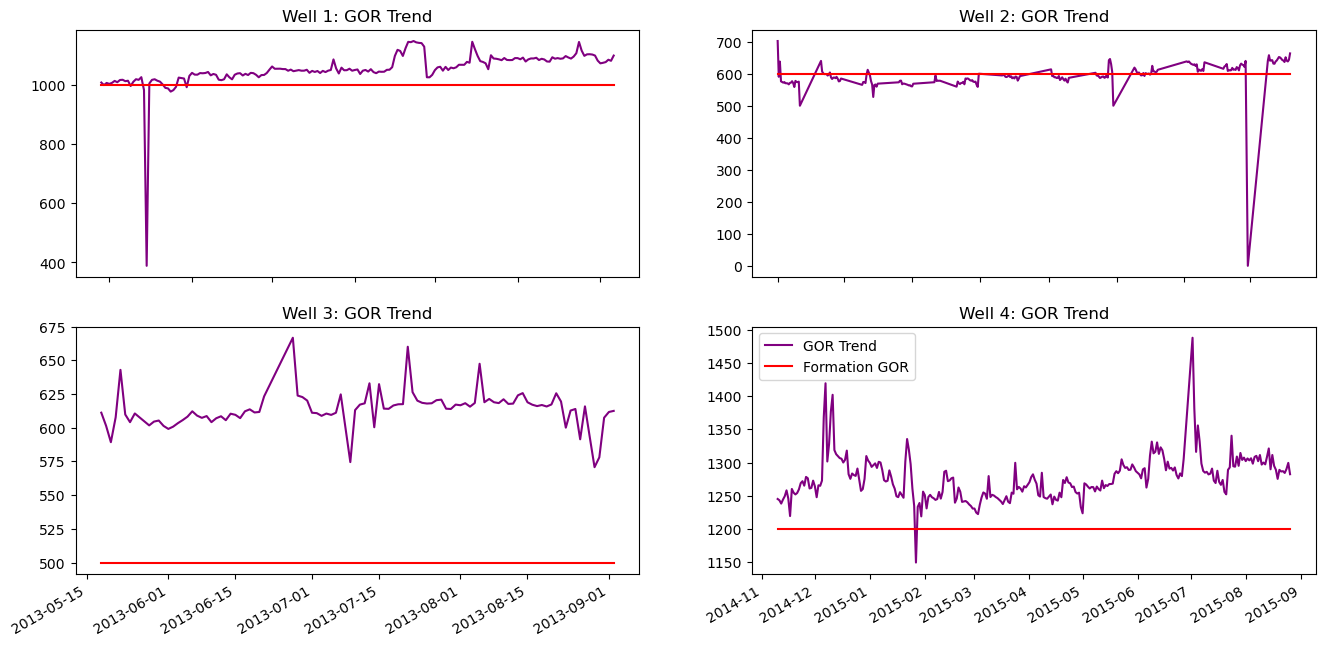

In [39]:
fig, ax = plt.subplots(2,2, figsize=(16,8))

h = for_GOR[for_GOR['well_name'] == 'Well_#1']['GOR'].shape[0]
ax[0, 0].plot(for_GOR[for_GOR['well_name'] == 'Well_#1']['prod_date'], for_GOR[for_GOR['well_name'] == 'Well_#1']['GOR'], 'purple', label = 'GOR Trend')
ax[0, 0].plot(for_GOR[for_GOR['well_name'] == 'Well_#1']['prod_date'], [wellAndReservoirData[wellAndReservoirData['well'] == 'Well_#1']['solution_gas-oil-ratio_scf/bbl']] * h, 'r', label = 'Formation GOR')
ax[0, 0].set_title('Well 1: GOR Trend')


h = for_GOR[for_GOR['well_name'] == 'Well_#2']['GOR'].shape[0]
ax[0, 1].plot(for_GOR[for_GOR['well_name'] == 'Well_#2']['prod_date'], for_GOR[for_GOR['well_name'] == 'Well_#2']['GOR'], 'purple', label = 'GOR Trend')
ax[0, 1].plot(for_GOR[for_GOR['well_name'] == 'Well_#2']['prod_date'], [wellAndReservoirData[wellAndReservoirData['well'] == 'Well_#2']['solution_gas-oil-ratio_scf/bbl']] * h, 'r', label = 'Formation GOR')
ax[0, 1].set_title('Well 2: GOR Trend')


h = for_GOR[for_GOR['well_name'] == 'Well_#3']['GOR'].shape[0]
ax[1, 0].plot(for_GOR[for_GOR['well_name'] == 'Well_#3']['prod_date'], for_GOR[for_GOR['well_name'] == 'Well_#3']['GOR'], 'purple', label = 'GOR Trend')
ax[1, 0].plot(for_GOR[for_GOR['well_name'] == 'Well_#3']['prod_date'], [wellAndReservoirData[wellAndReservoirData['well'] == 'Well_#3']['solution_gas-oil-ratio_scf/bbl']] * h, 'r', label = 'Formation GOR')
ax[1, 0].set_title('Well 3: GOR Trend')


h = for_GOR[for_GOR['well_name'] == 'Well_#4']['GOR'].shape[0]
ax[1, 1].plot(for_GOR[for_GOR['well_name'] == 'Well_#4']['prod_date'], for_GOR[for_GOR['well_name'] == 'Well_#4']['GOR'], 'purple', label = 'GOR Trend')
ax[1, 1].plot(for_GOR[for_GOR['well_name'] == 'Well_#4']['prod_date'], [wellAndReservoirData[wellAndReservoirData['well'] == 'Well_#4']['solution_gas-oil-ratio_scf/bbl']] * h, 'r', label = 'Formation GOR')
ax[1, 1].set_title('Well 4: GOR Trend')

fig.autofmt_xdate()
plt.legend()

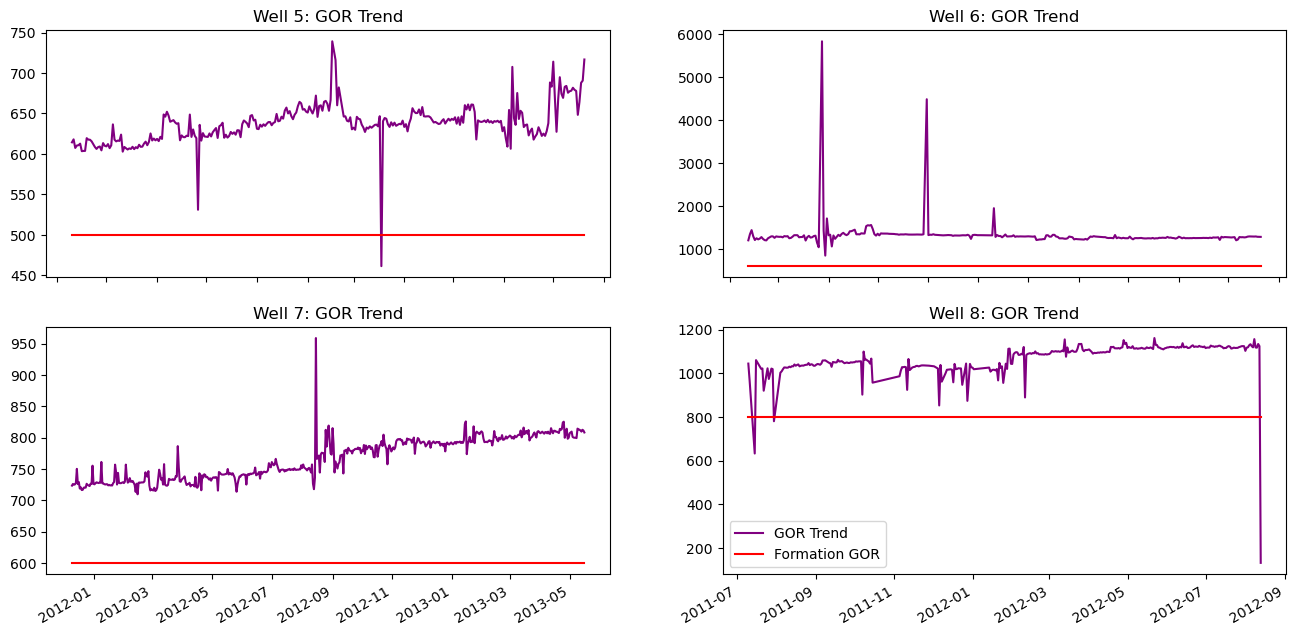

In [40]:
fig, ax = plt.subplots(2,2, figsize=(16,8))

h = for_GOR[for_GOR['well_name'] == 'Well_#5']['GOR'].shape[0]
ax[0, 0].plot(for_GOR[for_GOR['well_name'] == 'Well_#5']['prod_date'], for_GOR[for_GOR['well_name'] == 'Well_#5']['GOR'], 'purple', label = 'GOR Trend')
ax[0, 0].plot(for_GOR[for_GOR['well_name'] == 'Well_#5']['prod_date'], [wellAndReservoirData[wellAndReservoirData['well'] == 'Well_#5']['solution_gas-oil-ratio_scf/bbl']] * h, 'r', label = 'Formation GOR')
ax[0, 0].set_title('Well 5: GOR Trend')


h = for_GOR[for_GOR['well_name'] == 'Well_#6']['GOR'].shape[0]
ax[0, 1].plot(for_GOR[for_GOR['well_name'] == 'Well_#6']['prod_date'], for_GOR[for_GOR['well_name'] == 'Well_#6']['GOR'], 'purple', label = 'GOR Trend')
ax[0, 1].plot(for_GOR[for_GOR['well_name'] == 'Well_#6']['prod_date'], [wellAndReservoirData[wellAndReservoirData['well'] == 'Well_#6']['solution_gas-oil-ratio_scf/bbl']] * h, 'r', label = 'Formation GOR')
ax[0, 1].set_title('Well 6: GOR Trend')


h = for_GOR[for_GOR['well_name'] == 'Well_#7']['GOR'].shape[0]
ax[1, 0].plot(for_GOR[for_GOR['well_name'] == 'Well_#7']['prod_date'], for_GOR[for_GOR['well_name'] == 'Well_#7']['GOR'], 'purple', label = 'GOR Trend')
ax[1, 0].plot(for_GOR[for_GOR['well_name'] == 'Well_#7']['prod_date'], [wellAndReservoirData[wellAndReservoirData['well'] == 'Well_#7']['solution_gas-oil-ratio_scf/bbl']] * h, 'r', label = 'Formation GOR')
ax[1, 0].set_title('Well 7: GOR Trend')


h = for_GOR[for_GOR['well_name'] == 'Well_#8']['GOR'].shape[0]
ax[1, 1].plot(for_GOR[for_GOR['well_name'] == 'Well_#8']['prod_date'], for_GOR[for_GOR['well_name'] == 'Well_#8']['GOR'], 'purple', label = 'GOR Trend')
ax[1, 1].plot(for_GOR[for_GOR['well_name'] == 'Well_#8']['prod_date'], [wellAndReservoirData[wellAndReservoirData['well'] == 'Well_#8']['solution_gas-oil-ratio_scf/bbl']] * h, 'r', label = 'Formation GOR')
ax[1, 1].set_title('Well 8: GOR Trend')

fig.autofmt_xdate()
plt.legend()

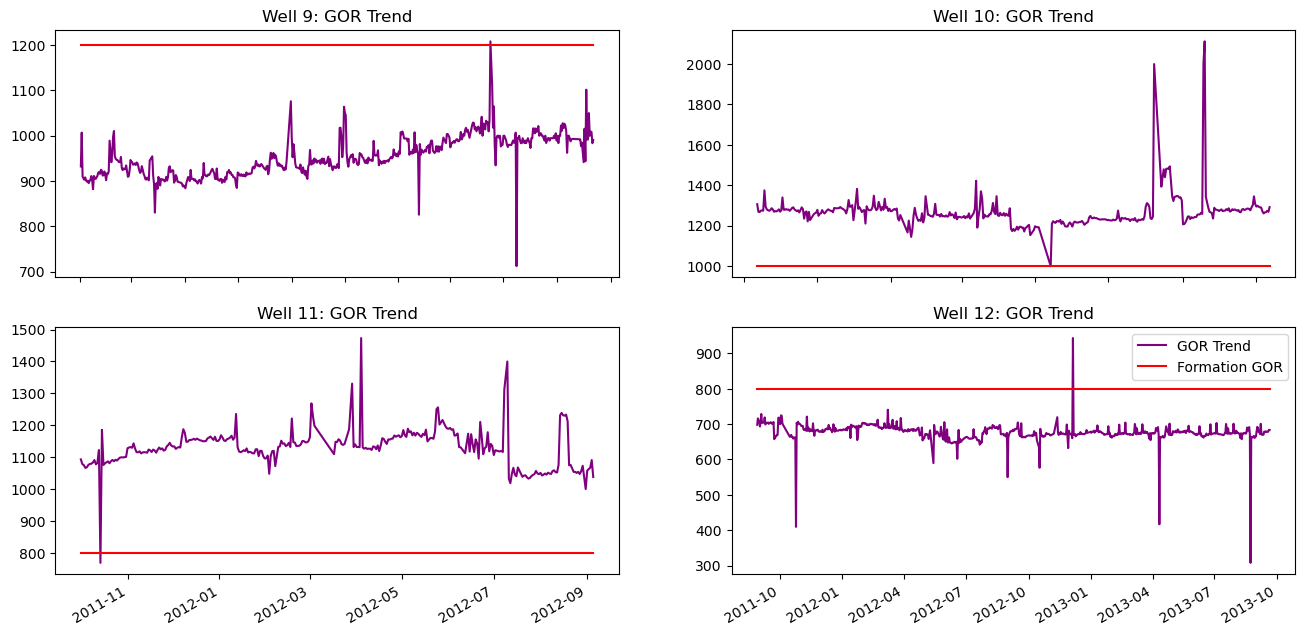

In [41]:
fig, ax = plt.subplots(2,2, figsize=(16,8))

h = for_GOR[for_GOR['well_name'] == 'Well_#9']['GOR'].shape[0]
ax[0, 0].plot(for_GOR[for_GOR['well_name'] == 'Well_#9']['prod_date'], for_GOR[for_GOR['well_name'] == 'Well_#9']['GOR'], 'purple', label = 'GOR Trend')
ax[0, 0].plot(for_GOR[for_GOR['well_name'] == 'Well_#9']['prod_date'], [wellAndReservoirData[wellAndReservoirData['well'] == 'Well_#9']['solution_gas-oil-ratio_scf/bbl']] * h, 'r', label = 'Formation GOR')
ax[0, 0].set_title('Well 9: GOR Trend')


h = for_GOR[for_GOR['well_name'] == 'Well_#10']['GOR'].shape[0]
ax[0, 1].plot(for_GOR[for_GOR['well_name'] == 'Well_#10']['prod_date'], for_GOR[for_GOR['well_name'] == 'Well_#10']['GOR'], 'purple', label = 'GOR Trend')
ax[0, 1].plot(for_GOR[for_GOR['well_name'] == 'Well_#10']['prod_date'], [wellAndReservoirData[wellAndReservoirData['well'] == 'Well_#10']['solution_gas-oil-ratio_scf/bbl']] * h, 'r', label = 'Formation GOR')
ax[0, 1].set_title('Well 10: GOR Trend')


h = for_GOR[for_GOR['well_name'] == 'Well_#11']['GOR'].shape[0]
ax[1, 0].plot(for_GOR[for_GOR['well_name'] == 'Well_#11']['prod_date'], for_GOR[for_GOR['well_name'] == 'Well_#11']['GOR'], 'purple', label = 'GOR Trend')
ax[1, 0].plot(for_GOR[for_GOR['well_name'] == 'Well_#11']['prod_date'], [wellAndReservoirData[wellAndReservoirData['well'] == 'Well_#11']['solution_gas-oil-ratio_scf/bbl']] * h, 'r', label = 'Formation GOR')
ax[1, 0].set_title('Well 11: GOR Trend')


h = for_GOR[for_GOR['well_name'] == 'Well_#12']['GOR'].shape[0]
ax[1, 1].plot(for_GOR[for_GOR['well_name'] == 'Well_#12']['prod_date'], for_GOR[for_GOR['well_name'] == 'Well_#12']['GOR'], 'purple', label = 'GOR Trend')
ax[1, 1].plot(for_GOR[for_GOR['well_name'] == 'Well_#12']['prod_date'], [wellAndReservoirData[wellAndReservoirData['well'] == 'Well_#12']['solution_gas-oil-ratio_scf/bbl']] * h, 'r', label = 'Formation GOR')
ax[1, 1].set_title('Well 12: GOR Trend')

fig.autofmt_xdate()

plt.legend()

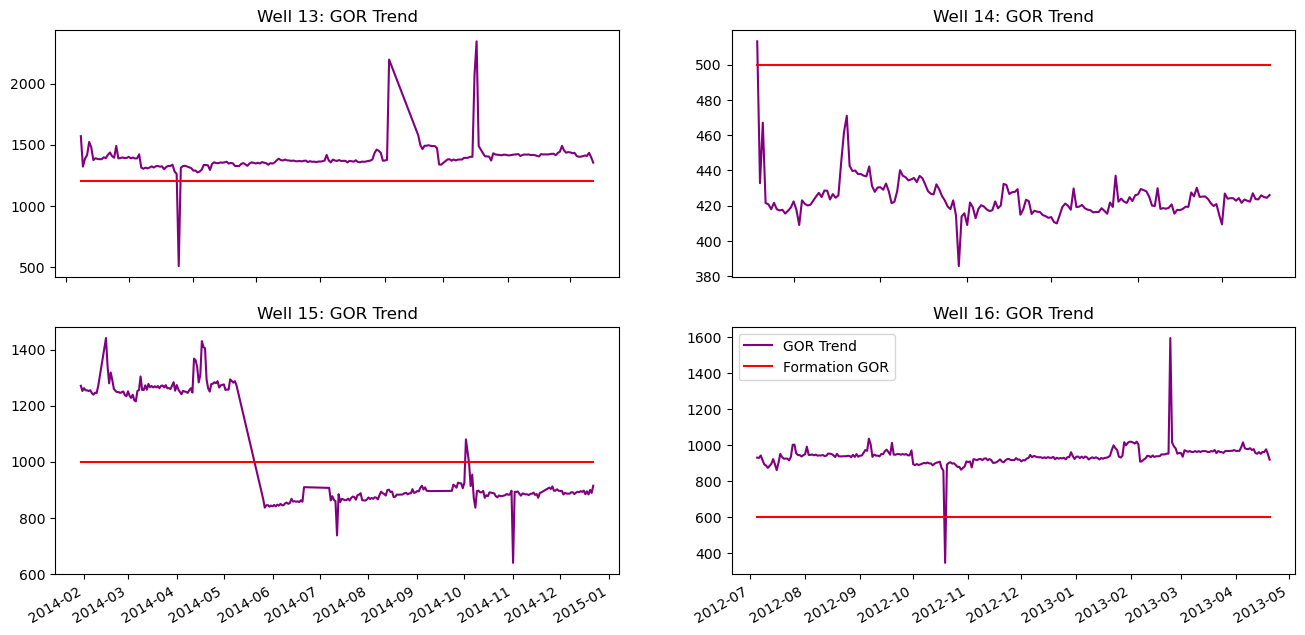

In [42]:
fig, ax = plt.subplots(2,2, figsize=(16,8))

h = for_GOR[for_GOR['well_name'] == 'Well_#13']['GOR'].shape[0]
ax[0, 0].plot(for_GOR[for_GOR['well_name'] == 'Well_#13']['prod_date'], for_GOR[for_GOR['well_name'] == 'Well_#13']['GOR'], 'purple', label = 'GOR Trend')
ax[0, 0].plot(for_GOR[for_GOR['well_name'] == 'Well_#13']['prod_date'], [wellAndReservoirData[wellAndReservoirData['well'] == 'Well_#13']['solution_gas-oil-ratio_scf/bbl']] * h, 'r', label = 'Formation GOR')
ax[0, 0].set_title('Well 13: GOR Trend')


h = for_GOR[for_GOR['well_name'] == 'Well_#14']['GOR'].shape[0]
ax[0, 1].plot(for_GOR[for_GOR['well_name'] == 'Well_#14']['prod_date'], for_GOR[for_GOR['well_name'] == 'Well_#14']['GOR'], 'purple', label = 'GOR Trend')
ax[0, 1].plot(for_GOR[for_GOR['well_name'] == 'Well_#14']['prod_date'], [wellAndReservoirData[wellAndReservoirData['well'] == 'Well_#14']['solution_gas-oil-ratio_scf/bbl']] * h, 'r', label = 'Formation GOR')
ax[0, 1].set_title('Well 14: GOR Trend')


h = for_GOR[for_GOR['well_name'] == 'Well_#15']['GOR'].shape[0]
ax[1, 0].plot(for_GOR[for_GOR['well_name'] == 'Well_#15']['prod_date'], for_GOR[for_GOR['well_name'] == 'Well_#15']['GOR'], 'purple', label = 'GOR Trend')
ax[1, 0].plot(for_GOR[for_GOR['well_name'] == 'Well_#15']['prod_date'], [wellAndReservoirData[wellAndReservoirData['well'] == 'Well_#15']['solution_gas-oil-ratio_scf/bbl']] * h, 'r', label = 'Formation GOR')
ax[1, 0].set_title('Well 15: GOR Trend')


h = for_GOR[for_GOR['well_name'] == 'Well_#16']['GOR'].shape[0]
ax[1, 1].plot(for_GOR[for_GOR['well_name'] == 'Well_#16']['prod_date'], for_GOR[for_GOR['well_name'] == 'Well_#16']['GOR'], 'purple', label = 'GOR Trend')
ax[1, 1].plot(for_GOR[for_GOR['well_name'] == 'Well_#16']['prod_date'], [wellAndReservoirData[wellAndReservoirData['well'] == 'Well_#16']['solution_gas-oil-ratio_scf/bbl']] * h, 'r', label = 'Formation GOR')
ax[1, 1].set_title('Well 16: GOR Trend')

fig.autofmt_xdate()

plt.legend()

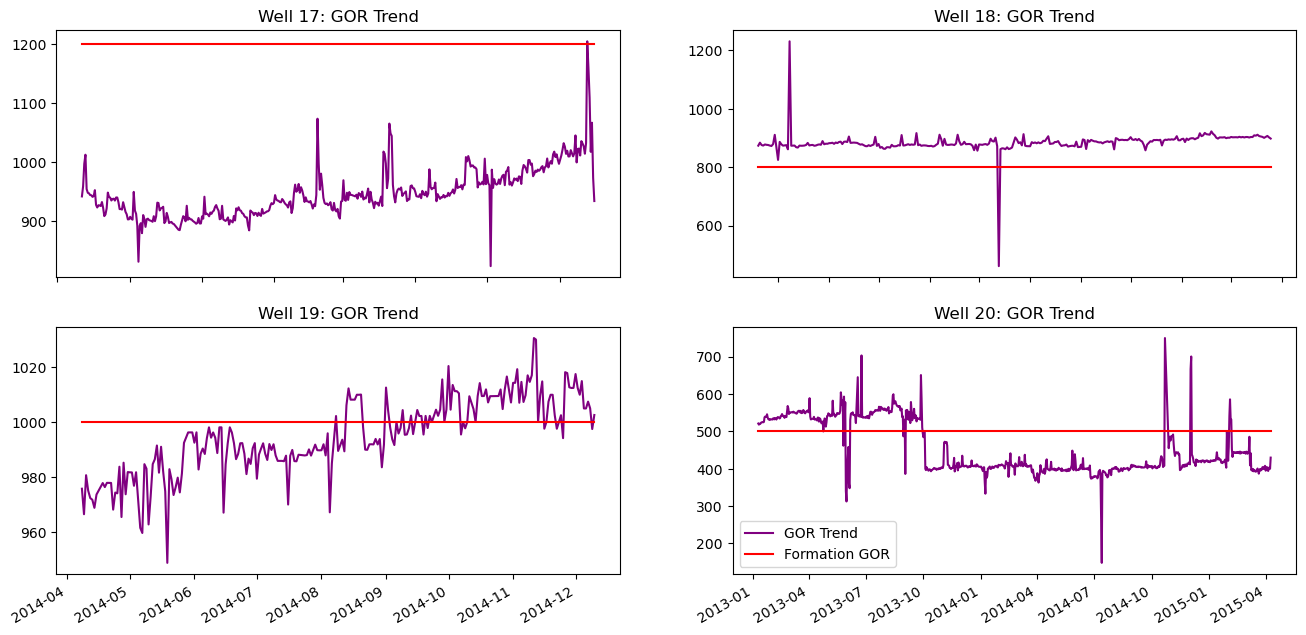

In [43]:
fig, ax = plt.subplots(2,2, figsize=(16,8))

h = for_GOR[for_GOR['well_name'] == 'Well_#17']['GOR'].shape[0]
ax[0, 0].plot(for_GOR[for_GOR['well_name'] == 'Well_#17']['prod_date'], for_GOR[for_GOR['well_name'] == 'Well_#17']['GOR'], 'purple', label = 'GOR Trend')
ax[0, 0].plot(for_GOR[for_GOR['well_name'] == 'Well_#17']['prod_date'], [wellAndReservoirData[wellAndReservoirData['well'] == 'Well_#17']['solution_gas-oil-ratio_scf/bbl']] * h, 'r', label = 'Formation GOR')
ax[0, 0].set_title('Well 17: GOR Trend')


h = for_GOR[for_GOR['well_name'] == 'Well_#18']['GOR'].shape[0]
ax[0, 1].plot(for_GOR[for_GOR['well_name'] == 'Well_#18']['prod_date'], for_GOR[for_GOR['well_name'] == 'Well_#18']['GOR'], 'purple', label = 'GOR Trend')
ax[0, 1].plot(for_GOR[for_GOR['well_name'] == 'Well_#18']['prod_date'], [wellAndReservoirData[wellAndReservoirData['well'] == 'Well_#18']['solution_gas-oil-ratio_scf/bbl']] * h, 'r', label = 'Formation GOR')
ax[0, 1].set_title('Well 18: GOR Trend')

fig.autofmt_xdate()
h = for_GOR[for_GOR['well_name'] == 'Well_#19']['GOR'].shape[0]
ax[1, 0].plot(for_GOR[for_GOR['well_name'] == 'Well_#19']['prod_date'], for_GOR[for_GOR['well_name'] == 'Well_#19']['GOR'], 'purple', label = 'GOR Trend')
ax[1, 0].plot(for_GOR[for_GOR['well_name'] == 'Well_#19']['prod_date'], [wellAndReservoirData[wellAndReservoirData['well'] == 'Well_#19']['solution_gas-oil-ratio_scf/bbl']] * h, 'r', label = 'Formation GOR')
ax[1, 0].set_title('Well 19: GOR Trend')


h = for_GOR[for_GOR['well_name'] == 'Well_#20']['GOR'].shape[0]
ax[1, 1].plot(for_GOR[for_GOR['well_name'] == 'Well_#20']['prod_date'], for_GOR[for_GOR['well_name'] == 'Well_#20']['GOR'], 'purple', label = 'GOR Trend')
ax[1, 1].plot(for_GOR[for_GOR['well_name'] == 'Well_#20']['prod_date'], [wellAndReservoirData[wellAndReservoirData['well'] == 'Well_#20']['solution_gas-oil-ratio_scf/bbl']] * h, 'r', label = 'Formation GOR')
ax[1, 1].set_title('Well 20: GOR Trend')

fig.autofmt_xdate()

plt.legend()

In [52]:
# From the GOR trend plot above, we extrapolate our formation GOR trend
'''
NF: Naturally Flowing 
GL: Gas Lifted 
saturated: saturated
Undersat: Undersaturated reservoir 
Flat: Flat or fairly horizontal line trend
Incr: Increasing trend
Decr: Decreasing trend
aSolGOR: Above Solution GOR 
Combo: Combination of two or more trends
bSolGOR: At or below solution gas oil ratio (GOR)
'''


GOR_Trend = ['Combo', 'Combo', 'aSolGOR', 'aSolGOR', 'aSolGOR',
            'aSolGOR', 'aSolGOR', 'aSolGOR', 'bSolGOR', 'aSolGOR',
            'aSolGOR', 'bSolGOR', 'aSolGOR', 'bSolGOR', 'Combo',
            'aSolGOR', 'bSolGOR', 'aSolGOR', 'Combo', 'Combo']

In [53]:
wellAndReservoirData.columns

Index(['well', 'maximum_BHFP', 'Reservoir Name', 'Pressure Difference',
       'All Pressure differential', 'initial_reservoir_pressure_psi',
       'bubble_point_pressure_psi', 'current_average_reservoir_pressure_psi',
       'solution_gas-oil-ratio_scf/bbl', 'formation_volume_factor_rb/stb',
       'Reservoir Type', 'Well Type', 'average_bottomhole_flowing_pressure',
       'average_downhole_temperature', 'average_well_head_pressure',
       'average_well_head_temperature', 'average_choke_size', 'Formation GOR',
       'Production Type'],
      dtype='object')

In [54]:
# Let's update our DataFrame as usual with the new 'Production Type' vector
wellAndReservoirData['Formation GOR'] = GOR_Trend
actual_well_classifier = wellAndReservoirData[['well', 'Reservoir Name',
       'Reservoir Type', 'Well Type', 'Production Type', 'Formation GOR']]

actual_well_classifier.head()

,well,Reservoir Name,Reservoir Type,Well Type,Production Type,Formation GOR
0,Well_#1,JANI,undersat,GL,Unsteady,Combo
1,Well_#2,KEMA,undersat,NF,Unsteady,Combo
2,Well_#3,MAKO,saturated,GL,Steady,aSolGOR
3,Well_#4,DEPU,saturated,GL,Steady,aSolGOR
4,Well_#5,MAKO,saturated,NF,Unsteady,aSolGOR


## Task 6
##### Determine from the watercut trend whether it is Flat, Increasing, Decreasing or a Combination of 2 or more trends

In [55]:
# do another copy
wqqq = wq.copy()
wqqq = pd.concat(wqqq)
water_cut = (wqqq['cumulative_water_prod_bbl'] / (wqqq['cumulative_oil_prod_stb'] + wqqq['cumulative_water_prod_bbl'])) * 100
water_cut

11       0.000000
12       0.000000
13       0.000000
14       0.000000
15       0.000000
          ...    
7950    51.243025
7951    51.256618
7952    51.272603
7953    51.291604
7954    51.305903
Length: 7559, dtype: float64

In [56]:
wqqq['water_cut'] = water_cut

In [57]:
wqqq.head()

,prod_date,well,cumulative_oil_prod_stb,daily_oil_prod_stb/d,cumulative_formation_gas_prod_mscf,daily_formation_gas_prod_mscf,cumulative_water_prod_bbl,daily_water_prod_bbl,bottomhole_flowing_pressure_psi,water_cut
11,2014-02-26,Well_#1,631.0,631.0,636.0,636.0,0.0,0.0,3777.0,0.0
12,2014-02-27,Well_#1,1798.0,1167.0,1802.0,1166.0,0.0,0.0,3527.0,0.0
13,2014-02-28,Well_#1,3348.0,1550.0,3362.0,1560.0,0.0,0.0,3430.0,0.0
14,2014-03-01,Well_#1,4596.0,1248.0,4614.0,1252.0,0.0,0.0,3335.0,0.0
15,2014-03-02,Well_#1,5942.0,1346.0,5969.0,1355.0,0.0,0.0,3226.0,0.0


In [58]:
wqqq.isna().sum()

prod_date                             0
well                                  0
cumulative_oil_prod_stb               0
daily_oil_prod_stb/d                  0
cumulative_formation_gas_prod_mscf    0
daily_formation_gas_prod_mscf         0
cumulative_water_prod_bbl             0
daily_water_prod_bbl                  0
bottomhole_flowing_pressure_psi       0
water_cut                             0
dtype: int64

In [59]:
wqqq.rename(columns = {'well': 'well_name'}, inplace= True)
for_GOR = wqqq

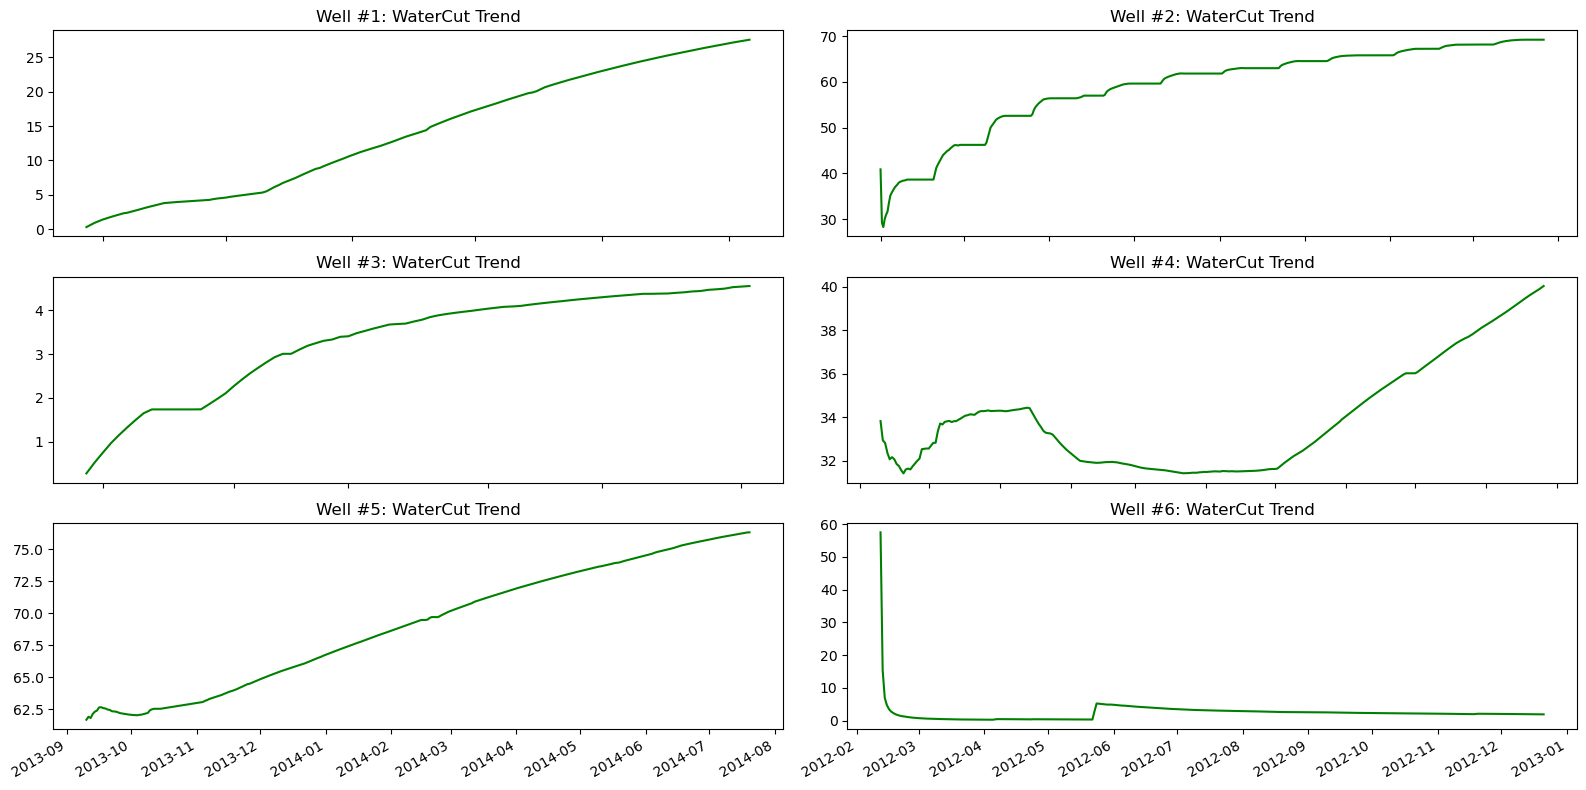

In [87]:
fig2, ax2 = plt.subplots(3,2, figsize=(16, 8))

ax2[0, 0].plot(for_GOR[(for_GOR['well_name'] == 'Well_#1') & (for_GOR['water_cut'])]['prod_date'], for_GOR[(for_GOR['well_name'] == 'Well_#1') & (for_GOR['water_cut'])]['water_cut'], 'green')
ax2[0, 0].set_title('Well #1: WaterCut Trend')

ax2[0, 1].plot(for_GOR[(for_GOR['well_name'] == 'Well_#2') & (for_GOR['water_cut'])]['prod_date'], for_GOR[(for_GOR['well_name'] == 'Well_#2') & (for_GOR['water_cut'])]['water_cut'], 'green')
ax2[0, 1].set_title('Well #2: WaterCut Trend')

ax2[1, 0].plot(for_GOR[(for_GOR['well_name'] == 'Well_#3') & (for_GOR['water_cut'])]['prod_date'], for_GOR[(for_GOR['well_name'] == 'Well_#3') & (for_GOR['water_cut'])]['water_cut'], 'green')
ax2[1, 0].set_title('Well #3: WaterCut Trend')

ax2[1, 1].plot(for_GOR[(for_GOR['well_name'] == 'Well_#4') & (for_GOR['water_cut'])]['prod_date'], for_GOR[(for_GOR['well_name'] == 'Well_#4') & (for_GOR['water_cut'])]['water_cut'], 'green')
ax2[1, 1].set_title('Well #4: WaterCut Trend')

ax2[2, 0].plot(for_GOR[(for_GOR['well_name'] == 'Well_#5') & (for_GOR['water_cut'])]['prod_date'], for_GOR[(for_GOR['well_name'] == 'Well_#5') & (for_GOR['water_cut'])]['water_cut'], 'green')
ax2[2, 0].set_title('Well #5: WaterCut Trend')

ax2[2, 1].plot(for_GOR[(for_GOR['well_name'] == 'Well_#6') & (for_GOR['water_cut'])]['prod_date'], for_GOR[(for_GOR['well_name'] == 'Well_#6') & (for_GOR['water_cut'])]['water_cut'], 'green')
ax2[2, 1].set_title('Well #6: WaterCut Trend')
fig2.autofmt_xdate()

plt.tight_layout()

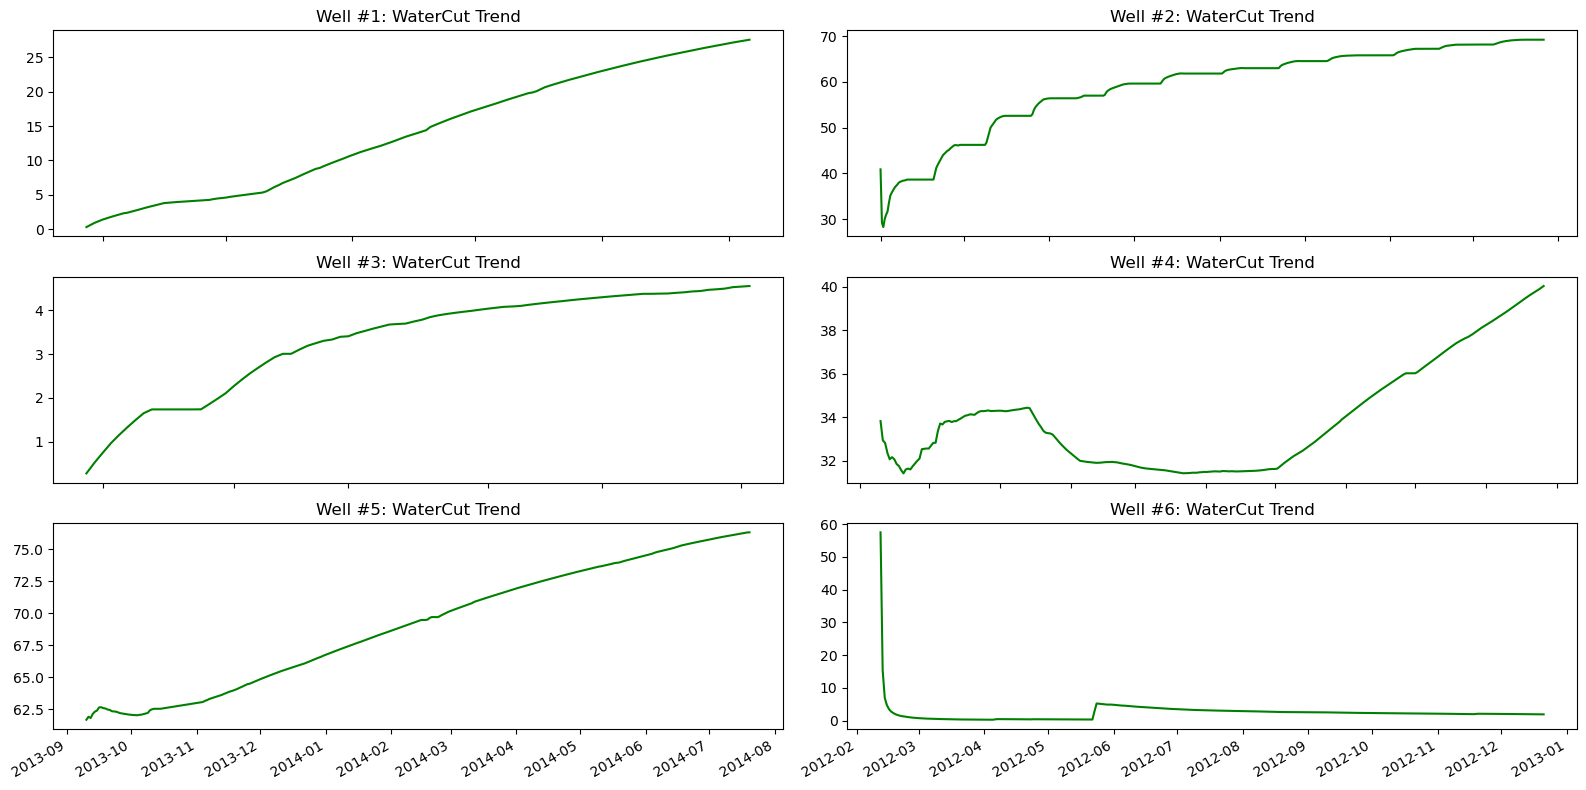

In [52]:
fig2, ax2 = plt.subplots(3,2, figsize=(16, 8))

ax2[0, 0].plot(for_GOR[(for_GOR['well_name'] == 'Well_#1') & (for_GOR['water_cut'] > 0)]['prod_date'], for_GOR[(for_GOR['well_name'] == 'Well_#1') & (for_GOR['water_cut'] > 0)]['water_cut'], 'green')
ax2[0, 0].set_title('Well #1: WaterCut Trend')

ax2[0, 1].plot(for_GOR[(for_GOR['well_name'] == 'Well_#2') & (for_GOR['water_cut'] > 0)]['prod_date'], for_GOR[(for_GOR['well_name'] == 'Well_#2') & (for_GOR['water_cut'] > 0)]['water_cut'], 'green')
ax2[0, 1].set_title('Well #2: WaterCut Trend')

ax2[1, 0].plot(for_GOR[(for_GOR['well_name'] == 'Well_#3') & (for_GOR['water_cut'] > 0)]['prod_date'], for_GOR[(for_GOR['well_name'] == 'Well_#3') & (for_GOR['water_cut'] > 0)]['water_cut'], 'green')
ax2[1, 0].set_title('Well #3: WaterCut Trend')

ax2[1, 1].plot(for_GOR[(for_GOR['well_name'] == 'Well_#4') & (for_GOR['water_cut'] > 0)]['prod_date'], for_GOR[(for_GOR['well_name'] == 'Well_#4') & (for_GOR['water_cut'] > 0)]['water_cut'], 'green')
ax2[1, 1].set_title('Well #4: WaterCut Trend')

ax2[2, 0].plot(for_GOR[(for_GOR['well_name'] == 'Well_#5') & (for_GOR['water_cut'] > 0)]['prod_date'], for_GOR[(for_GOR['well_name'] == 'Well_#5') & (for_GOR['water_cut'] > 0)]['water_cut'], 'green')
ax2[2, 0].set_title('Well #5: WaterCut Trend')

ax2[2, 1].plot(for_GOR[(for_GOR['well_name'] == 'Well_#6') & (for_GOR['water_cut'] > 0)]['prod_date'], for_GOR[(for_GOR['well_name'] == 'Well_#6') & (for_GOR['water_cut'] > 0)]['water_cut'], 'green')
ax2[2, 1].set_title('Well #6: WaterCut Trend')
fig2.autofmt_xdate()

plt.tight_layout()

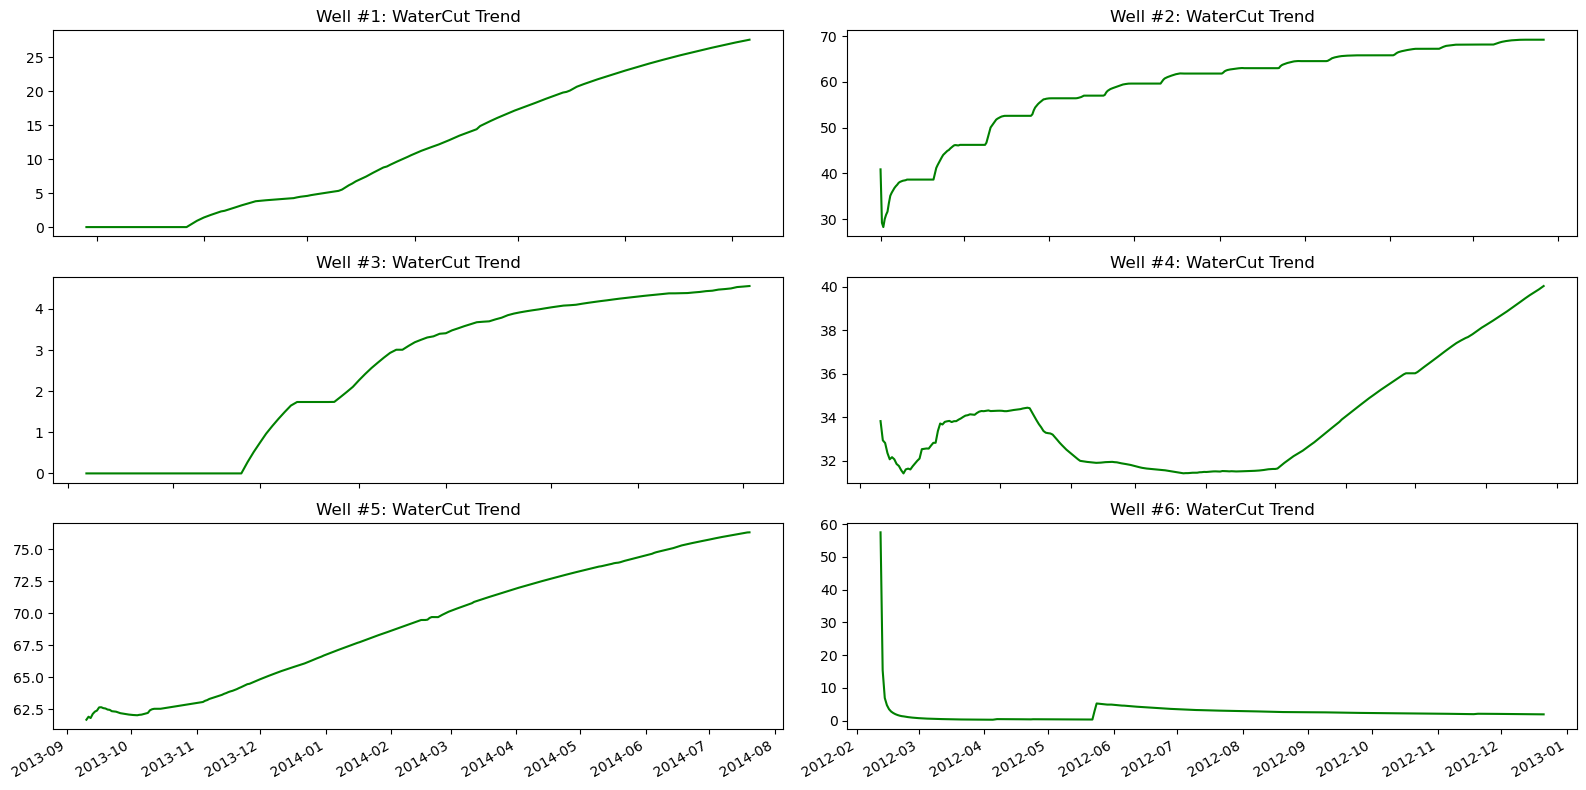

In [53]:
fig2, ax2 = plt.subplots(3,2, figsize=(16, 8))

ax2[0, 0].plot(for_GOR[for_GOR['well_name'] == 'Well_#1']['prod_date'], for_GOR[for_GOR['well_name'] == 'Well_#1']['water_cut'], 'green')
ax2[0, 0].set_title('Well #1: WaterCut Trend')

ax2[0, 1].plot(for_GOR[for_GOR['well_name'] == 'Well_#2']['prod_date'], for_GOR[for_GOR['well_name'] == 'Well_#2']['water_cut'], 'green')
ax2[0, 1].set_title('Well #2: WaterCut Trend')

ax2[1, 0].plot(for_GOR[for_GOR['well_name'] == 'Well_#3']['prod_date'], for_GOR[for_GOR['well_name'] == 'Well_#3']['water_cut'], 'green')
ax2[1, 0].set_title('Well #3: WaterCut Trend')

ax2[1, 1].plot(for_GOR[for_GOR['well_name'] == 'Well_#4']['prod_date'], for_GOR[for_GOR['well_name'] == 'Well_#4']['water_cut'], 'green')
ax2[1, 1].set_title('Well #4: WaterCut Trend')

ax2[2, 0].plot(for_GOR[for_GOR['well_name'] == 'Well_#5']['prod_date'], for_GOR[for_GOR['well_name'] == 'Well_#5']['water_cut'], 'green')
ax2[2, 0].set_title('Well #5: WaterCut Trend')

ax2[2, 1].plot(for_GOR[for_GOR['well_name'] == 'Well_#6']['prod_date'], for_GOR[for_GOR['well_name'] == 'Well_#6']['water_cut'], 'green')
ax2[2, 1].set_title('Well #6: WaterCut Trend')

fig2.autofmt_xdate()
plt.tight_layout()

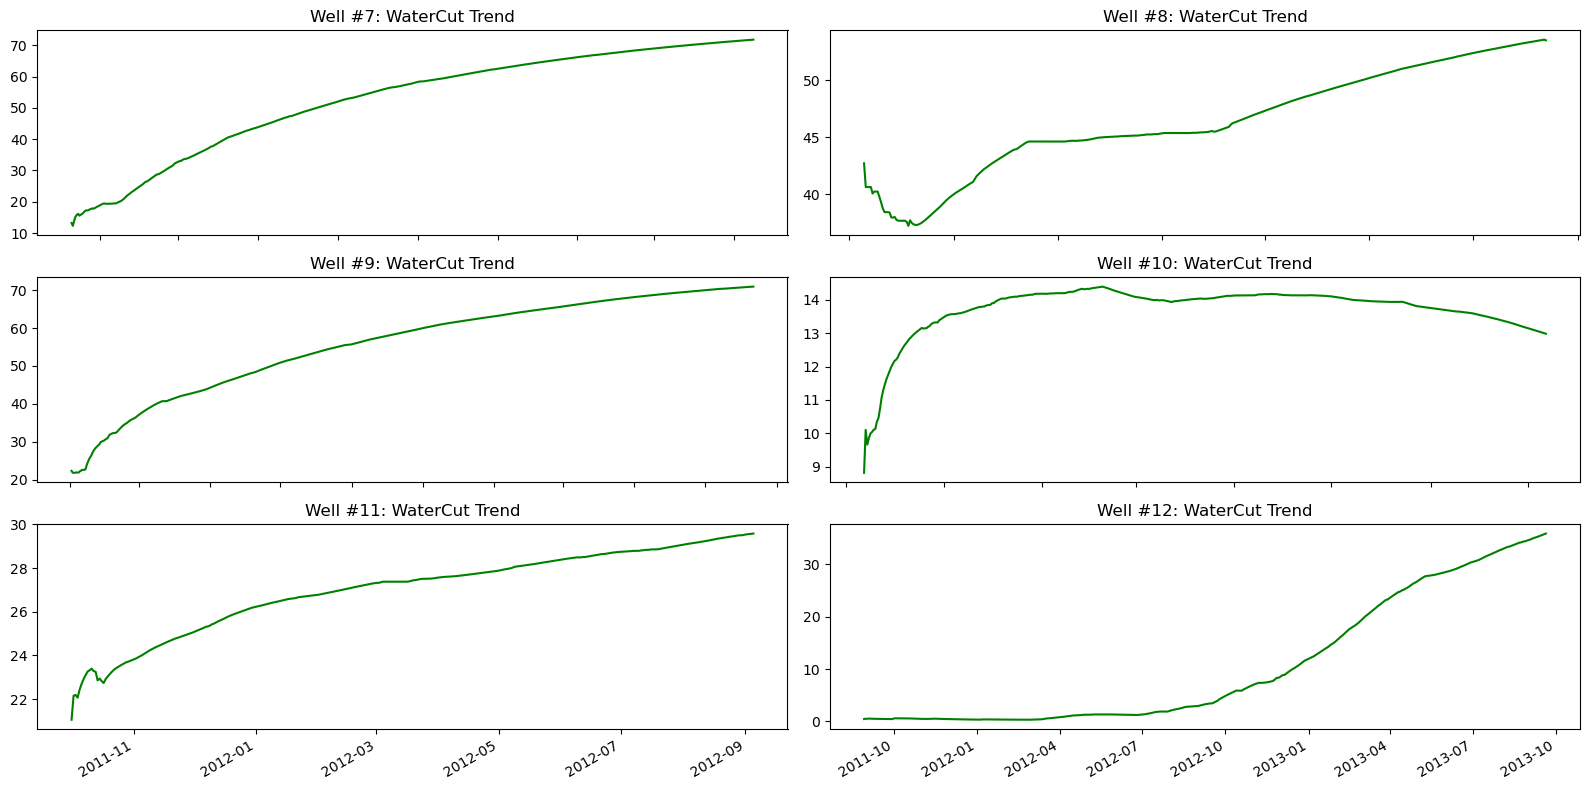

In [54]:
fig2, ax2 = plt.subplots(3,2, figsize=(16, 8))

ax2[0, 0].plot(for_GOR[for_GOR['well_name'] == 'Well_#7']['prod_date'], for_GOR[for_GOR['well_name'] == 'Well_#7']['water_cut'], 'green')
ax2[0, 0].set_title('Well #7: WaterCut Trend')

ax2[0, 1].plot(for_GOR[for_GOR['well_name'] == 'Well_#8']['prod_date'], for_GOR[for_GOR['well_name'] == 'Well_#8']['water_cut'], 'green')
ax2[0, 1].set_title('Well #8: WaterCut Trend')

ax2[1, 0].plot(for_GOR[for_GOR['well_name'] == 'Well_#9']['prod_date'], for_GOR[for_GOR['well_name'] == 'Well_#9']['water_cut'], 'green')
ax2[1, 0].set_title('Well #9: WaterCut Trend')

ax2[1, 1].plot(for_GOR[for_GOR['well_name'] == 'Well_#10']['prod_date'], for_GOR[for_GOR['well_name'] == 'Well_#10']['water_cut'], 'green')
ax2[1, 1].set_title('Well #10: WaterCut Trend')

ax2[2, 0].plot(for_GOR[for_GOR['well_name'] == 'Well_#11']['prod_date'], for_GOR[for_GOR['well_name'] == 'Well_#11']['water_cut'], 'green')
ax2[2, 0].set_title('Well #11: WaterCut Trend')

ax2[2, 1].plot(for_GOR[for_GOR['well_name'] == 'Well_#12']['prod_date'], for_GOR[for_GOR['well_name'] == 'Well_#12']['water_cut'], 'green')
ax2[2, 1].set_title('Well #12: WaterCut Trend')

fig2.autofmt_xdate()

plt.tight_layout()

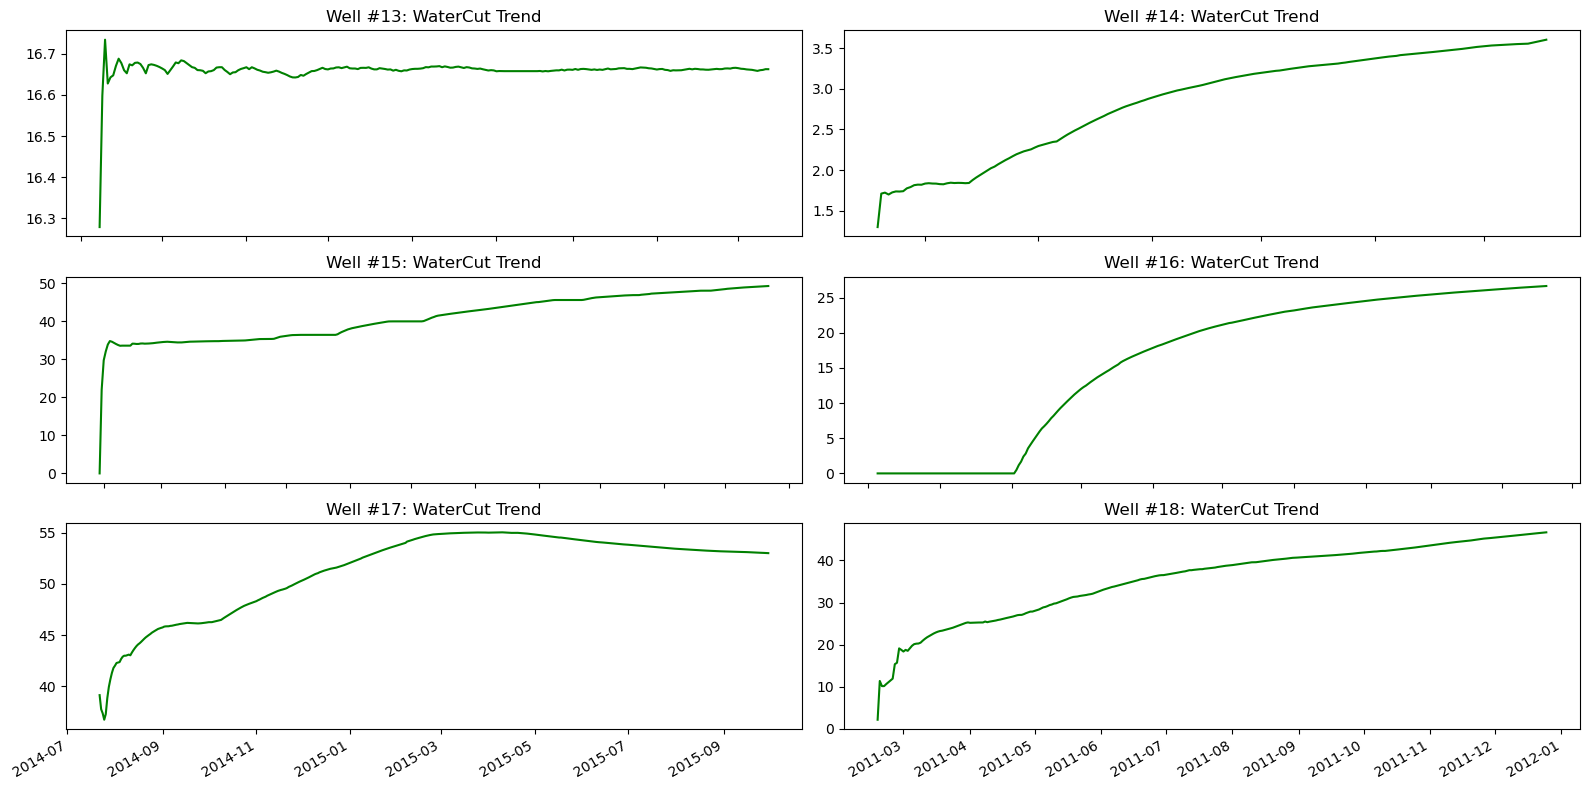

In [55]:
fig2, ax2 = plt.subplots(3,2, figsize=(16, 8))

ax2[0, 0].plot(for_GOR[for_GOR['well_name'] == 'Well_#13']['prod_date'], for_GOR[for_GOR['well_name'] == 'Well_#13']['water_cut'], 'green')
ax2[0, 0].set_title('Well #13: WaterCut Trend')

ax2[0, 1].plot(for_GOR[for_GOR['well_name'] == 'Well_#14']['prod_date'], for_GOR[for_GOR['well_name'] == 'Well_#14']['water_cut'], 'green')
ax2[0, 1].set_title('Well #14: WaterCut Trend')

ax2[1, 0].plot(for_GOR[for_GOR['well_name'] == 'Well_#15']['prod_date'], for_GOR[for_GOR['well_name'] == 'Well_#15']['water_cut'], 'green')
ax2[1, 0].set_title('Well #15: WaterCut Trend')

ax2[1, 1].plot(for_GOR[for_GOR['well_name'] == 'Well_#16']['prod_date'], for_GOR[for_GOR['well_name'] == 'Well_#16']['water_cut'], 'green')
ax2[1, 1].set_title('Well #16: WaterCut Trend')

ax2[2, 0].plot(for_GOR[for_GOR['well_name'] == 'Well_#17']['prod_date'], for_GOR[for_GOR['well_name'] == 'Well_#17']['water_cut'], 'green')
ax2[2, 0].set_title('Well #17: WaterCut Trend')

ax2[2, 1].plot(for_GOR[for_GOR['well_name'] == 'Well_#18']['prod_date'], for_GOR[for_GOR['well_name'] == 'Well_#18']['water_cut'], 'green')
ax2[2, 1].set_title('Well #18: WaterCut Trend')

fig2.autofmt_xdate()

plt.tight_layout()

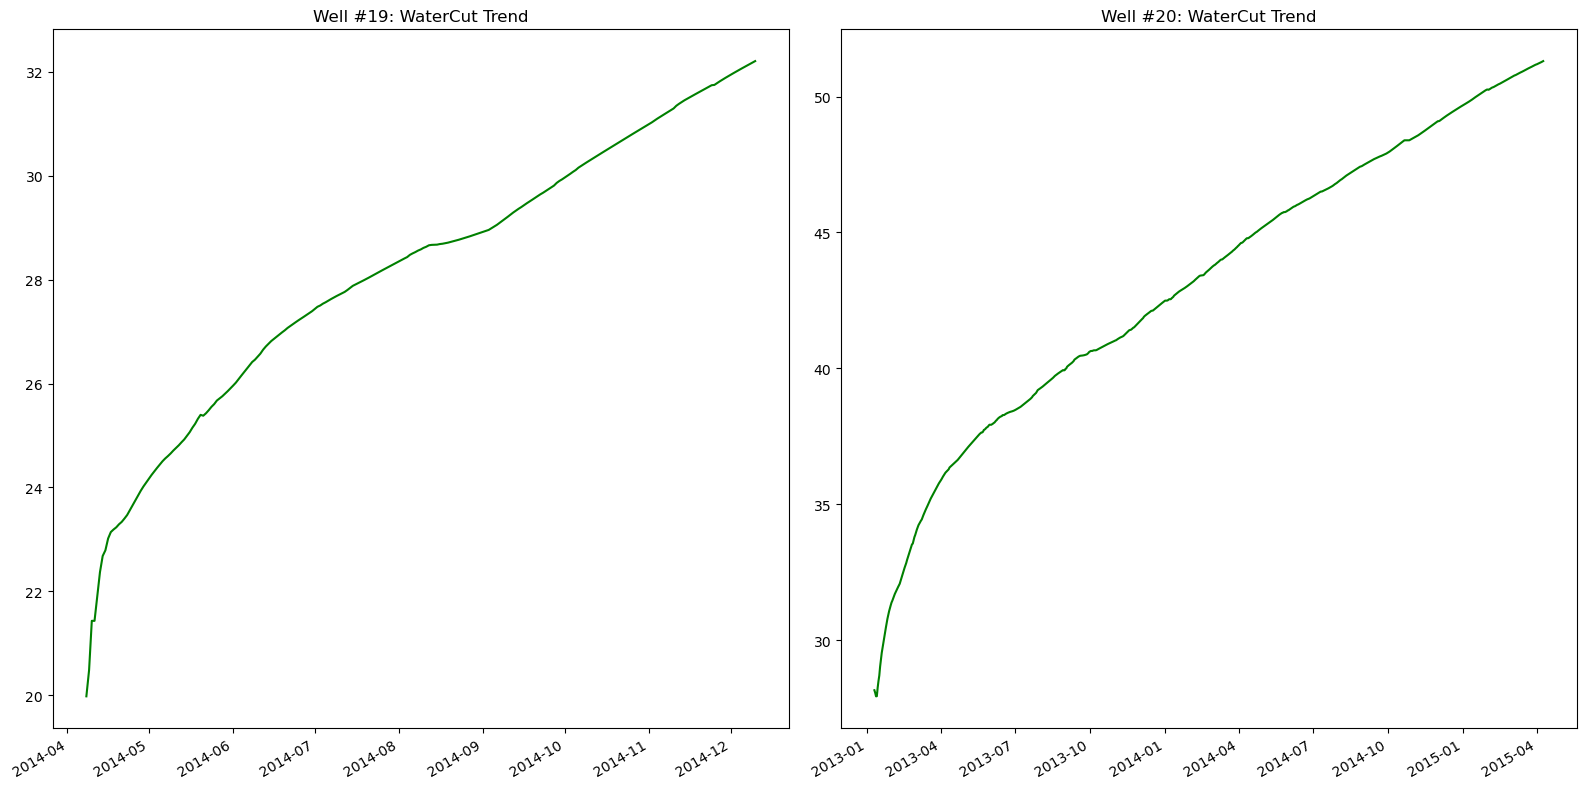

In [56]:
fig2, ax2 = plt.subplots(1,2, figsize=(16, 8))

ax2[0].plot(for_GOR[for_GOR['well_name'] == 'Well_#19']['prod_date'], for_GOR[for_GOR['well_name'] == 'Well_#19']['water_cut'], 'green')
ax2[0].set_title('Well #19: WaterCut Trend')

ax2[1].plot(for_GOR[for_GOR['well_name'] == 'Well_#20']['prod_date'], for_GOR[for_GOR['well_name'] == 'Well_#20']['water_cut'], 'green')
ax2[1].set_title('Well #20: WaterCut Trend')

fig2.autofmt_xdate()

plt.tight_layout()

In [60]:
water_cut = ['Incr', 'Incr', 'Incr', 'Combo', 'Incr',
            'Combo', 'Incr', 'Combo', 'Incr', 'Combo',
            'Incr', 'Incr', 'Combo', 'Incr', 'Combo',
            'Combo', 'Incr','Incr', 'Incr', 'Incr']

In [61]:

# Let's update our DataFrame as usual with the new 'Water cut trend' vector
wellAndReservoirData['Watercut Trend'] = water_cut
actual_well_classifier['Watercut Trend'] = water_cut
actual_well_classifier.head()

,well,Reservoir Name,Reservoir Type,Well Type,Production Type,Formation GOR,Watercut Trend
0,Well_#1,JANI,undersat,GL,Unsteady,Combo,Incr
1,Well_#2,KEMA,undersat,NF,Unsteady,Combo,Incr
2,Well_#3,MAKO,saturated,GL,Steady,aSolGOR,Incr
3,Well_#4,DEPU,saturated,GL,Steady,aSolGOR,Combo
4,Well_#5,MAKO,saturated,NF,Unsteady,aSolGOR,Incr


In [62]:
#['well', 'Reservoir Name', 'Reservoir Type', 'Well Type', 'Production Type', 'GOR Trend', 'Watercut Trend', 'Formation GOR']
actual_well_classifier.drop(columns = 'well', inplace=True)

In [63]:
actual_well_classifier['Well'] = range(1, 21)
actual_well_classifier = actual_well_classifier[['Well', 'Reservoir Name', 'Reservoir Type', 'Well Type', 'Production Type',
       'Formation GOR', 'Watercut Trend']]

In [64]:
actual_well_classifier.head()

,Well,Reservoir Name,Reservoir Type,Well Type,Production Type,Formation GOR,Watercut Trend
0,1,JANI,undersat,GL,Unsteady,Combo,Incr
1,2,KEMA,undersat,NF,Unsteady,Combo,Incr
2,3,MAKO,saturated,GL,Steady,aSolGOR,Incr
3,4,DEPU,saturated,GL,Steady,aSolGOR,Combo
4,5,MAKO,saturated,NF,Unsteady,aSolGOR,Incr


## Task 7
##### Determine from the oil productivity index trend whether it is Flat, Increasing, Decreasing or a Combination of 2 or more trends. You may use average reservoir pressure for the oil productivity index computation

Productivity Index(J) formula is given below:
$$J = \frac{Q}{\bar{P}_R - P_{wf}}$$
where:<br>
$J$ = Productivity Index <br>
$Q$ = Oil flowrate (STB/day) <br>
$\bar{P}_R$ = Reservoir Pressure(psi) <br>
$P_{wf}$ = Bottom hole flowing pressure(psi)

So, we need daily production not cumulative.

In [65]:
wq[0].head()

,prod_date,well,cumulative_oil_prod_stb,daily_oil_prod_stb/d,cumulative_formation_gas_prod_mscf,daily_formation_gas_prod_mscf,cumulative_water_prod_bbl,daily_water_prod_bbl,bottomhole_flowing_pressure_psi
11,2014-02-26,Well_#1,631.0,631.0,636.0,636.0,0.0,0.0,3777.0
12,2014-02-27,Well_#1,1798.0,1167.0,1802.0,1166.0,0.0,0.0,3527.0
13,2014-02-28,Well_#1,3348.0,1550.0,3362.0,1560.0,0.0,0.0,3430.0
14,2014-03-01,Well_#1,4596.0,1248.0,4614.0,1252.0,0.0,0.0,3335.0
15,2014-03-02,Well_#1,5942.0,1346.0,5969.0,1355.0,0.0,0.0,3226.0


In [66]:
wpq = wq.copy()
wpq[0]

,prod_date,well,cumulative_oil_prod_stb,daily_oil_prod_stb/d,cumulative_formation_gas_prod_mscf,daily_formation_gas_prod_mscf,cumulative_water_prod_bbl,daily_water_prod_bbl,bottomhole_flowing_pressure_psi
11,2014-02-26,Well_#1,631.0,631.0,636.0,636.0,0.0,0.0,3777.0
12,2014-02-27,Well_#1,1798.0,1167.0,1802.0,1166.0,0.0,0.0,3527.0
13,2014-02-28,Well_#1,3348.0,1550.0,3362.0,1560.0,0.0,0.0,3430.0
14,2014-03-01,Well_#1,4596.0,1248.0,4614.0,1252.0,0.0,0.0,3335.0
15,2014-03-02,Well_#1,5942.0,1346.0,5969.0,1355.0,0.0,0.0,3226.0
...,...,...,...,...,...,...,...,...,...
199,2014-09-02,Well_#1,100534.0,282.0,104224.0,303.0,37495.0,306.0,2891.0
200,2014-09-03,Well_#1,100820.0,286.0,104532.0,308.0,37797.0,302.0,2871.0
201,2014-09-04,Well_#1,101103.0,283.0,104839.0,307.0,38098.0,301.0,2872.0
202,2014-09-05,Well_#1,101386.0,283.0,105145.0,306.0,38399.0,301.0,2870.0


In [67]:
# Remember that our current average reservoir pressure is stored in 'wellAndReservoirData' column
wellAndReservoirData['current_average_reservoir_pressure_psi'];

In [68]:
vt = []
c = 0
for df in wpq:
    Pr = wellAndReservoirData['current_average_reservoir_pressure_psi'].iloc[c]
    J = df['daily_oil_prod_stb/d'] / (Pr - df['bottomhole_flowing_pressure_psi'])
    #print(J.head())
    wpq[c]['Productivity_index'] = J
    c+=1

In [69]:
wpq[0].head()

,prod_date,well,cumulative_oil_prod_stb,daily_oil_prod_stb/d,cumulative_formation_gas_prod_mscf,daily_formation_gas_prod_mscf,cumulative_water_prod_bbl,daily_water_prod_bbl,bottomhole_flowing_pressure_psi,Productivity_index
11,2014-02-26,Well_#1,631.0,631.0,636.0,636.0,0.0,0.0,3777.0,1.491726
12,2014-02-27,Well_#1,1798.0,1167.0,1802.0,1166.0,0.0,0.0,3527.0,1.734027
13,2014-02-28,Well_#1,3348.0,1550.0,3362.0,1560.0,0.0,0.0,3430.0,2.012987
14,2014-03-01,Well_#1,4596.0,1248.0,4614.0,1252.0,0.0,0.0,3335.0,1.442775
15,2014-03-02,Well_#1,5942.0,1346.0,5969.0,1355.0,0.0,0.0,3226.0,1.381930


In [70]:
# Concatenate the 20 wells
wpq = pd.concat(wpq, axis=0)
wpq.head()

,prod_date,well,cumulative_oil_prod_stb,daily_oil_prod_stb/d,cumulative_formation_gas_prod_mscf,daily_formation_gas_prod_mscf,cumulative_water_prod_bbl,daily_water_prod_bbl,bottomhole_flowing_pressure_psi,Productivity_index
11,2014-02-26,Well_#1,631.0,631.0,636.0,636.0,0.0,0.0,3777.0,1.491726
12,2014-02-27,Well_#1,1798.0,1167.0,1802.0,1166.0,0.0,0.0,3527.0,1.734027
13,2014-02-28,Well_#1,3348.0,1550.0,3362.0,1560.0,0.0,0.0,3430.0,2.012987
14,2014-03-01,Well_#1,4596.0,1248.0,4614.0,1252.0,0.0,0.0,3335.0,1.442775
15,2014-03-02,Well_#1,5942.0,1346.0,5969.0,1355.0,0.0,0.0,3226.0,1.381930


In [71]:
wq = wpq

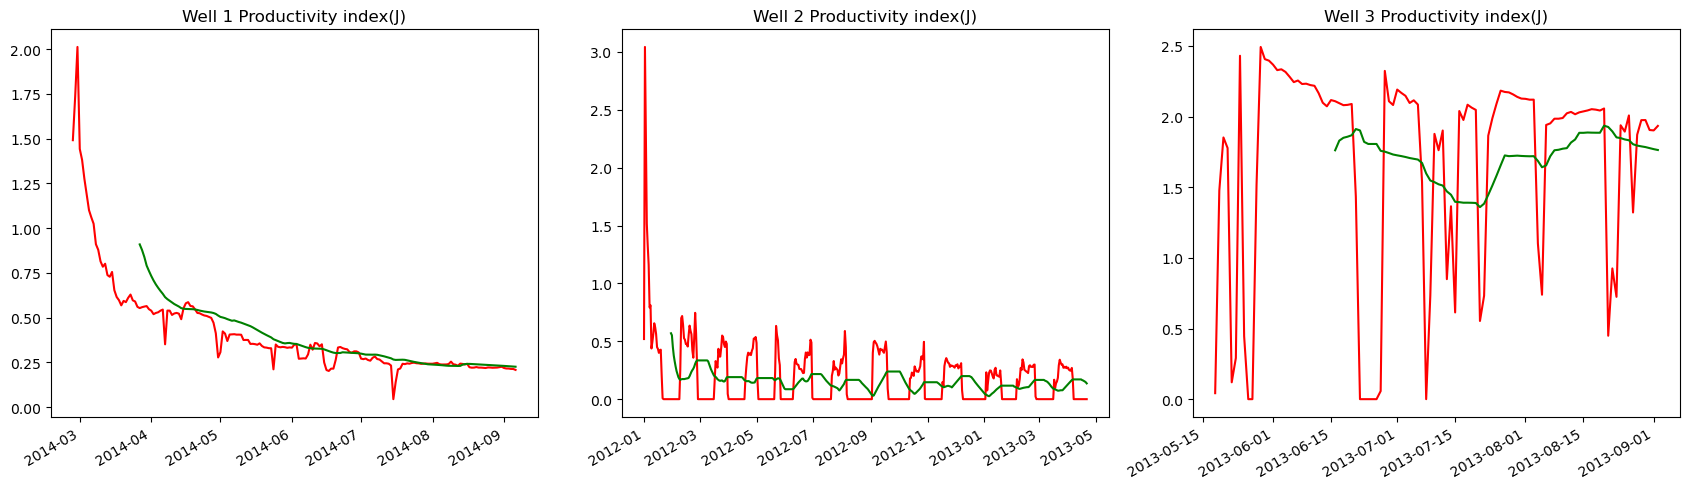

In [69]:
fig3, ax3 = plt.subplots(1, 3, figsize= (17, 5))

ax3[0].plot(wq[wq['well'] == 'Well_#1']['prod_date'], wq[wq['well'] == 'Well_#1']['Productivity_index'], 'r')
ax3[0].plot(wq[wq['well'] == 'Well_#1']['prod_date'].iloc[6:], wq[wq['well'] == 'Well_#1']['Productivity_index'].rolling(window=30).mean().iloc[6:], 'g')
ax3[0].set_title('Well 1 Productivity index(J)')
#ax3[0].xticks(rotation= 45, ha='right')

ax3[1].plot(wq[wq['well'] == 'Well_#2']['prod_date'], wq[wq['well'] == 'Well_#2']['Productivity_index'], 'r')
ax3[1].plot(wq[wq['well'] == 'Well_#2']['prod_date'].iloc[6:], wq[wq['well'] == 'Well_#2']['Productivity_index'].rolling(window=30).mean().iloc[6:], 'g')
ax3[1].set_title('Well 2 Productivity index(J)')

ax3[2].plot(wq[wq['well'] == 'Well_#3']['prod_date'], wq[wq['well'] == 'Well_#3']['Productivity_index'], 'r')
ax3[2].plot(wq[wq['well'] == 'Well_#3']['prod_date'].iloc[6:], wq[wq['well'] == 'Well_#3']['Productivity_index'].rolling(window=30).mean().iloc[6:], 'g')
ax3[2].set_title('Well 3 Productivity index(J)')

fig3.autofmt_xdate()
plt.tight_layout()

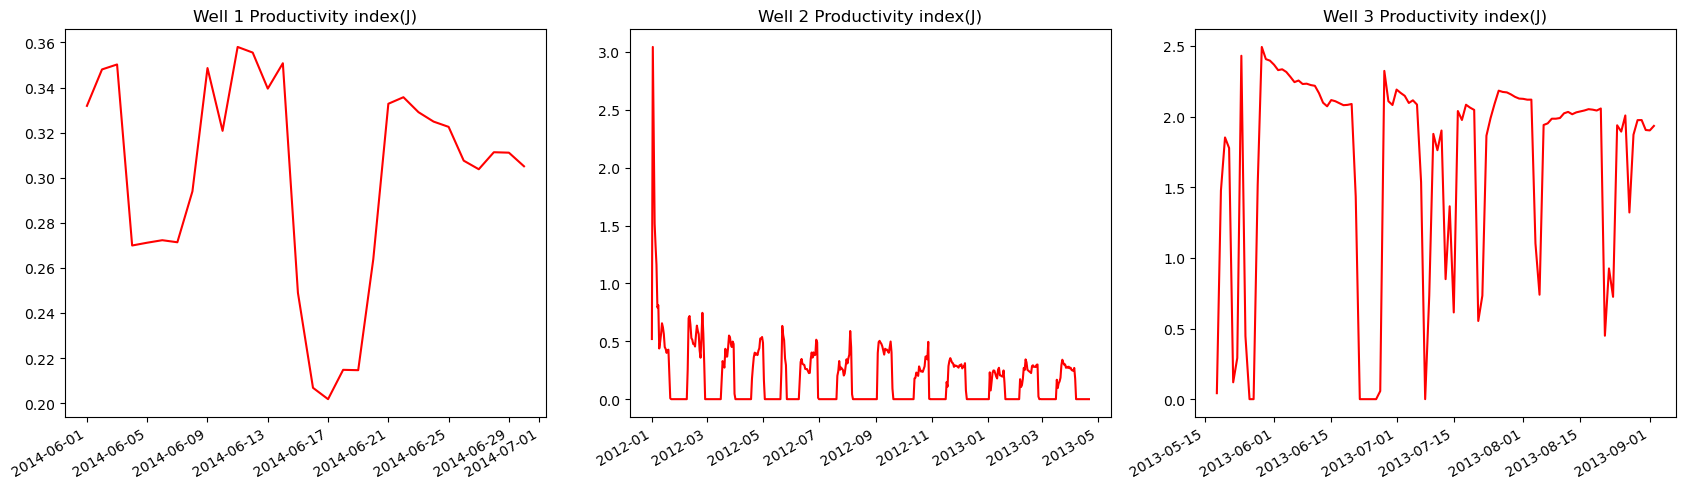

In [70]:
fig3, ax3 = plt.subplots(1, 3, figsize= (17, 5))

ax3[0].plot(wq[(wq['well'] == 'Well_#1') & (wq['prod_date'].between('2014-06-01', '2014-06-30'))]['prod_date'], wq[(wq['well'] == 'Well_#1') & (wq['prod_date'].between('2014-06-01', '2014-06-30'))]['Productivity_index'], 'r')
ax3[0].set_title('Well 1 Productivity index(J)')
#ax3[0].xticks(rotation= 45, ha='right')

ax3[1].plot(wq[wq['well'] == 'Well_#2']['prod_date'], wq[wq['well'] == 'Well_#2']['Productivity_index'], 'r')
ax3[1].set_title('Well 2 Productivity index(J)')

ax3[2].plot(wq[wq['well'] == 'Well_#3']['prod_date'], wq[wq['well'] == 'Well_#3']['Productivity_index'], 'r')
ax3[2].set_title('Well 3 Productivity index(J)')

fig3.autofmt_xdate()
plt.tight_layout()

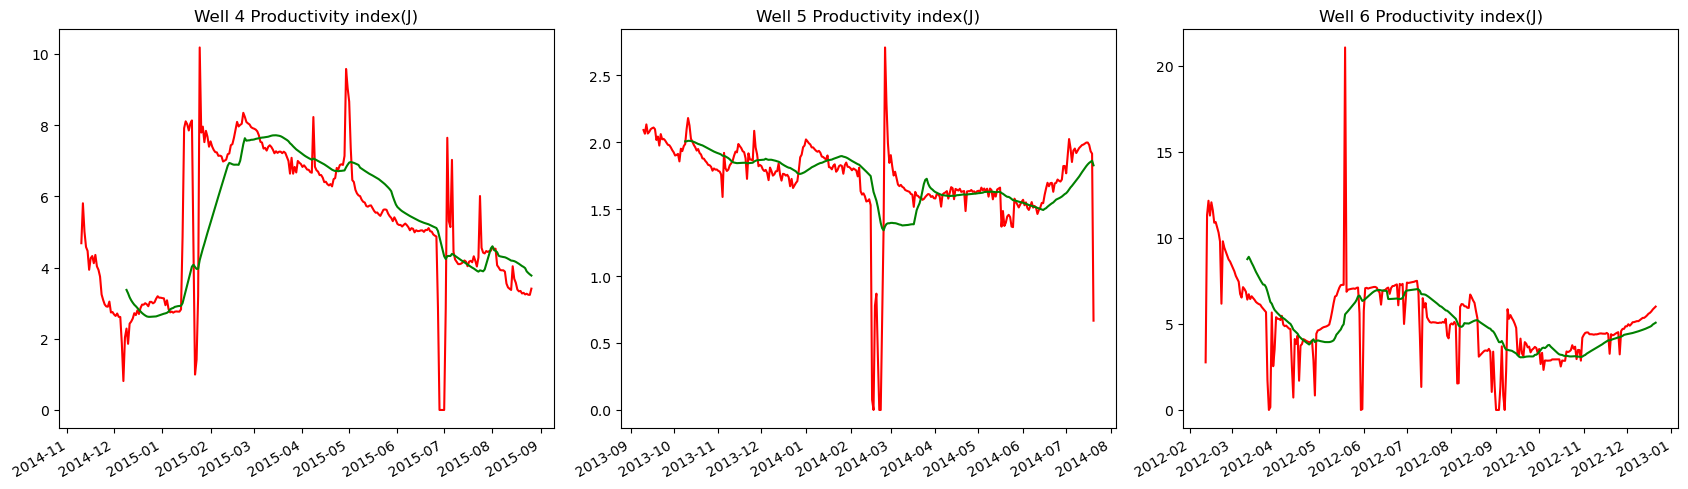

In [71]:
fig3, ax3 = plt.subplots(1, 3, figsize= (17, 5))

ax3[0].plot(wq[wq['well'] == 'Well_#4']['prod_date'], wq[wq['well'] == 'Well_#4']['Productivity_index'], 'r')
ax3[0].plot(wq[wq['well'] == 'Well_#4']['prod_date'].iloc[6:], wq[wq['well'] == 'Well_#4']['Productivity_index'].rolling(window=30).mean().iloc[6:], 'g')
ax3[0].set_title('Well 4 Productivity index(J)')
#ax3[0].xticks(rotation= 45, ha='right')

ax3[1].plot(wq[wq['well'] == 'Well_#5']['prod_date'], wq[wq['well'] == 'Well_#5']['Productivity_index'], 'r')
ax3[1].plot(wq[wq['well'] == 'Well_#5']['prod_date'].iloc[6:], wq[wq['well'] == 'Well_#5']['Productivity_index'].rolling(window=30).mean().iloc[6:], 'g')
ax3[1].set_title('Well 5 Productivity index(J)')

ax3[2].plot(wq[wq['well'] == 'Well_#6']['prod_date'], wq[wq['well'] == 'Well_#6']['Productivity_index'], 'r')
ax3[2].plot(wq[wq['well'] == 'Well_#6']['prod_date'].iloc[6:], wq[wq['well'] == 'Well_#6']['Productivity_index'].rolling(window=30).mean().iloc[6:], 'g')
ax3[2].set_title('Well 6 Productivity index(J)')

fig3.autofmt_xdate()
plt.tight_layout()

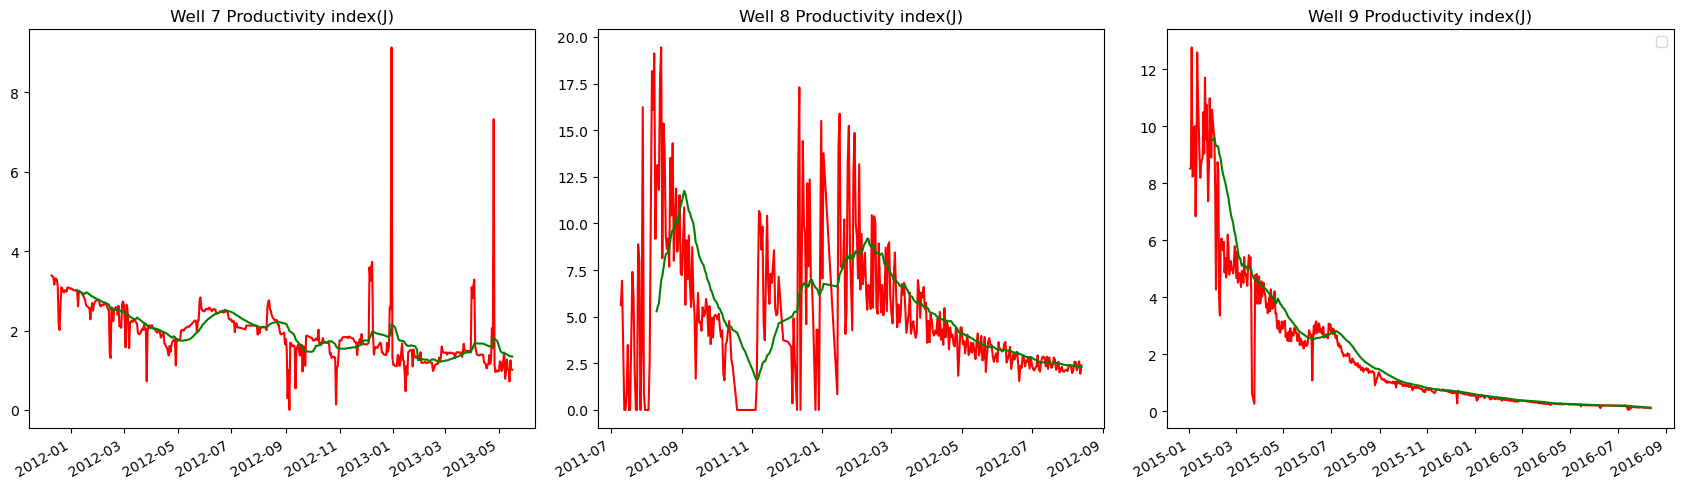

In [72]:
fig3, ax3 = plt.subplots(1, 3, figsize= (17, 5))

ax3[0].plot(wq[wq['well'] == 'Well_#7']['prod_date'], wq[wq['well'] == 'Well_#7']['Productivity_index'], 'r')
ax3[0].plot(wq[wq['well'] == 'Well_#7']['prod_date'].iloc[6:], wq[wq['well'] == 'Well_#7']['Productivity_index'].rolling(window=30).mean().iloc[6:], 'g')
ax3[0].set_title('Well 7 Productivity index(J)')
#ax3[0].xticks(rotation= 45, ha='right')

ax3[1].plot(wq[wq['well'] == 'Well_#8']['prod_date'], wq[wq['well'] == 'Well_#8']['Productivity_index'], 'r')
ax3[1].plot(wq[wq['well'] == 'Well_#8']['prod_date'].iloc[6:], wq[wq['well'] == 'Well_#8']['Productivity_index'].rolling(window=30).mean().iloc[6:], 'g')
ax3[1].set_title('Well 8 Productivity index(J)')

ax3[2].plot(wq[wq['well'] == 'Well_#9']['prod_date'], wq[wq['well'] == 'Well_#9']['Productivity_index'], 'r')
ax3[2].plot(wq[wq['well'] == 'Well_#9']['prod_date'].iloc[6:], wq[wq['well'] == 'Well_#9']['Productivity_index'].rolling(window=30).mean().iloc[6:], 'g')
ax3[2].set_title('Well 9 Productivity index(J)')

plt.legend()
fig3.autofmt_xdate()
plt.tight_layout()

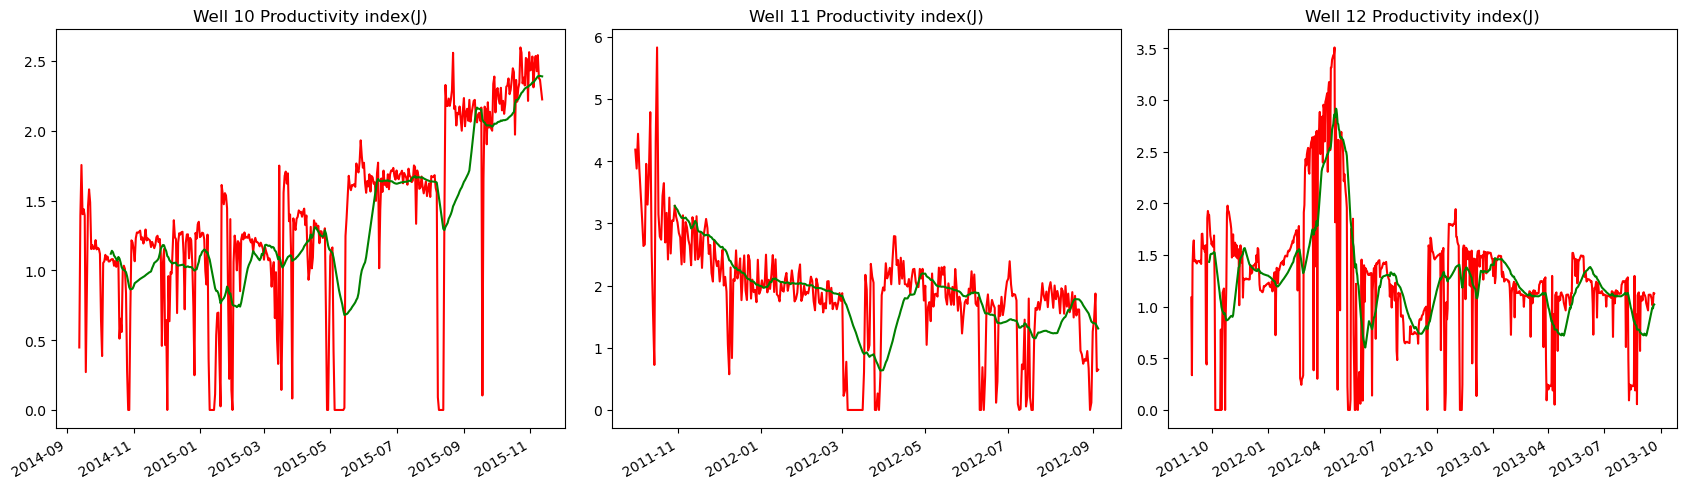

In [73]:
fig3, ax3 = plt.subplots(1, 3, figsize= (17, 5))

ax3[0].plot(wq[wq['well'] == 'Well_#10']['prod_date'], wq[wq['well'] == 'Well_#10']['Productivity_index'], 'r')
ax3[0].plot(wq[wq['well'] == 'Well_#10']['prod_date'].iloc[6:], wq[wq['well'] == 'Well_#10']['Productivity_index'].rolling(window=30).mean().iloc[6:], 'g')
ax3[0].set_title('Well 10 Productivity index(J)')
#ax3[0].xticks(rotation= 45, ha='right')

ax3[1].plot(wq[wq['well'] == 'Well_#11']['prod_date'], wq[wq['well'] == 'Well_#11']['Productivity_index'], 'r')
ax3[1].plot(wq[wq['well'] == 'Well_#11']['prod_date'].iloc[6:], wq[wq['well'] == 'Well_#11']['Productivity_index'].rolling(window=30).mean().iloc[6:], 'g')
ax3[1].set_title('Well 11 Productivity index(J)')

ax3[2].plot(wq[wq['well'] == 'Well_#12']['prod_date'], wq[wq['well'] == 'Well_#12']['Productivity_index'], 'r')
ax3[2].plot(wq[wq['well'] == 'Well_#12']['prod_date'].iloc[6:], wq[wq['well'] == 'Well_#12']['Productivity_index'].rolling(window=30).mean().iloc[6:], 'g')
ax3[2].set_title('Well 12 Productivity index(J)')

fig3.autofmt_xdate()
plt.tight_layout()

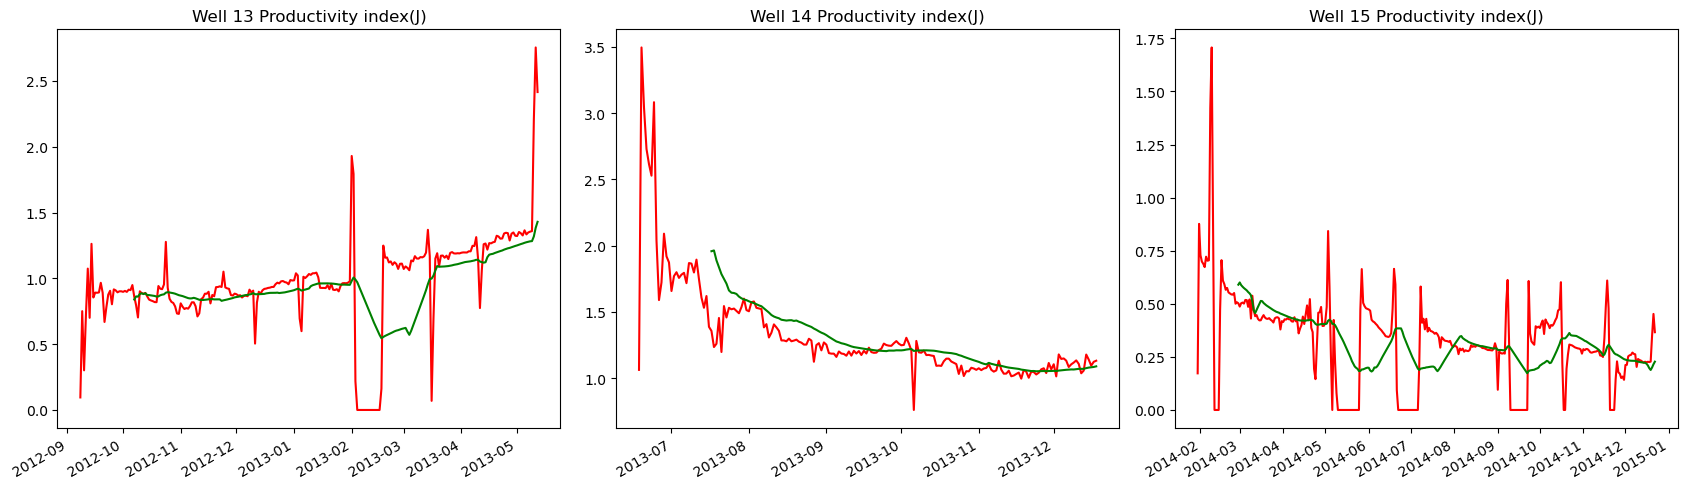

In [74]:
fig3, ax3 = plt.subplots(1, 3, figsize= (17, 5))

ax3[0].plot(wq[wq['well'] == 'Well_#13']['prod_date'], wq[wq['well'] == 'Well_#13']['Productivity_index'], 'r')
ax3[0].plot(wq[wq['well'] == 'Well_#13']['prod_date'].iloc[6:], wq[wq['well'] == 'Well_#13']['Productivity_index'].rolling(window=30).mean().iloc[6:], 'g')
ax3[0].set_title('Well 13 Productivity index(J)')
#ax3[0].xticks(rotation= 45, ha='right')

ax3[1].plot(wq[wq['well'] == 'Well_#14']['prod_date'], wq[wq['well'] == 'Well_#14']['Productivity_index'], 'r')
ax3[1].plot(wq[wq['well'] == 'Well_#14']['prod_date'].iloc[6:], wq[wq['well'] == 'Well_#14']['Productivity_index'].rolling(window=30).mean().iloc[6:], 'g')
ax3[1].set_title('Well 14 Productivity index(J)')

ax3[2].plot(wq[wq['well'] == 'Well_#15']['prod_date'], wq[wq['well'] == 'Well_#15']['Productivity_index'], 'r')
ax3[2].plot(wq[wq['well'] == 'Well_#15']['prod_date'].iloc[6:], wq[wq['well'] == 'Well_#15']['Productivity_index'].rolling(window=30).mean().iloc[6:], 'g')
ax3[2].set_title('Well 15 Productivity index(J)')

fig3.autofmt_xdate()
plt.tight_layout()

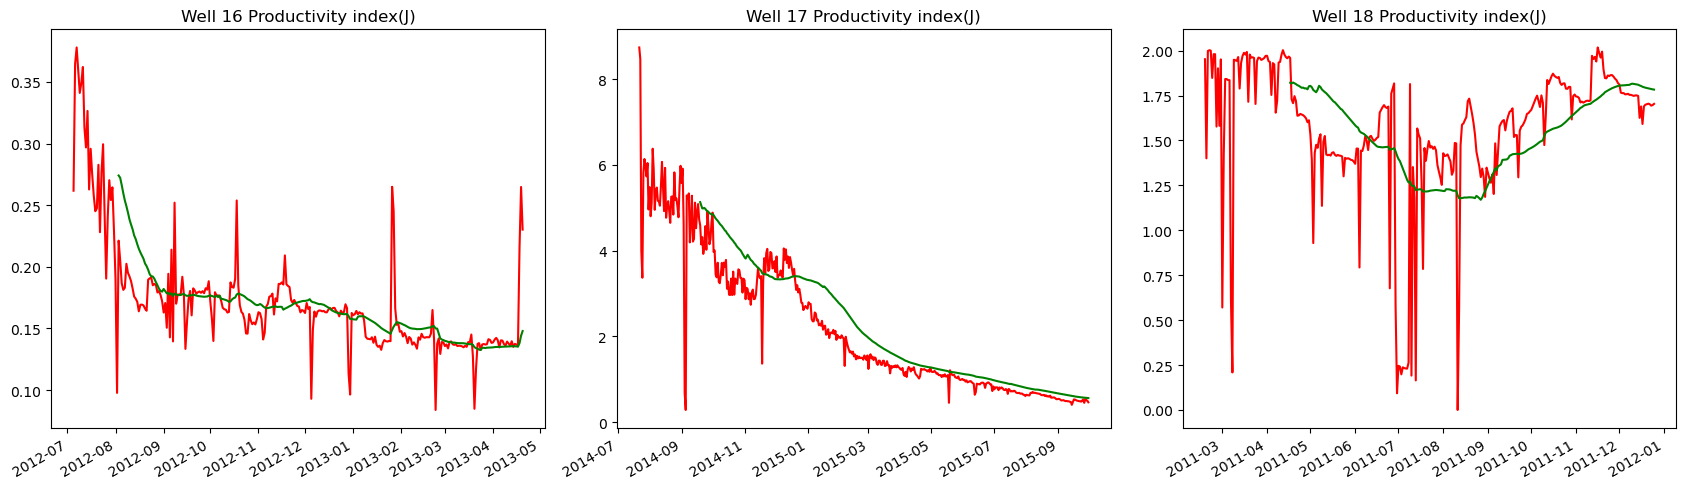

In [75]:
fig3, ax3 = plt.subplots(1, 3, figsize= (17, 5))

ax3[0].plot(wq[wq['well'] == 'Well_#16']['prod_date'], wq[wq['well'] == 'Well_#16']['Productivity_index'], 'r')
ax3[0].plot(wq[wq['well'] == 'Well_#16']['prod_date'].iloc[6:], wq[wq['well'] == 'Well_#16']['Productivity_index'].rolling(window=30).mean().iloc[6:], 'g')
ax3[0].set_title('Well 16 Productivity index(J)')
#ax3[0].xticks(rotation= 45, ha='right')

ax3[1].plot(wq[wq['well'] == 'Well_#17']['prod_date'], wq[wq['well'] == 'Well_#17']['Productivity_index'], 'r')
ax3[1].plot(wq[wq['well'] == 'Well_#17']['prod_date'].iloc[6:], wq[wq['well'] == 'Well_#17']['Productivity_index'].rolling(window=60).mean().iloc[6:], 'g')
ax3[1].set_title('Well 17 Productivity index(J)')

ax3[2].plot(wq[wq['well'] == 'Well_#18']['prod_date'], wq[wq['well'] == 'Well_#18']['Productivity_index'], 'r')
ax3[2].plot(wq[wq['well'] == 'Well_#18']['prod_date'].iloc[6:], wq[wq['well'] == 'Well_#18']['Productivity_index'].rolling(window=60).mean().iloc[6:], 'g')
ax3[2].set_title('Well 18 Productivity index(J)')

fig3.autofmt_xdate()
plt.tight_layout()

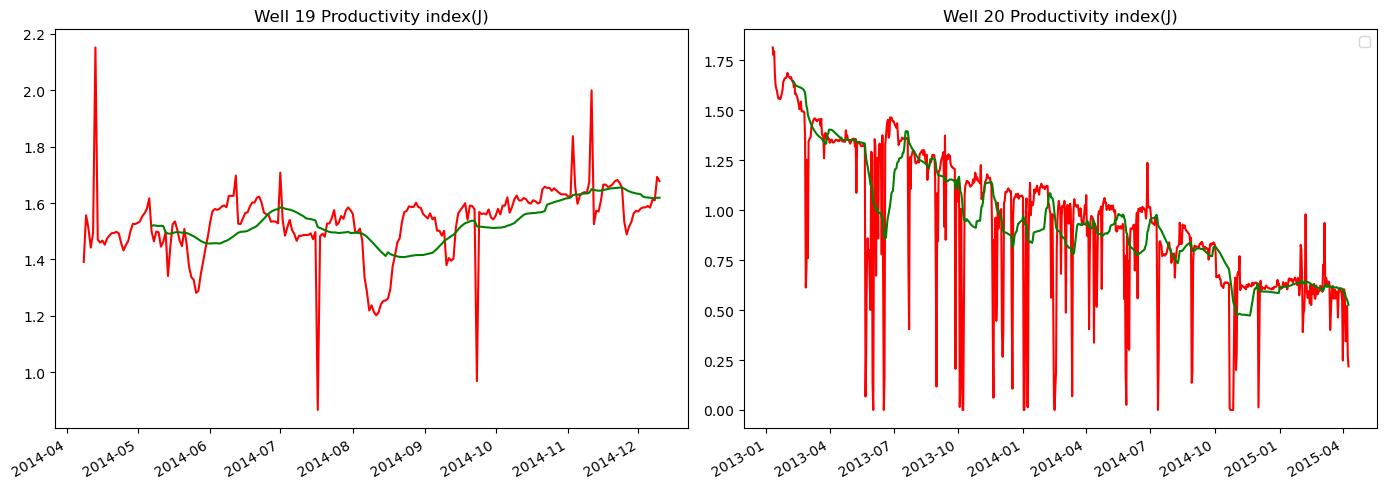

In [76]:
fig3, ax3 = plt.subplots(1, 2, figsize= (14, 5))

ax3[0].plot(wq[wq['well'] == 'Well_#19']['prod_date'], wq[wq['well'] == 'Well_#19']['Productivity_index'], 'r', label = 'main')
ax3[0].plot(wq[wq['well'] == 'Well_#19']['prod_date'].iloc[6:], wq[wq['well'] == 'Well_#19']['Productivity_index'].rolling(window=30).mean().iloc[6:], 'g', label = 'ma')
ax3[0].set_title('Well 19 Productivity index(J)')
plt.legend()

ax3[1].plot(wq[wq['well'] == 'Well_#20']['prod_date'], wq[wq['well'] == 'Well_#20']['Productivity_index'], 'r')
ax3[1].plot(wq[wq['well'] == 'Well_#20']['prod_date'].iloc[29:], wq[wq['well'] == 'Well_#20']['Productivity_index'].rolling(window=30).mean().iloc[29:], 'g')
ax3[1].set_title('Well 20 Productivity index(J)')

plt.legend()
fig3.autofmt_xdate()
plt.tight_layout()

After a thorough analysis of the productivity trend and careful visualization analysis, here is the obtained classification

In [72]:
productivity_index_curve = ['Decr', 'Flat', 'Flat', 'Combo',
      'Flat', 'Combo', 'Flat', 'Combo',
      'Decr', 'Incr', 'Decr', 'Combo',
      'Incr', 'Decr', 'Flat', 'Combo',
      'Decr', 'Combo', 'Incr', 'Decr'
     ]

In [73]:
# Let's update our DataFrame as usual with the new 'Productivity index trend' vector
wellAndReservoirData['Oil Productivity Index'] = productivity_index_curve
actual_well_classifier['Oil Productivity Index'] = productivity_index_curve
actual_well_classifier.head()

,Well,Reservoir Name,Reservoir Type,Well Type,Production Type,Formation GOR,Watercut Trend,Oil Productivity Index
0,1,JANI,undersat,GL,Unsteady,Combo,Incr,Decr
1,2,KEMA,undersat,NF,Unsteady,Combo,Incr,Flat
2,3,MAKO,saturated,GL,Steady,aSolGOR,Incr,Flat
3,4,DEPU,saturated,GL,Steady,aSolGOR,Combo,Combo
4,5,MAKO,saturated,NF,Unsteady,aSolGOR,Incr,Flat


In [74]:
# Calculate the total oil production in stb from each reservoir
tot_prod = []
for well in well_res:
    tot_prod.append(well['daily_oil_prod_stb/d'].sum())
tot_prod

[101659.0,
 74524.0,
 97536.0,
 385817.0,
 227930.0,
 1129301.0,
 589385.0,
 298072.0,
 247997.0,
 116279.0,
 167307.0,
 578776.0,
 190635.0,
 142421.0,
 118382.0,
 67679.0,
 280021.0,
 205968.0,
 120921.0,
 498126.0]

In [75]:
wellAndReservoirData['Total Oil Produced(stb)'] = tot_prod
actual_well_classifier['Total Oil Produced(stb)'] = tot_prod
#del wellAndReservoirData['Total Oil Produced']
#del actual_well_classifier['Total Oil Produced']


In [76]:
actual_well_classifier

,Well,Reservoir Name,Reservoir Type,Well Type,Production Type,Formation GOR,Watercut Trend,Oil Productivity Index,Total Oil Produced(stb)
0,1,JANI,undersat,GL,Unsteady,Combo,Incr,Decr,101659.0
1,2,KEMA,undersat,NF,Unsteady,Combo,Incr,Flat,74524.0
2,3,MAKO,saturated,GL,Steady,aSolGOR,Incr,Flat,97536.0
3,4,DEPU,saturated,GL,Steady,aSolGOR,Combo,Combo,385817.0
4,5,MAKO,saturated,NF,Unsteady,aSolGOR,Incr,Flat,227930.0
5,6,KEMA,undersat,NF,Steady,aSolGOR,Combo,Combo,1129301.0
6,7,KEMA,undersat,GL,Steady,aSolGOR,Incr,Flat,589385.0
7,8,ACHI,undersat,GL,Steady,aSolGOR,Combo,Combo,298072.0
8,9,DEPU,saturated,GL,Steady,bSolGOR,Incr,Decr,247997.0
9,10,JANI,undersat,NF,Unsteady,aSolGOR,Combo,Incr,116279.0


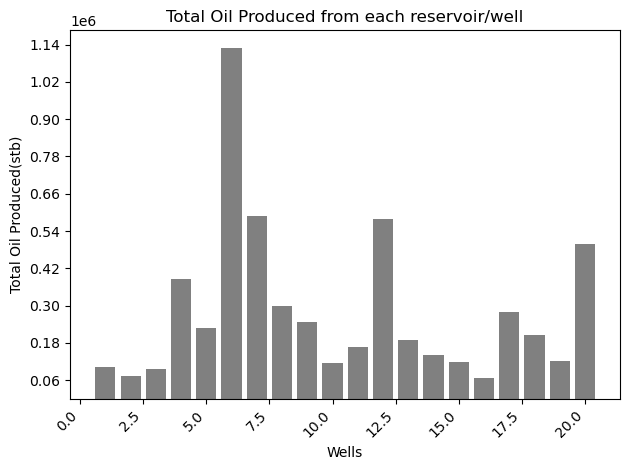

In [78]:
plt.bar(actual_well_classifier['Well'], actual_well_classifier['Total Oil Produced(stb)'], color= 'grey')
plt.xticks(rotation= 45, ha= 'right')
plt.yticks(range(60000, 1200000, 120000))
plt.xlabel('Wells')
plt.ylabel('Total Oil Produced(stb)')
plt.title('Total Oil Produced from each reservoir/well')
plt.tight_layout()

In [79]:
wellAndReservoirData.head()

,well,maximum_BHFP,Reservoir Name,Pressure Difference,All Pressure differential,initial_reservoir_pressure_psi,bubble_point_pressure_psi,current_average_reservoir_pressure_psi,solution_gas-oil-ratio_scf/bbl,formation_volume_factor_rb/stb,...,average_bottomhole_flowing_pressure,average_downhole_temperature,average_well_head_pressure,average_well_head_temperature,average_choke_size,Formation GOR,Production Type,Watercut Trend,Oil Productivity Index,Total Oil Produced(stb)
0,Well_#1,4096.0,JANI,104.0,"[-1396.0, -196.0, -1096.0, -1696.0, 104.0]",4500.0,4300.0,4200.0,1000.0,1.30,...,2943.250000,207.562745,711.214985,107.716490,45.234272,Combo,Unsteady,Incr,Decr,101659.0
1,Well_#2,3735.0,KEMA,165.0,"[-1035.0, 165.0, -735.0, -1335.0, 465.0]",4200.0,4000.0,3900.0,600.0,1.45,...,3164.121593,202.146285,861.152174,99.672191,24.606748,Combo,Unsteady,Incr,Flat,74524.0
2,Well_#3,2985.0,MAKO,15.0,"[-285.0, 915.0, 15.0, -585.0, 1215.0]",3500.0,3500.0,3000.0,500.0,1.15,...,2180.951613,133.074984,789.801290,59.222952,7.436841,aSolGOR,Steady,Incr,Flat,97536.0
3,Well_#4,2340.0,DEPU,60.0,"[360.0, 1560.0, 660.0, 60.0, 1860.0]",2800.0,2800.0,2400.0,1200.0,1.37,...,2132.813793,148.682072,647.913186,87.516566,21.905611,aSolGOR,Steady,Combo,Combo,385817.0
4,Well_#5,2933.0,MAKO,67.0,"[-233.0, 967.0, 67.0, -533.0, 1267.0]",3500.0,3500.0,3000.0,500.0,1.15,...,2592.764331,158.223911,425.250344,80.306366,96.096684,aSolGOR,Unsteady,Incr,Flat,227930.0


In [67]:
#actual_well_classifier.to_csv('Innovisors_DSEATS_Africa_2025_Classification.csv', index='ignore')

In [41]:
def averages(column):
    '''
    Calculate the average of several subsets of any numerical well_data column

    Argument: column -- any numerical column 
    Output: avg -- averages of the subsets
    '''
    avg = []
    for i in range(1, 21):
        avg.append(well_data[well_data['well_name'] == f'Well_#{i}'][column].mean())
    return avg 

In [80]:
avg_bottomhole_flowing_press = averages('bottomhole_flowing_pressure_psi')
wellAndReservoirData['average_bottomhole_flowing_pressure'] = avg_bottomhole_flowing_press

avg_downhole_temperature = averages('downhole_temperature_deg_f')
wellAndReservoirData['average_downhole_temperature'] = avg_downhole_temperature

avg_well_head_pressure = averages('well_head_pressure_psi')
wellAndReservoirData['average_well_head_pressure'] = avg_well_head_pressure

avg_well_head_temperature = averages('well_head_temperature_deg_f')
wellAndReservoirData['average_well_head_temperature'] = avg_well_head_temperature

avg_choke_size = averages('choke_size_%')
wellAndReservoirData['average_choke_size'] = avg_choke_size

wellAndReservoirData.head(3)

,well,maximum_BHFP,Reservoir Name,Pressure Difference,All Pressure differential,initial_reservoir_pressure_psi,bubble_point_pressure_psi,current_average_reservoir_pressure_psi,solution_gas-oil-ratio_scf/bbl,formation_volume_factor_rb/stb,...,average_bottomhole_flowing_pressure,average_downhole_temperature,average_well_head_pressure,average_well_head_temperature,average_choke_size,Formation GOR,Production Type,Watercut Trend,Oil Productivity Index,Total Oil Produced(stb)
0,Well_#1,4096.0,JANI,104.0,"[-1396.0, -196.0, -1096.0, -1696.0, 104.0]",4500.0,4300.0,4200.0,1000.0,1.30,...,2943.250000,207.562745,711.214985,107.716490,45.234272,Combo,Unsteady,Incr,Decr,101659.0
1,Well_#2,3735.0,KEMA,165.0,"[-1035.0, 165.0, -735.0, -1335.0, 465.0]",4200.0,4000.0,3900.0,600.0,1.45,...,3164.121593,202.146285,861.152174,99.672191,24.606748,Combo,Unsteady,Incr,Flat,74524.0
2,Well_#3,2985.0,MAKO,15.0,"[-285.0, 915.0, 15.0, -585.0, 1215.0]",3500.0,3500.0,3000.0,500.0,1.15,...,2180.951613,133.074984,789.801290,59.222952,7.436841,aSolGOR,Steady,Incr,Flat,97536.0


In [81]:
wellAndReservoirData.columns

Index(['well', 'maximum_BHFP', 'Reservoir Name', 'Pressure Difference',
       'All Pressure differential', 'initial_reservoir_pressure_psi',
       'bubble_point_pressure_psi', 'current_average_reservoir_pressure_psi',
       'solution_gas-oil-ratio_scf/bbl', 'formation_volume_factor_rb/stb',
       'Reservoir Type', 'Well Type', 'average_bottomhole_flowing_pressure',
       'average_downhole_temperature', 'average_well_head_pressure',
       'average_well_head_temperature', 'average_choke_size', 'Formation GOR',
       'Production Type', 'Watercut Trend', 'Oil Productivity Index',
       'Total Oil Produced(stb)'],
      dtype='object')

In [82]:
features = wellAndReservoirData[['well',
                                 'initial_reservoir_pressure_psi', 
                                 'bubble_point_pressure_psi', 
                                 'current_average_reservoir_pressure_psi', 
                                 'solution_gas-oil-ratio_scf/bbl',
                                 'average_bottomhole_flowing_pressure', 
                                 'average_downhole_temperature', 
                                 'average_well_head_pressure', 
                                 'average_well_head_temperature', 
                                 'average_choke_size']]

In [83]:
features.head()

,well,initial_reservoir_pressure_psi,bubble_point_pressure_psi,current_average_reservoir_pressure_psi,solution_gas-oil-ratio_scf/bbl,average_bottomhole_flowing_pressure,average_downhole_temperature,average_well_head_pressure,average_well_head_temperature,average_choke_size
0,Well_#1,4500.0,4300.0,4200.0,1000.0,2943.250000,207.562745,711.214985,107.716490,45.234272
1,Well_#2,4200.0,4000.0,3900.0,600.0,3164.121593,202.146285,861.152174,99.672191,24.606748
2,Well_#3,3500.0,3500.0,3000.0,500.0,2180.951613,133.074984,789.801290,59.222952,7.436841
3,Well_#4,2800.0,2800.0,2400.0,1200.0,2132.813793,148.682072,647.913186,87.516566,21.905611
4,Well_#5,3500.0,3500.0,3000.0,500.0,2592.764331,158.223911,425.250344,80.306366,96.096684


In [84]:
targets = wellAndReservoirData[['well',
                                'Reservoir Name',
                                'Reservoir Type', 
                                'Well Type', 
                                'Production Type', 
                                'Formation GOR',
                                'Watercut Trend', 
                                'Oil Productivity Index']]

In [85]:
targets.head()

,well,Reservoir Name,Reservoir Type,Well Type,Production Type,Formation GOR,Watercut Trend,Oil Productivity Index
0,Well_#1,JANI,undersat,GL,Unsteady,Combo,Incr,Decr
1,Well_#2,KEMA,undersat,NF,Unsteady,Combo,Incr,Flat
2,Well_#3,MAKO,saturated,GL,Steady,aSolGOR,Incr,Flat
3,Well_#4,DEPU,saturated,GL,Steady,aSolGOR,Combo,Combo
4,Well_#5,MAKO,saturated,NF,Unsteady,aSolGOR,Incr,Flat


## Machine Learning Phase

### Feature Engineering

In [86]:
feature1 = features.copy()
feature1['Reservoir Type'] = targets['Reservoir Type']
feature1.head()

,well,initial_reservoir_pressure_psi,bubble_point_pressure_psi,current_average_reservoir_pressure_psi,solution_gas-oil-ratio_scf/bbl,average_bottomhole_flowing_pressure,average_downhole_temperature,average_well_head_pressure,average_well_head_temperature,average_choke_size,Reservoir Type
0,Well_#1,4500.0,4300.0,4200.0,1000.0,2943.250000,207.562745,711.214985,107.716490,45.234272,undersat
1,Well_#2,4200.0,4000.0,3900.0,600.0,3164.121593,202.146285,861.152174,99.672191,24.606748,undersat
2,Well_#3,3500.0,3500.0,3000.0,500.0,2180.951613,133.074984,789.801290,59.222952,7.436841,saturated
3,Well_#4,2800.0,2800.0,2400.0,1200.0,2132.813793,148.682072,647.913186,87.516566,21.905611,saturated
4,Well_#5,3500.0,3500.0,3000.0,500.0,2592.764331,158.223911,425.250344,80.306366,96.096684,saturated


In [87]:
feature1.columns

Index(['well', 'initial_reservoir_pressure_psi', 'bubble_point_pressure_psi',
       'current_average_reservoir_pressure_psi',
       'solution_gas-oil-ratio_scf/bbl', 'average_bottomhole_flowing_pressure',
       'average_downhole_temperature', 'average_well_head_pressure',
       'average_well_head_temperature', 'average_choke_size',
       'Reservoir Type'],
      dtype='object')

In [67]:
Numerical = ['initial_reservoir_pressure_psi', 'bubble_point_pressure_psi',
             'current_average_reservoir_pressure_psi',
             'solution_gas-oil-ratio_scf/bbl', 'average_bottomhole_flowing_pressure',
             'average_downhole_temperature', 'average_well_head_pressure',
             'average_well_head_temperature', 'average_choke_size']

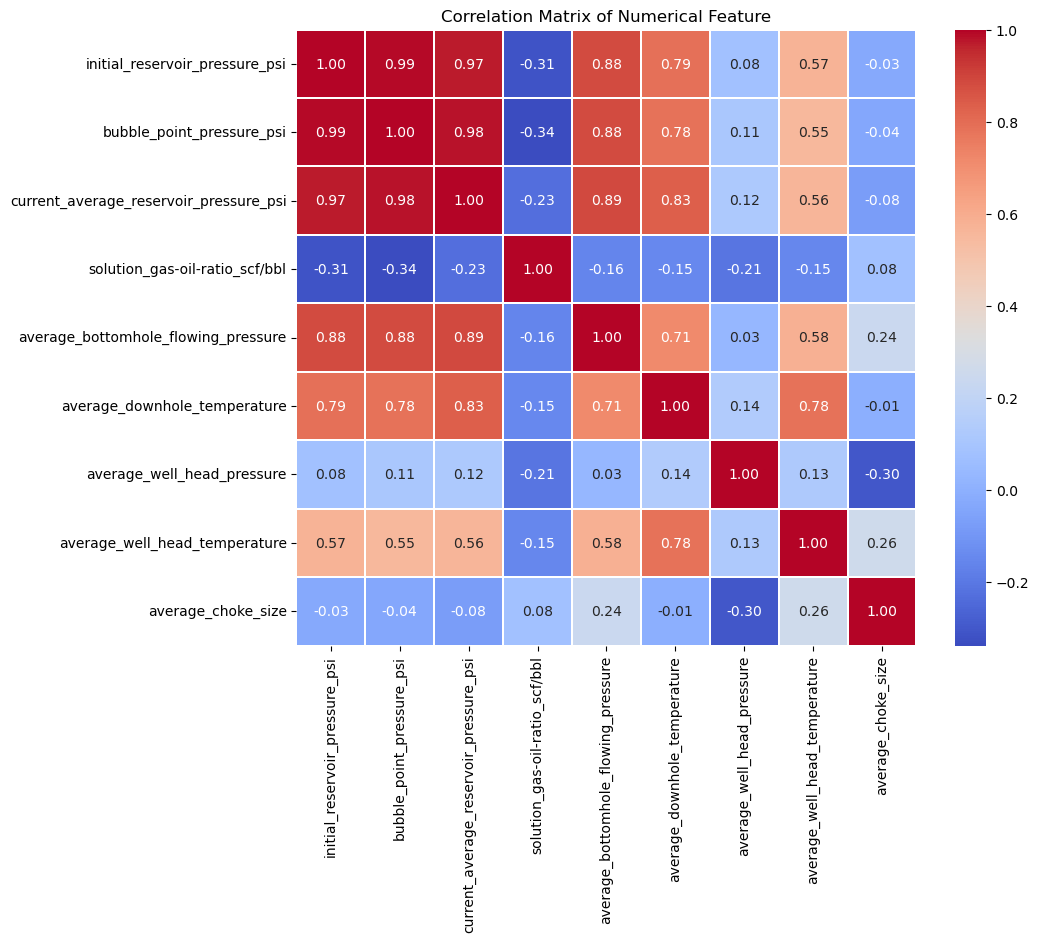

In [68]:
corr = feature1[Numerical].corr()
plt.figure(figsize= (10,8))
sns.heatmap(corr, annot= True, cmap= 'coolwarm', fmt='.2f', linewidths= .2)
plt.title('Correlation Matrix of Numerical Feature')
plt.show()

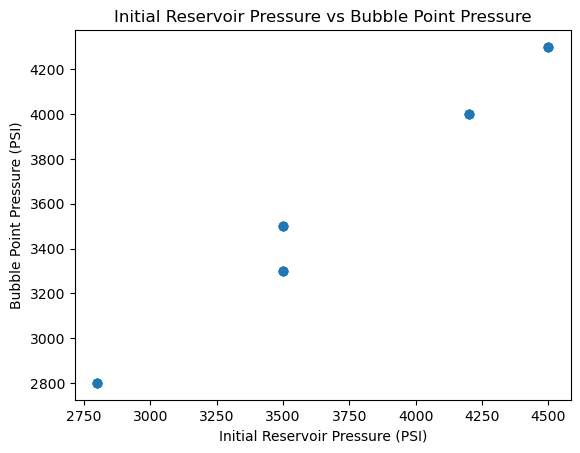

In [76]:
plt.scatter(feature1['initial_reservoir_pressure_psi'], feature1['bubble_point_pressure_psi'])
plt.xlabel('Initial Reservoir Pressure (PSI)')
plt.ylabel('Bubble Point Pressure (PSI)')
plt.title('Initial Reservoir Pressure vs Bubble Point Pressure')
plt.show()

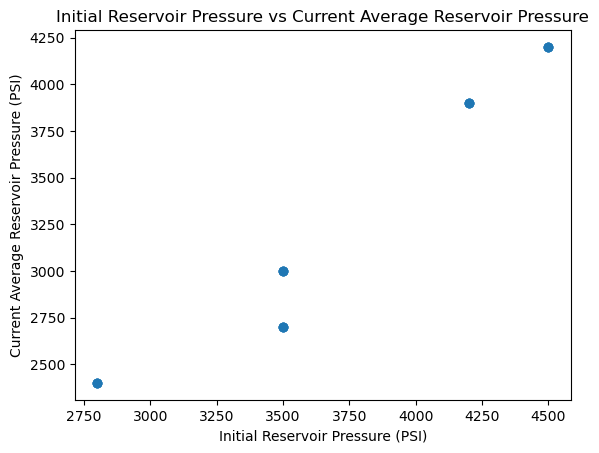

In [75]:
plt.scatter(feature1['initial_reservoir_pressure_psi'], feature1['current_average_reservoir_pressure_psi'])
plt.xlabel('Initial Reservoir Pressure (PSI)')
plt.ylabel('Current Average Reservoir Pressure (PSI)')
plt.title('Initial Reservoir Pressure vs Current Average Reservoir Pressure')
plt.show()

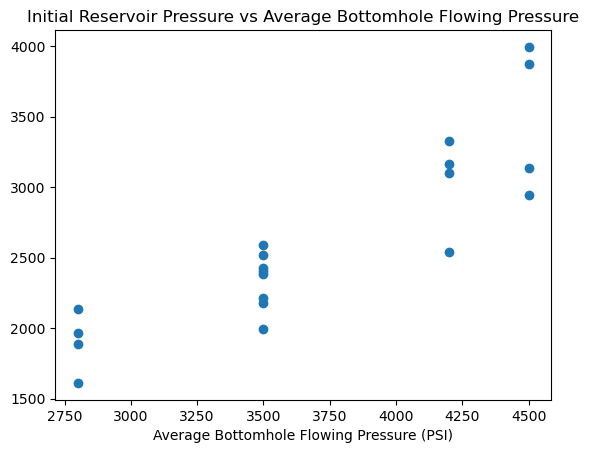

In [72]:
plt.scatter(feature1['initial_reservoir_pressure_psi'], feature1['average_bottomhole_flowing_pressure'])
plt.xlabel('Initial Reservoir Pressure (PSI)')
plt.xlabel('Average Bottomhole Flowing Pressure (PSI)')
plt.title('Initial Reservoir Pressure vs Average Bottomhole Flowing Pressure')
plt.show()

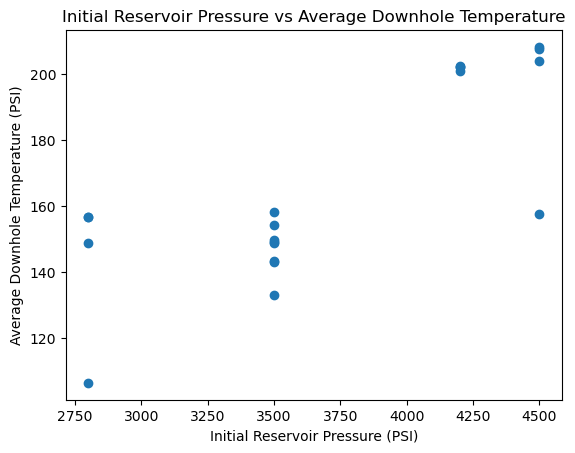

In [74]:
plt.scatter(feature1['initial_reservoir_pressure_psi'], feature1['average_downhole_temperature'])
plt.xlabel('Initial Reservoir Pressure (PSI)')
plt.ylabel('Average Downhole Temperature (PSI)')
plt.title('Initial Reservoir Pressure vs Average Downhole Temperature')
plt.show()

From the correlation of the feature variable it is observed that almost 5 variables are strongly correlated. They are:
1. `initial_reservoir_pressure_psi`
2. `bubble_point_pressure_psi`
3. `current_average_reservoir_pressure_psi`
4. `average_bottomhole_flowing_pressure`
On this note only one of these features will be used to train our ml models to avoid collinearity
`initial_reservoir_pressure_psi` will be used

In [88]:

x = ['well',
     'Reservoir Name',
    'initial_reservoir_pressure_psi',
    'solution_gas-oil-ratio_scf/bbl',
    'average_choke_size',
    'average_well_head_pressure',
    'average_well_head_temperature']
features = wellAndReservoirData[x]
features.head()

,well,Reservoir Name,initial_reservoir_pressure_psi,solution_gas-oil-ratio_scf/bbl,average_choke_size,average_well_head_pressure,average_well_head_temperature
0,Well_#1,JANI,4500.0,1000.0,45.234272,711.214985,107.716490
1,Well_#2,KEMA,4200.0,600.0,24.606748,861.152174,99.672191
2,Well_#3,MAKO,3500.0,500.0,7.436841,789.801290,59.222952
3,Well_#4,DEPU,2800.0,1200.0,21.905611,647.913186,87.516566
4,Well_#5,MAKO,3500.0,500.0,96.096684,425.250344,80.306366


For the features, we won't be training with `well` and `Reservoir Name` variables because it is necessary. So let's extract our training features

In [89]:
numerical_features = features.select_dtypes(include=np.number).columns.tolist()
#categorical_features = well_to_be_classified.select_dtypes(include='object').columns.tolist()
numerical_features

['initial_reservoir_pressure_psi',
 'solution_gas-oil-ratio_scf/bbl',
 'average_choke_size',
 'average_well_head_pressure',
 'average_well_head_temperature']

In [90]:
def get_data(x, target):
    
    df = pd.concat((x, target), axis=1)
    return df
    

#### Classification for Reservoir Type

**Feature Engineering**

In [91]:
res_type_data = get_data(features[numerical_features], targets['Reservoir Type'])
res_type_data.head()

,initial_reservoir_pressure_psi,solution_gas-oil-ratio_scf/bbl,average_choke_size,average_well_head_pressure,average_well_head_temperature,Reservoir Type
0,4500.0,1000.0,45.234272,711.214985,107.716490,undersat
1,4200.0,600.0,24.606748,861.152174,99.672191,undersat
2,3500.0,500.0,7.436841,789.801290,59.222952,saturated
3,2800.0,1200.0,21.905611,647.913186,87.516566,saturated
4,3500.0,500.0,96.096684,425.250344,80.306366,saturated


In [92]:
target = 'Reservoir Type'
X = res_type_data[numerical_features]
y =  res_type_data[target]
X.shape, y.shape

((20, 5), (20,))

In [93]:
# Encode the target variable(`Reservior Type`) with number such that 0 represents 'undersat' and 1 represents 'saturated'
y = y.map({'undersat': 0, 'saturated': 1})
print('The Number of target variable is : ', y.shape[0])
y[:4]

The Number of target variable is :  20


0    0
1    0
2    1
3    1
Name: Reservoir Type, dtype: int64

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=6, stratify=y) # stratify helps handle inbalance in the target variable
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16, 5), (4, 5), (16,), (4,))

In [95]:
print(f"\nTraining set shape: {X_train.shape}, Test set shape: {X_test.shape}")
print("Train target distribution:\n", y_train.value_counts(normalize=True))
print("Test target distribution:\n", y_test.value_counts(normalize=True))


Training set shape: (16, 5), Test set shape: (4, 5)
Train target distribution:
 Reservoir Type
0    0.625
1    0.375
Name: proportion, dtype: float64
Test target distribution:
 Reservoir Type
1    0.5
0    0.5
Name: proportion, dtype: float64


**Model Selection and Training**

In [96]:
# 4. Create the pipeline using make_pipeline
# The first step is the preprocessor, the second is the classifier
model_pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state=42, solver='liblinear') # Our final estimator, 'liblinear' is a good solver for small dataset
)

print("\nPipeline structure using make_pipeline:")
print(model_pipeline)

# To see the automatically generated names:
print("\nStep names in the pipeline:", model_pipeline.named_steps.keys())


Pipeline structure using make_pipeline:
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(random_state=42, solver='liblinear'))])

Step names in the pipeline: dict_keys(['standardscaler', 'logisticregression'])


In [97]:
# 5. Define the hyperparameter distributions for RandomizedSearchCV
# Access hyperparameters using the auto-generated names followed by double underscore
param_distributions = {
    'logisticregression__C': uniform(loc=0.01, scale=100),
    'logisticregression__penalty': ['l1', 'l2'] ##, 'elasticnet']
}

# 6. Perform Random Search with the pipeline
random_search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_distributions,
    n_iter=50,
    cv=5, # 5-fold cross-validation
    scoring='roc_auc', # Evaluate using ROC AUC
    random_state=42,
    n_jobs=-1, # Use all available CPU cores
    verbose=1
)

print("\nStarting RandomizedSearchCV with make_pipeline...")
random_search.fit(X_train, y_train) # Fit the pipeline to the original training data

# 7. Get the best model and evaluate
print("\nBest parameters found:", random_search.best_params_)
print("Best ROC AUC score (CV) on training data:", random_search.best_score_)

best_model = random_search.best_estimator_




Starting RandomizedSearchCV with make_pipeline...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best parameters found: {'logisticregression__C': 37.464011884736244, 'logisticregression__penalty': 'l1'}
Best ROC AUC score (CV) on training data: 1.0


In [98]:
# Putting the best model in a pipeline
model_pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(random_state= 42, solver= 'liblinear', C=37.46, penalty= 'l1') # Our final estimator
)


In [99]:
# Train the model
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=37.46, penalty='l1', random_state=42,
                                    solver='liblinear'))])

**Model Evaluation**

In [100]:
# Make prediction with the trained model
y_pred = model_pipeline.predict(X_test)
print(f'Accuracy score: {accuracy_score(y_test, y_pred):.4f}')
print(f'Precision Score: {precision_score(y_test, y_pred):.4f}')
print(f'Recall score: {recall_score(y_test, y_pred):.4f}')
print(f'F1 score: {f1_score(y_test, y_pred):.4f}')

Accuracy score: 1.0000
Precision Score: 1.0000
Recall score: 1.0000
F1 score: 1.0000


Let us now use our trained model to classify the 20 wells based on `Reservoir Type`

In [101]:
h = wellAndReservoirData[numerical_features]
prediction = model_pipeline.predict(h)
prediction = pd.Series(prediction)
prediction1 = prediction.map({0: 'Undersat', 1: 'Saturated'})

In [102]:
wells_classified =  wellAndReservoirData[['well', 'Reservoir Name']]
wells_classified['Reservoir Type'] = prediction1
wells_classified.head()

,well,Reservoir Name,Reservoir Type
0,Well_#1,JANI,Undersat
1,Well_#2,KEMA,Undersat
2,Well_#3,MAKO,Saturated
3,Well_#4,DEPU,Saturated
4,Well_#5,MAKO,Saturated


### Classification for Well Type

**Feature Engineering**

In [117]:
target = 'Well Type'

In [103]:
targets['Well Type'].unique()

array(['GL', 'NF'], dtype=object)

In [111]:
well_type_data = get_data(features[numerical_features], targets['Well Type'])
well_type_data.head()

target = 'Well Type'
X = well_type_data[numerical_features]
y =  well_type_data[target]
X.shape, y.shape

# Encode the target variable(`Well Type`) with number such that 0 represents 'undersat' and 1 represents 'saturated'
y = y.map({'NF': 0, 'GL': 1})
print(f'<---y---> \n{y}')

#split the data into train and test set
XX, yy = X.copy(), y.copy()
X_train, X_test, y_train, y_test = train_test_split(XX, yy, test_size = 0.2, random_state=6, stratify=y) # stratify helps handle inbalance in the target variable
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# visualize the split
print(f"\nTraining set shape: {X_train.shape}, Test set shape: {X_test.shape}")
print("Train target distribution:\n", y_train.value_counts(normalize=True))
print("Test target distribution:\n", y_test.value_counts(normalize=True))

<---y---> 
0     1
1     0
2     1
3     1
4     0
5     0
6     1
7     1
8     1
9     0
10    1
11    0
12    0
13    0
14    0
15    0
16    1
17    0
18    0
19    1
Name: Well Type, dtype: int64

Training set shape: (16, 5), Test set shape: (4, 5)
Train target distribution:
 Well Type
0    0.5625
1    0.4375
Name: proportion, dtype: float64
Test target distribution:
 Well Type
1    0.5
0    0.5
Name: proportion, dtype: float64


**Model Selection and Training**

In [112]:
# Create the pipeline using make_pipeline
model_pipeline = make_pipeline(
                                StandardScaler(),
                                LogisticRegression(random_state=42, solver='liblinear') 
                              )

print("\nStep names in the pipeline:", model_pipeline.named_steps.keys())

# Define the hyperparameter distributions for RandomizedSearchCV
# Access hyperparameters using the auto-generated names followed by double underscore
param_distributions = {
    'logisticregression__C': uniform(loc=0.01, scale=100),
    'logisticregression__penalty': ['l1', 'l2'] ##, 'elasticnet']
}

# Perform Random Search with the pipeline
random_search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_distributions,
    n_iter=100,
    cv=5, # 5-fold cross-validation
    scoring='roc_auc', # Evaluate using ROC AUC
    random_state=42,
    n_jobs=-1, # Use all available CPU cores
    verbose=1
)

print("Starting RandomizedSearchCV with make_pipeline...")
random_search.fit(X_train, y_train) # Fit the pipeline to the original training data

# 7. Get the best model and evaluate
print("\nBest parameters found:", random_search.best_params_)
print("Best ROC AUC score (CV) on training data:", random_search.best_score_)

best_model = random_search.best_estimator_




Step names in the pipeline: dict_keys(['standardscaler', 'logisticregression'])
Starting RandomizedSearchCV with make_pipeline...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best parameters found: {'logisticregression__C': 18.35347898661638, 'logisticregression__penalty': 'l2'}
Best ROC AUC score (CV) on training data: 0.75


In [106]:
# Create the pipeline using make_pipeline
model_pipeline = make_pipeline(
                                StandardScaler(),
                                SVC(random_state=42) 
                              )

print("\nStep names in the pipeline:", model_pipeline.named_steps.keys())

# Define the hyperparameter distributions for RandomizedSearchCV
# Access hyperparameters using the auto-generated names followed by double underscore
param_distributions = {
    'svc__C': uniform(loc=0.01, scale=100)
}

# Perform Random Search with the pipeline
random_search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_distributions,
    n_iter=150,
    cv=5, # 5-fold cross-validation
    scoring='roc_auc', # Evaluate using ROC AUC
    random_state=42,
    n_jobs=-1, # Use all available CPU cores
    verbose=1
)

print("Starting RandomizedSearchCV with make_pipeline...")
random_search.fit(X_train, y_train) # Fit the pipeline to the original training data

# 7. Get the best model and evaluate
print("\nBest parameters found:", random_search.best_params_)
print("Best ROC AUC score (CV) on training data:", random_search.best_score_)

best_model = random_search.best_estimator_




Step names in the pipeline: dict_keys(['standardscaler', 'svc'])
Starting RandomizedSearchCV with make_pipeline...
Fitting 5 folds for each of 150 candidates, totalling 750 fits

Best parameters found: {'svc__C': 37.464011884736244}
Best ROC AUC score (CV) on training data: 0.9


Support vector classifier(SVC) performed better than the logistic regression model

In [113]:
model_pipeline = make_pipeline(
                                StandardScaler(),
                                SVC(random_state=42, C=37.46) 
                              )
# train the model
model_pipeline.fit(X_train, y_train)

In [115]:
# Make prediction with the trained model
y_pred = model_pipeline.predict(X_test)
print(f'Accuracy score: {accuracy_score(y_test, y_pred):.4f}')
print(f'Precision Score: {precision_score(y_test, y_pred):.4f}')
print(f'Recall score: {recall_score(y_test, y_pred):.4f}')
print(f'F1 score: {f1_score(y_test, y_pred):.4f}')

Accuracy score: 0.5000
Precision Score: 0.0000
Recall score: 0.0000
F1 score: 0.0000


On the test data, the model did not really perform well. This could be because the dataset is small.
<br>We could use bootstrapping to increase the datapoints for a robust training

In [110]:
from sklearn.utils import resample #bootstrapping function

In [116]:
bootstrapped_data = resample(pd.concat((X, y),axis=1), replace= True, n_samples=1000, random_state= 42)

In [118]:
X, y = bootstrapped_data[numerical_features], bootstrapped_data[target]
X.shape, y.shape 

((1000, 5), (1000,))

In [120]:
#split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=6) #stratify=y) # stratify helps handle inbalance in the target variable
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 5), (200, 5), (800,), (200,))

In [121]:
# Create the pipeline using make_pipeline
model_pipeline = make_pipeline(
                                StandardScaler(),
                                SVC(random_state=42) 
                              )

print("\nStep names in the pipeline:", model_pipeline.named_steps.keys())

# Define the hyperparameter distributions for RandomizedSearchCV
# Access hyperparameters using the auto-generated names followed by double underscore
param_distributions = {
    'svc__C': uniform(loc=0.01, scale=100)
}

# Perform Random Search with the pipeline
random_search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_distributions,
    n_iter=150,
    cv=5, # 5-fold cross-validation
    scoring='roc_auc', # Evaluate using ROC AUC
    random_state=42,
    n_jobs=-1, # Use all available CPU cores
    verbose=1
)

print("Starting RandomizedSearchCV with make_pipeline...")
random_search.fit(X_train, y_train) # Fit the pipeline to the original training data

# 7. Get the best model and evaluate
print("\nBest parameters found:", random_search.best_params_)
print("Best ROC AUC score (CV) on training data:", random_search.best_score_)

best_model = random_search.best_estimator_




Step names in the pipeline: dict_keys(['standardscaler', 'svc'])
Starting RandomizedSearchCV with make_pipeline...
Fitting 5 folds for each of 150 candidates, totalling 750 fits

Best parameters found: {'svc__C': 37.464011884736244}
Best ROC AUC score (CV) on training data: 1.0


**After Augmenting our dataset through bootstrapping, we used it to train the SVC model. We got the best accuracy**

In [123]:
model_pipeline = make_pipeline(
                                StandardScaler(),
                                SVC(random_state=42, C=37.46) 
                              )
# train the model
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=37.46, random_state=42))])

**Model Evaluation**

In [124]:
#calculate the model accuracy on test set
y_pred = model_pipeline.predict(X_test)
print(f'Accuracy score: {accuracy_score(y_test, y_pred):.4f}')
print(f'Precision Score: {precision_score(y_test, y_pred):.4f}')
print(f'Recall score: {recall_score(y_test, y_pred):.4f}')
print(f'F1 score: {f1_score(y_test, y_pred):.4f}')


Accuracy score: 1.0000
Precision Score: 1.0000
Recall score: 1.0000
F1 score: 1.0000


Let us now use our trained model to classify the 20 wells based on `Well Type`

In [125]:
h = wellAndReservoirData[numerical_features]
prediction = model_pipeline.predict(h)
prediction = pd.Series(prediction)
prediction1 = prediction.map({0: 'NF', 1: 'GL'})

In [127]:
#Checking our prediction
prediction1 == targets[target]

0     True
1     True
2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
10    True
11    True
12    True
13    True
14    True
15    True
16    True
17    True
18    True
19    True
dtype: bool

In [128]:
#wells_classified =  wellAndReservoirData[['well', 'Reservoir Name']]
wells_classified['Well Type'] = prediction1
wells_classified.head()

,well,Reservoir Name,Reservoir Type,Well Type
0,Well_#1,JANI,Undersat,GL
1,Well_#2,KEMA,Undersat,NF
2,Well_#3,MAKO,Saturated,GL
3,Well_#4,DEPU,Saturated,GL
4,Well_#5,MAKO,Saturated,NF


### Classification for Production Type

**Feature Engineering**

In [129]:
target = 'Production Type'

In [130]:
targets[target].unique()

array(['Unsteady', 'Steady'], dtype=object)

In [131]:
well_type_data = get_data(features[numerical_features], targets['Production Type'])
well_type_data.head()

target = 'Production Type'
X = well_type_data[numerical_features]
y =  well_type_data[target]
X.shape, y.shape

# Encode the target variable(`Well Type`) with number such that 0 represents 'undersat' and 1 represents 'saturated'
y = y.map({'Steady': 0, 'Unsteady': 1})
print(f'<---y---> \n{y}')

#split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=6, stratify=y) # stratify helps handle inbalance in the target variable
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# visualize the split
print(f"\nTraining set shape: {X_train.shape}, Test set shape: {X_test.shape}")
print("Train target distribution:\n", y_train.value_counts(normalize=True))
print("Test target distribution:\n", y_test.value_counts(normalize=True))

<---y---> 
0     1
1     1
2     0
3     0
4     1
5     0
6     0
7     0
8     0
9     1
10    1
11    0
12    0
13    0
14    1
15    0
16    0
17    0
18    0
19    0
Name: Production Type, dtype: int64

Training set shape: (16, 5), Test set shape: (4, 5)
Train target distribution:
 Production Type
0    0.6875
1    0.3125
Name: proportion, dtype: float64
Test target distribution:
 Production Type
0    0.75
1    0.25
Name: proportion, dtype: float64


**Model Selection and Training**

In [132]:
# Create the pipeline using make_pipeline
model_pipeline = make_pipeline(
                                StandardScaler(),
                                LogisticRegression(random_state=42, solver='liblinear') 
                              )

print("\nStep names in the pipeline:", model_pipeline.named_steps.keys())

# Define the hyperparameter distributions for RandomizedSearchCV
# Access hyperparameters using the auto-generated names followed by double underscore
param_distributions = {
    'logisticregression__C': uniform(loc=0.01, scale=100),
    'logisticregression__penalty': ['l1', 'l2'] ##, 'elasticnet']
}

# Perform Random Search with the pipeline
random_search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_distributions,
    n_iter=50,
    cv=5, # 5-fold cross-validation
    scoring='roc_auc', # Evaluate using ROC AUC
    random_state=42,
    n_jobs=-1, # Use all available CPU cores
    verbose=1
)

print("Starting RandomizedSearchCV with make_pipeline...")
random_search.fit(X_train, y_train) # Fit the pipeline to the original training data

# Get the best model and evaluate
print("\nBest parameters found:", random_search.best_params_)
print("Best ROC AUC score (CV) on training data:", random_search.best_score_)

best_model = random_search.best_estimator_



Step names in the pipeline: dict_keys(['standardscaler', 'logisticregression'])
Starting RandomizedSearchCV with make_pipeline...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best parameters found: {'logisticregression__C': 0.5622117123602399, 'logisticregression__penalty': 'l1'}
Best ROC AUC score (CV) on training data: 0.75


In [133]:
# Create the pipeline using make_pipeline
model_pipeline = make_pipeline(
                                StandardScaler(),
                                SVC(random_state=42) 
                              )

print("\nStep names in the pipeline:", model_pipeline.named_steps.keys())

# Define the hyperparameter distributions for RandomizedSearchCV
# Access hyperparameters using the auto-generated names followed by double underscore
param_distributions = {
    'svc__C': uniform(loc=0.01, scale=100)
}

# Perform Random Search with the pipeline
random_search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_distributions,
    n_iter=50,
    cv=5, # 5-fold cross-validation
    scoring='roc_auc', # Evaluate using ROC AUC
    random_state=42,
    n_jobs=-1, # Use all available CPU cores
    verbose=1
)

print("Starting RandomizedSearchCV with make_pipeline...")
random_search.fit(X_train, y_train) # Fit the pipeline to the original training data

# Get the best model and evaluate
print("\nBest parameters found:", random_search.best_params_)
print("Best ROC AUC score (CV) on training data:", random_search.best_score_)

best_model = random_search.best_estimator_


Step names in the pipeline: dict_keys(['standardscaler', 'svc'])
Starting RandomizedSearchCV with make_pipeline...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best parameters found: {'svc__C': 5.818361216819946}
Best ROC AUC score (CV) on training data: 0.7


In [134]:
model_pipeline = make_pipeline(
                                StandardScaler(),
                                LogisticRegression(random_state=42, solver= 'liblinear', C=0.52, penalty= 'l1') 
                              )

# Train the model
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.52, penalty='l1', random_state=42,
                                    solver='liblinear'))])

In [135]:
# Make prediction with the trained model
y_pred = model_pipeline.predict(X_test)
print(f'Accuracy score: {accuracy_score(y_test, y_pred):.4f}')
print(f'Precision Score: {precision_score(y_test, y_pred):.4f}')
print(f'Recall score: {recall_score(y_test, y_pred):.4f}')
print(f'F1 score: {f1_score(y_test, y_pred):.4f}')

Accuracy score: 0.2500
Precision Score: 0.0000
Recall score: 0.0000
F1 score: 0.0000


**With just the given data our model performance happens to be poorly performing. Let's try augmenting the dataset by bootstrapping it**

In [152]:
bootstrapped_data = resample(pd.concat((X.copy(), y.copy()),axis=1), replace= True, n_samples=5000, random_state= 42)

X, y = bootstrapped_data[numerical_features], bootstrapped_data[target]
X.shape, y.shape 

#split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=6) #stratify=y) # stratify helps handle inbalance in the target variable
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4000, 5), (1000, 5), (4000,), (1000,))

In [153]:
# Create the pipeline using make_pipeline
model_pipeline = make_pipeline(
                                StandardScaler(),
                                LogisticRegression(random_state=42, solver='liblinear') 
                              )

print("\nStep names in the pipeline:", model_pipeline.named_steps.keys())

# Define the hyperparameter distributions for RandomizedSearchCV
# Access hyperparameters using the auto-generated names followed by double underscore
param_distributions = {
    'logisticregression__C': uniform(loc=0.01, scale=100),
    'logisticregression__penalty': ['l1', 'l2'] ##, 'elasticnet']
}

# Perform Random Search with the pipeline
random_search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_distributions,
    n_iter=50,
    cv=5, # 5-fold cross-validation
    scoring='roc_auc', # Evaluate using ROC AUC
    random_state=42,
    n_jobs=-1, # Use all available CPU cores
    verbose=1
)

print("Starting RandomizedSearchCV with make_pipeline...")
random_search.fit(X_train, y_train) # Fit the pipeline to the original training data

# Get the best model and evaluate
print("\nBest parameters found:", random_search.best_params_)
print("Best ROC AUC score (CV) on training data:", random_search.best_score_)

best_model = random_search.best_estimator_



Step names in the pipeline: dict_keys(['standardscaler', 'logisticregression'])
Starting RandomizedSearchCV with make_pipeline...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best parameters found: {'logisticregression__C': 37.464011884736244, 'logisticregression__penalty': 'l1'}
Best ROC AUC score (CV) on training data: 0.9106164367370917


**Model Performance increased after augmenting our dataset**

In [154]:
model_pipeline = make_pipeline(
                                StandardScaler(),
                                LogisticRegression(random_state=42, solver= 'liblinear', C=0.52, penalty= 'l1') 
                              )

# Train the model
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.52, penalty='l1', random_state=42,
                                    solver='liblinear'))])

**Model Evaluation**

In [155]:
#calculate the model accuracy on test set
y_pred = model_pipeline.predict(X_test)
print(f'Accuracy score: {accuracy_score(y_test, y_pred):.4f}')
print(f'Precision Score: {precision_score(y_test, y_pred):.4f}')
print(f'Recall score: {recall_score(y_test, y_pred):.4f}')
print(f'F1 score: {f1_score(y_test, y_pred):.4f}')


Accuracy score: 0.8090
Precision Score: 0.6901
Recall score: 0.7352
F1 score: 0.7119


**The model performance has increased greatly. So, we have a model to work with**

In [156]:
h = wellAndReservoirData[numerical_features]
prediction = model_pipeline.predict(h)
prediction = pd.Series(prediction)
prediction1 = prediction.map({0: 'Steady', 1: 'Unsteady'})

In [158]:
wells_classified['Production Type'] = prediction1
wells_classified.head()

,well,Reservoir Name,Reservoir Type,Well Type,Production Type
0,Well_#1,JANI,Undersat,GL,Unsteady
1,Well_#2,KEMA,Undersat,NF,Unsteady
2,Well_#3,MAKO,Saturated,GL,Steady
3,Well_#4,DEPU,Saturated,GL,Steady
4,Well_#5,MAKO,Saturated,NF,Unsteady


### Classification Formation GOR

**Feature Engineering**

In [160]:
target = 'Formation GOR'

In [161]:
targets[target].unique()

array(['Combo', 'aSolGOR', 'bSolGOR'], dtype=object)

In [164]:
well_type_data = get_data(features[numerical_features], targets['Formation GOR'])
well_type_data.head()

target = 'Formation GOR'
X = well_type_data[numerical_features]
y =  well_type_data[target]
X.shape, y.shape

# Encode the target variable(`Well Type`) with number such that 0 represents 'undersat' and 1 represents 'saturated'
y = y.map({'Combo': 0, 'aSolGOR': 1, 'bSolGOR': 2})
print(f'<---y---> \n{y}')

#split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X.copy(), y.copy(), test_size = 0.2, random_state=6, stratify=y) # stratify helps handle inbalance in the target variable
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# visualize the split
print(f"\nTraining set shape: {X_train.shape}, Test set shape: {X_test.shape}")
print("Train target distribution:\n", y_train.value_counts(normalize=True))
print("Test target distribution:\n", y_test.value_counts(normalize=True))

<---y---> 
0     0
1     0
2     1
3     1
4     1
5     1
6     1
7     1
8     2
9     1
10    1
11    2
12    1
13    2
14    0
15    1
16    2
17    1
18    0
19    0
Name: Formation GOR, dtype: int64

Training set shape: (16, 5), Test set shape: (4, 5)
Train target distribution:
 Formation GOR
1    0.5625
0    0.2500
2    0.1875
Name: proportion, dtype: float64
Test target distribution:
 Formation GOR
1    0.50
2    0.25
0    0.25
Name: proportion, dtype: float64


**Model Selection and Training**

In [165]:
# Create the pipeline using make_pipeline
model_pipeline = make_pipeline(
                                StandardScaler(),
                                LogisticRegression(random_state=42, solver='lbfgs', penalty= 'l2', multi_class= 'multinomial') 
                              )

print("\nStep names in the pipeline:", model_pipeline.named_steps.keys())

# Define the hyperparameter distributions for RandomizedSearchCV
# Access hyperparameters using the auto-generated names followed by double underscore
param_distributions = {
    'logisticregression__C': uniform(loc=0.01, scale=100)
}

# Perform Random Search with the pipeline
random_search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_distributions,
    n_iter=50,
    cv=5, # 5-fold cross-validation
    scoring='roc_auc', # Evaluate using ROC AUC
    random_state=42,
    n_jobs=-1, # Use all available CPU cores
    verbose=1
)

print("Starting RandomizedSearchCV with make_pipeline...")
random_search.fit(X_train, y_train) # Fit the pipeline to the original training data

# Get the best model and evaluate
print("\nBest parameters found:", random_search.best_params_)
print("Best ROC AUC score (CV) on training data:", random_search.best_score_)

best_model = random_search.best_estimator_


Step names in the pipeline: dict_keys(['standardscaler', 'logisticregression'])
Starting RandomizedSearchCV with make_pipeline...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best parameters found: {'logisticregression__C': 37.464011884736244}
Best ROC AUC score (CV) on training data: nan


In [166]:
# Create the pipeline using make_pipeline
model_pipeline = make_pipeline(
                                StandardScaler(),
                                SVC(random_state=42) 
                              )

print("\nStep names in the pipeline:", model_pipeline.named_steps.keys())

# Define the hyperparameter distributions for RandomizedSearchCV
# Access hyperparameters using the auto-generated names followed by double underscore
param_distributions = {
    'svc__C': uniform(loc=0.01, scale=100)
}

# Perform Random Search with the pipeline
random_search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_distributions,
    n_iter=50,
    cv=5, # 5-fold cross-validation
    scoring='roc_auc', # Evaluate using ROC AUC
    random_state=42,
    n_jobs=-1, # Use all available CPU cores
    verbose=1
)

print("Starting RandomizedSearchCV with make_pipeline...")
random_search.fit(X, y) # Fit the pipeline to the original training data

# Get the best model and evaluate
print("\nBest parameters found:", random_search.best_params_)
print("Best ROC AUC score (CV) on training data:", random_search.best_score_)

best_model = random_search.best_estimator_


Step names in the pipeline: dict_keys(['standardscaler', 'svc'])
Starting RandomizedSearchCV with make_pipeline...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best parameters found: {'svc__C': 37.464011884736244}
Best ROC AUC score (CV) on training data: nan


In [167]:
model_pipeline = make_pipeline(
                                StandardScaler(),
                                LogisticRegression(random_state=42, solver='lbfgs', penalty= 'l2', multi_class= 'multinomial') 
)
# Train the model
model_pipeline.fit(X_train, y_train)

In [168]:
# Train the model
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(multi_class='multinomial',
                                    random_state=42))])

In [169]:
# Make prediction with the trained model
y_pred = model_pipeline.predict(X_test)
print(f'Accuracy score: {accuracy_score(y_test, y_pred):.4f}')
print(f'Precision Score: {precision_score(y_test, y_pred, average= 'micro'):.4f}')
print(f'Recall score: {recall_score(y_test, y_pred, average= 'micro'):.4f}')
print(f'F1 score: {f1_score(y_test, y_pred, average = 'micro'):.4f}')

Accuracy score: 0.5000
Precision Score: 0.5000
Recall score: 0.5000
F1 score: 0.5000


**The model is not performing really well. Let us see if data augmentation will help**

In [170]:
bootstrapped_data = resample(pd.concat((X.copy(), y.copy()),axis=1), replace= True, n_samples=5000, random_state= 42)

X, y = bootstrapped_data[numerical_features], bootstrapped_data[target]
X.shape, y.shape 

#split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=6) #stratify=y) # stratify helps handle inbalance in the target variable
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4000, 5), (1000, 5), (4000,), (1000,))

In [172]:
# Create the pipeline using make_pipeline
model_pipeline = make_pipeline(
                                StandardScaler(),
                                LogisticRegression(random_state=42, solver='lbfgs', penalty= 'l2', multi_class= 'multinomial') 
                              )

print("\nStep names in the pipeline:", model_pipeline.named_steps.keys())

# Define the hyperparameter distributions for RandomizedSearchCV
# Access hyperparameters using the auto-generated names followed by double underscore
param_distributions = {
    'logisticregression__C': uniform(loc=0.01, scale=100)
}

# Perform Random Search with the pipeline
random_search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_distributions,
    n_iter=50,
    cv=7, # 5-fold cross-validation
    scoring='roc_auc', # Evaluate using ROC AUC
    random_state=42,
    n_jobs=-1, # Use all available CPU cores
    verbose=1
)

print("Starting RandomizedSearchCV with make_pipeline...")
random_search.fit(X_train, y_train) # Fit the pipeline to the original training data

# Get the best model and evaluate
print("\nBest parameters found:", random_search.best_params_)
print("Best ROC AUC score (CV) on training data:", random_search.best_score_)

best_model = random_search.best_estimator_


Step names in the pipeline: dict_keys(['standardscaler', 'logisticregression'])
Starting RandomizedSearchCV with make_pipeline...
Fitting 7 folds for each of 50 candidates, totalling 350 fits

Best parameters found: {'logisticregression__C': 37.464011884736244}
Best ROC AUC score (CV) on training data: nan


In [173]:
model_pipeline = make_pipeline(
                                StandardScaler(),
                                LogisticRegression(random_state=42, solver= 'liblinear', C=0.52, penalty= 'l1') 
                              )

# Train the model
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.52, penalty='l1', random_state=42,
                                    solver='liblinear'))])

**Model Evaluation**

In [174]:
# Make prediction with the trained model
y_pred = model_pipeline.predict(X_test)
print(f'Accuracy score: {accuracy_score(y_test, y_pred):.4f}')
print(f'Precision Score: {precision_score(y_test, y_pred, average= 'micro'):.4f}')
print(f'Recall score: {recall_score(y_test, y_pred, average= 'micro'):.4f}')
print(f'F1 score: {f1_score(y_test, y_pred, average = 'micro'):.4f}')

Accuracy score: 0.8550
Precision Score: 0.8550
Recall score: 0.8550
F1 score: 0.8550


In [176]:
h = wellAndReservoirData[numerical_features]
prediction = model_pipeline.predict(h)
prediction = pd.Series(prediction)

prediction1 = prediction.map({0:'Combo', 1:'aSolGOR', 2:'bSolGOR'})

In [177]:
wells_classified['Formation GOR'] = prediction1
wells_classified.head()

,well,Reservoir Name,Reservoir Type,Well Type,Production Type,Formation GOR
0,Well_#1,JANI,Undersat,GL,Unsteady,Combo
1,Well_#2,KEMA,Undersat,NF,Unsteady,Combo
2,Well_#3,MAKO,Saturated,GL,Steady,aSolGOR
3,Well_#4,DEPU,Saturated,GL,Steady,aSolGOR
4,Well_#5,MAKO,Saturated,NF,Unsteady,aSolGOR


### Classification for Watercut Trend

**Feature Engineering**

In [219]:
target = 'Watercut Trend' 
y = targets[target]

In [220]:
y.unique()

array(['Incr', 'Combo'], dtype=object)

In [221]:
X = features[numerical_features]
y =  y
X.shape, y.shape

# Encode the target variable(`Well Type`) with number such that 0 represents 'undersat' and 1 represents 'saturated'
y = y.map({'Incr': 0, 'Combo': 1})
print(f'<---y---> \n{y}')

#split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=6) #stratify=y) # stratify helps handle inbalance in the target variable
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# visualize the split
print(f"\nTraining set shape: {X_train.shape}, Test set shape: {X_test.shape}")
print("Train target distribution:\n", y_train.value_counts(normalize=True))
print("Test target distribution:\n", y_test.value_counts(normalize=True))

<---y---> 
0     0
1     0
2     0
3     1
4     0
5     1
6     0
7     1
8     0
9     1
10    0
11    0
12    1
13    0
14    1
15    1
16    0
17    0
18    0
19    0
Name: Watercut Trend, dtype: int64

Training set shape: (16, 5), Test set shape: (4, 5)
Train target distribution:
 Watercut Trend
0    0.6875
1    0.3125
Name: proportion, dtype: float64
Test target distribution:
 Watercut Trend
0    0.5
1    0.5
Name: proportion, dtype: float64


In [222]:
# Create the pipeline using make_pipeline
model_pipeline = make_pipeline(
                                StandardScaler(),
                                LogisticRegression(random_state=42, solver='liblinear') 
                              )

print("\nStep names in the pipeline:", model_pipeline.named_steps.keys())

# Define the hyperparameter distributions for RandomizedSearchCV
# Access hyperparameters using the auto-generated names followed by double underscore
param_distributions = {
    'logisticregression__C': uniform(loc=0.01, scale=100),
    'logisticregression__penalty': ['l1', 'l2'] ##, 'elasticnet']
}

# Perform Random Search with the pipeline
random_search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_distributions,
    n_iter=100,
    cv=3, # 5-fold cross-validation
    scoring='accuracy', # Evaluate using ROC AUC
    random_state=42,
    n_jobs=-1, # Use all available CPU cores
    verbose=1
)

print("Starting RandomizedSearchCV with make_pipeline...")
random_search.fit(X_train, y_train) # Fit the pipeline to the original training data

# Get the best model and evaluate
print("\nBest parameters found:", random_search.best_params_)
print("Best ROC AUC score (CV) on training data:", random_search.best_score_)

best_model = random_search.best_estimator_



Step names in the pipeline: dict_keys(['standardscaler', 'logisticregression'])
Starting RandomizedSearchCV with make_pipeline...
Fitting 3 folds for each of 100 candidates, totalling 300 fits

Best parameters found: {'logisticregression__C': 37.464011884736244, 'logisticregression__penalty': 'l1'}
Best ROC AUC score (CV) on training data: 0.5333333333333333


In [223]:
# Create the pipeline using make_pipeline
model_pipeline = make_pipeline(
                                StandardScaler(),
                                SVC(random_state=42) 
                              )

print("\nStep names in the pipeline:", model_pipeline.named_steps.keys())

# Define the hyperparameter distributions for RandomizedSearchCV
# Access hyperparameters using the auto-generated names followed by double underscore
param_distributions = {
    'svc__C': uniform(loc=0.01, scale=100)
}

# Perform Random Search with the pipeline
random_search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_distributions,
    n_iter=50,
    cv=5, # 5-fold cross-validation
    scoring='roc_auc', # Evaluate using ROC AUC
    random_state=42,
    n_jobs=-1, # Use all available CPU cores
    verbose=1
)

print("Starting RandomizedSearchCV with make_pipeline...")
random_search.fit(X, y) # Fit the pipeline to the original training data

# Get the best model and evaluate
print("\nBest parameters found:", random_search.best_params_)
print("Best ROC AUC score (CV) on training data:", random_search.best_score_)

best_model = random_search.best_estimator_


Step names in the pipeline: dict_keys(['standardscaler', 'svc'])
Starting RandomizedSearchCV with make_pipeline...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best parameters found: {'svc__C': 2.0684494295802445}
Best ROC AUC score (CV) on training data: 0.5333333333333334


In [224]:
model_pipeline = make_pipeline(
                                StandardScaler(),
                                LogisticRegression(random_state=42, solver='liblinear', C=37.46, penalty= 'l1') 
)

In [225]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=37.46, penalty='l1', random_state=42,
                                    solver='liblinear'))])

In [226]:
#calculate the model accuracy on test set
y_pred = model_pipeline.predict(X_test)
print(f'Accuracy score: {accuracy_score(y_test, y_pred):.4f}')
print(f'Precision Score: {precision_score(y_test, y_pred):.4f}')
print(f'Recall score: {recall_score(y_test, y_pred):.4f}')
print(f'F1 score: {f1_score(y_test, y_pred):.4f}')

Accuracy score: 0.5000
Precision Score: 0.0000
Recall score: 0.0000
F1 score: 0.0000


With randomizedSearchCV, the best estimator performed poorly. 
One of the reasons for this could be because the training data is small.
<br>To address the small size of the training data, we can bootstrap 
the original data to have a larger dataset.
<br>The implementation is shown below.

In [227]:
bootstrapped_data = resample(pd.concat((X, y),axis=1), replace= True, n_samples=20000, random_state= 42)

In [228]:
#split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(bootstrapped_data[numerical_features], bootstrapped_data['Watercut Trend'], test_size = 0.2, random_state=6) #stratify=y) # stratify helps handle inbalance in the target variable
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16000, 5), (4000, 5), (16000,), (4000,))

**Let us search for the best parameters on the bootstrapped data**

In [229]:
# Create the pipeline using make_pipeline
model_pipeline = make_pipeline(
                                StandardScaler(),
                                LogisticRegression(random_state=42, solver='liblinear') 
                              )

print("\nStep names in the pipeline:", model_pipeline.named_steps.keys())

# Define the hyperparameter distributions for RandomizedSearchCV
# Access hyperparameters using the auto-generated names followed by double underscore
param_distributions = {
    'logisticregression__C': uniform(loc=0.01, scale=100),
    'logisticregression__penalty': ['l1', 'l2'] ##, 'elasticnet']
}

# Perform Random Search with the pipeline
random_search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_distributions,
    n_iter=100,
    cv=3, # 5-fold cross-validation
    scoring='accuracy', # Evaluate using ROC AUC
    random_state=42,
    n_jobs=-1, # Use all available CPU cores
    verbose=1
)

print("Starting RandomizedSearchCV with make_pipeline...")
random_search.fit(X_train, y_train) # Fit the pipeline to the original training data

# Get the best model and evaluate
print("\nBest parameters found:", random_search.best_params_)
print("Best ROC AUC score (CV) on training data:", random_search.best_score_)

best_model = random_search.best_estimator_



Step names in the pipeline: dict_keys(['standardscaler', 'logisticregression'])
Starting RandomizedSearchCV with make_pipeline...
Fitting 3 folds for each of 100 candidates, totalling 300 fits

Best parameters found: {'logisticregression__C': 37.464011884736244, 'logisticregression__penalty': 'l1'}
Best ROC AUC score (CV) on training data: 0.8993749328118158


**The model performance improved drastically after increasing the size of the training set. So, let us now train the model with the best parameters**

In [230]:
model_pipeline = make_pipeline(
                                StandardScaler(),
                                LogisticRegression(random_state=42, solver='liblinear', C=37.46, penalty= 'l1') 
)

In [231]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=37.46, penalty='l1', random_state=42,
                                    solver='liblinear'))])

In [232]:
#calculate the model accuracy on test set
y_pred = model_pipeline.predict(X_test)
print(f'Accuracy score: {accuracy_score(y_test, y_pred):.4f}')
print(f'Precision Score: {precision_score(y_test, y_pred):.4f}')
print(f'Recall score: {recall_score(y_test, y_pred):.4f}')
print(f'F1 score: {f1_score(y_test, y_pred):.4f}')


Accuracy score: 0.9028
Precision Score: 1.0000
Recall score: 0.7181
F1 score: 0.8359


**The model performance has increased. At this point, we can make prediction with the model now because it is quite better compared to the former**

In [233]:
h = wellAndReservoirData[numerical_features]
prediction = model_pipeline.predict(h)
prediction = pd.Series(prediction)

prediction1 = prediction.map({0:'Incr', 1:'Combo'})

In [235]:
wells_classified['Watercut Trend'] = prediction1
wells_classified.head()

,well,Reservoir Name,Reservoir Type,Well Type,Production Type,Formation GOR,Watercut Trend
0,Well_#1,JANI,Undersat,GL,Unsteady,Combo,Incr
1,Well_#2,KEMA,Undersat,NF,Unsteady,Combo,Incr
2,Well_#3,MAKO,Saturated,GL,Steady,aSolGOR,Incr
3,Well_#4,DEPU,Saturated,GL,Steady,aSolGOR,Incr
4,Well_#5,MAKO,Saturated,NF,Unsteady,aSolGOR,Incr


### Classification for Oil Productivity index

In [237]:
target = 'Oil Productivity Index'
y = targets[target]
y

0      Decr
1      Flat
2      Flat
3     Combo
4      Flat
5     Combo
6      Flat
7     Combo
8      Decr
9      Incr
10     Decr
11    Combo
12     Incr
13     Decr
14     Flat
15    Combo
16     Decr
17    Combo
18     Incr
19     Decr
Name: Oil Productivity Index, dtype: object

In [238]:
y.unique()

array(['Decr', 'Flat', 'Combo', 'Incr'], dtype=object)

In [239]:
X = features[numerical_features]
y =  y
print('X and y shape:', X.shape, y.shape)

# Encode the target variable(`Well Type`) with number such that 0 represents 'undersat' and 1 represents 'saturated'
y = y.map({'Incr': 0, 'Decr': 1, 'Flat': 3, 'Combo': 4})
print(f'<---y---> \n{y}')

#split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X.copy(), y.copy(), test_size = 0.2, random_state=6) #stratify=y) # stratify helps handle inbalance in the target variable
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# visualize the split
print(f"\nTraining set shape: {X_train.shape}, Test set shape: {X_test.shape}")
print("Train target distribution:\n", y_train.value_counts(normalize=True))
print("Test target distribution:\n", y_test.value_counts(normalize=True))

X and y shape: (20, 5) (20,)
<---y---> 
0     1
1     3
2     3
3     4
4     3
5     4
6     3
7     4
8     1
9     0
10    1
11    4
12    0
13    1
14    3
15    4
16    1
17    4
18    0
19    1
Name: Oil Productivity Index, dtype: int64

Training set shape: (16, 5), Test set shape: (4, 5)
Train target distribution:
 Oil Productivity Index
1    0.3750
3    0.2500
4    0.1875
0    0.1875
Name: proportion, dtype: float64
Test target distribution:
 Oil Productivity Index
4    0.75
3    0.25
Name: proportion, dtype: float64


In [240]:
# Create the pipeline using make_pipeline
model_pipeline = make_pipeline(
                                StandardScaler(),
                                SVC(random_state=42) 
                              )

print("\nStep names in the pipeline:", model_pipeline.named_steps.keys())

# Define the hyperparameter distributions for RandomizedSearchCV
# Access hyperparameters using the auto-generated names followed by double underscore
param_distributions = {
    'svc__C': uniform(loc=0.01, scale=100)
}

# Perform Random Search with the pipeline
random_search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_distributions,
    n_iter=50,
    cv=5, # 5-fold cross-validation
    scoring='roc_auc', # Evaluate using ROC AUC
    random_state=42,
    n_jobs=-1, # Use all available CPU cores
    verbose=1
)

print("Starting RandomizedSearchCV with make_pipeline...")
random_search.fit(X, y) # Fit the pipeline to the original training data

# Get the best model and evaluate
print("\nBest parameters found:", random_search.best_params_)
print("Best ROC AUC score (CV) on training data:", random_search.best_score_)

best_model = random_search.best_estimator_


Step names in the pipeline: dict_keys(['standardscaler', 'svc'])
Starting RandomizedSearchCV with make_pipeline...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best parameters found: {'svc__C': 37.464011884736244}
Best ROC AUC score (CV) on training data: nan


In [241]:
model_pipeline = make_pipeline(
                                StandardScaler(),
                                SVC(random_state=42, C= 37.46) 
)
# Train the model
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=37.46, random_state=42))])

In [242]:
# Make prediction with the trained model
y_pred = model_pipeline.predict(X_test)
print(f'Accuracy score: {accuracy_score(y_test, y_pred):.4f}')
print(f'Precision Score: {precision_score(y_test, y_pred, average= 'micro'):.4f}')
print(f'Recall score: {recall_score(y_test, y_pred, average= 'micro'):.4f}')
print(f'F1 score: {f1_score(y_test, y_pred, average = 'micro'):.4f}')

Accuracy score: 0.5000
Precision Score: 0.5000
Recall score: 0.5000
F1 score: 0.5000


**The model performed averagely. Let us augment the dataset to see if performance will improve**

In [243]:
bootstrapped_data = resample(pd.concat((X.copy(), y.copy()),axis=1), replace= True, n_samples=5000, random_state= 42)

X, y = bootstrapped_data[numerical_features], bootstrapped_data[target]
X.shape, y.shape 

#split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=6) #stratify=y) # stratify helps handle inbalance in the target variable
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4000, 5), (1000, 5), (4000,), (1000,))

In [244]:
# Create the pipeline using make_pipeline
model_pipeline = make_pipeline(
                                StandardScaler(),
                                SVC(random_state=42) 
                              )

print("\nStep names in the pipeline:", model_pipeline.named_steps.keys())

# Define the hyperparameter distributions for RandomizedSearchCV
# Access hyperparameters using the auto-generated names followed by double underscore
param_distributions = {
    'svc__C': uniform(loc=0.01, scale=100)
}

# Perform Random Search with the pipeline
random_search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_distributions,
    n_iter=50,
    cv=5, # 5-fold cross-validation
    scoring='roc_auc', # Evaluate using ROC AUC
    random_state=42,
    n_jobs=-1, # Use all available CPU cores
    verbose=1
)

print("Starting RandomizedSearchCV with make_pipeline...")
random_search.fit(X, y) # Fit the pipeline to the original training data

# Get the best model and evaluate
print("\nBest parameters found:", random_search.best_params_)
print("Best ROC AUC score (CV) on training data:", random_search.best_score_)

best_model = random_search.best_estimator_


Step names in the pipeline: dict_keys(['standardscaler', 'svc'])
Starting RandomizedSearchCV with make_pipeline...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best parameters found: {'svc__C': 37.464011884736244}
Best ROC AUC score (CV) on training data: nan


In [245]:
model_pipeline = make_pipeline(
                                StandardScaler(),
                                SVC(random_state=42, C= 37.46) 
)
# Train the model
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=37.46, random_state=42))])

In [246]:
# Make prediction with the trained model
y_pred = model_pipeline.predict(X_test)
print(f'Accuracy score: {accuracy_score(y_test, y_pred):.4f}')
print(f'Precision Score: {precision_score(y_test, y_pred, average= 'micro'):.4f}')
print(f'Recall score: {recall_score(y_test, y_pred, average= 'micro'):.4f}')
print(f'F1 score: {f1_score(y_test, y_pred, average = 'micro'):.4f}')

Accuracy score: 1.0000
Precision Score: 1.0000
Recall score: 1.0000
F1 score: 1.0000


In [249]:
h = wellAndReservoirData[numerical_features]
prediction = model_pipeline.predict(h)
prediction = pd.Series(prediction)

prediction1 = prediction.map({0:'Incr', 1:'Decr', 3:'Flat', 4:'Combo'})
prediction1 == targets[target]

0     True
1     True
2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
10    True
11    True
12    True
13    True
14    True
15    True
16    True
17    True
18    True
19    True
dtype: bool

In [250]:
wells_classified['Oil Productivity Index'] = prediction1
wells_classified.head()

,well,Reservoir Name,Reservoir Type,Well Type,Production Type,Formation GOR,Watercut Trend,Oil Productivity Index
0,Well_#1,JANI,Undersat,GL,Unsteady,Combo,Incr,Decr
1,Well_#2,KEMA,Undersat,NF,Unsteady,Combo,Incr,Flat
2,Well_#3,MAKO,Saturated,GL,Steady,aSolGOR,Incr,Flat
3,Well_#4,DEPU,Saturated,GL,Steady,aSolGOR,Incr,Combo
4,Well_#5,MAKO,Saturated,NF,Unsteady,aSolGOR,Incr,Flat


**Our Classification is complete now**

In [254]:
wells_classified.to_csv('_DSEATS_Africa_2025_Classification.csv', index= False)